# Setup

In [ ]:
%pip install torch-geometric
%pip install pynvml
%pip install umap

In [3]:
import os
import math
import time
import copy
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, random_split

import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import umap

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cuda


# Data Preprocessing

In [4]:
# dataset_path = '/Users/gitaayusalsabila/Documents/0thesis/code/sandbox/dataset/'
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def convert_to_pyg_data(adj_matrices, inp_features):
    pyg_data_list = []
    
    num_graphs = adj_matrices.shape[0]
    num_timepoints = adj_matrices.shape[1]
    
    for i in range(num_graphs):
        for t in range(num_timepoints):
            adj_matrix = adj_matrices[i, t]
            features = inp_features[i, t]
            
            # Get edge indices
            edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)
            
            # Get edge attributes
            edge_attr = torch.tensor(adj_matrix[adj_matrix.nonzero()], dtype=torch.float)
            
            # Node features
            x = torch.tensor(features, dtype=torch.float)
            
            # Label (timepoint)
            y = torch.tensor([t], dtype=torch.long)
            
            pyg_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

def load_and_process_data(adj_path, features_path, domain=None):
    adj_data = np.load(adj_path)
    if domain is not None:
        adj_data = adj_data[:, :, :, :, domain]
    features_data = np.load(features_path)
    if domain is not None:
        features_data = features_data[:, :, :, :, domain]
    return adj_data, features_data

def prepare_pyg_data(adj_data, features_data, cleansing_funcs=None):
    if cleansing_funcs:
        for func in cleansing_funcs:
            adj_data = func(adj_data)
    pyg_data_list = convert_to_pyg_data(adj_data, features_data)
    return pyg_data_list

def get_dataset_info(pyg_data_list):
    num_features = pyg_data_list[0].x.shape[1]
    all_labels = torch.cat([data.y for data in pyg_data_list])
    num_classes = torch.unique(all_labels).numel()
    return num_features, num_classes

def create_data_loaders(pyg_data_list, batch_size, seed=42):
    set_seed(seed)
    train_val_data, test_data = train_test_split(pyg_data_list, test_size=0.2, random_state=seed)
    train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=seed)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def process_connectomic_dataset(dataset_name, adj_path, features_path, domain=None, cleansing_funcs=None, batch_size=32):
    print(f'\n{dataset_name} Dataset')
    adj_data, features_data = load_and_process_data(adj_path, features_path, domain)
    pyg_data_list = prepare_pyg_data(adj_data, features_data, cleansing_funcs)
    print(pyg_data_list[0])
    
    num_features, num_classes = get_dataset_info(pyg_data_list)
    print(f'Num Features = {num_features}, Num Classes = {num_classes}')
    
    train_loader, val_loader, test_loader = create_data_loaders(pyg_data_list, batch_size)
    return train_loader, val_loader, test_loader, num_features, num_classes

def process_general_dataset(dataset_name):
    print(f'\n{dataset_name} Dataset')
    dataset = TUDataset(root=f'/tmp/{dataset_name}', name=dataset_name)
    print(dataset[0])

    train_val_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)
    
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    num_features = dataset.num_features
    num_classes = dataset.num_classes
    print(f'{dataset_name} Dataset -> Num Features = {num_features}, Num Classes = {num_classes}')
    
    return train_loader, val_loader, test_loader, num_features, num_classes


In [4]:
# General Dataset
mutag_train_loader, mutag_val_loader, mutag_test_loader, mutag_num_features, mutag_num_classes = process_general_dataset('MUTAG')
proteins_train_loader, proteins_val_loader, proteins_test_loader, proteins_num_features, proteins_num_classes = process_general_dataset('PROTEINS')
dnd_train_loader, dnd_val_loader, dnd_test_loader, dnd_num_features, dnd_num_classes = process_general_dataset('DD')
enzymes_train_loader, enzymes_val_loader, enzymes_test_loader, enzymes_num_features, enzymes_num_classes = process_general_dataset('ENZYMES')


MUTAG Dataset
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
MUTAG Dataset -> Num Features = 7, Num Classes = 2

PROTEINS Dataset
Data(edge_index=[2, 162], x=[42, 3], y=[1])
PROTEINS Dataset -> Num Features = 3, Num Classes = 2

DD Dataset
Data(edge_index=[2, 1798], x=[327, 89], y=[1])
DD Dataset -> Num Features = 89, Num Classes = 2

ENZYMES Dataset
Data(edge_index=[2, 168], x=[37, 3], y=[1])
ENZYMES Dataset -> Num Features = 3, Num Classes = 6


In [5]:
mutag_dataset = TUDataset(root=f'/tmp/MUTAG', name='MUTAG')
proteins_dataset = TUDataset(root=f'/tmp/PROTEINS', name='PROTEINS')
dd_dataset = TUDataset(root=f'/tmp/DD', name='DD')
enzymes_dataset = TUDataset(root=f'/tmp/ENZYMES', name='ENZYMES')

In [7]:
# Connectomic Dataset
## Simulated dataset
simulated_train_loader, simulated_val_loader, simulated_test_loader, simulated_num_features, simulated_num_classes = process_connectomic_dataset(
    'Simulated', dataset_path + 'simulated_adj.npy', dataset_path + 'simulated_laplacian_features.npy', domain=0, batch_size=32
)

## EMCI-AD dataset
emci_train_loader, emci_val_loader, emci_test_loader, emci_num_features, emci_num_classes = process_connectomic_dataset(
    'EMCI-AD', dataset_path + 'emci-ad_adj.npy', dataset_path + 'emci-ad_laplacian_features.npy',
    cleansing_funcs=[data_cleansing, check_and_drop_invalid_graphs], batch_size=10
)

## OASIS dataset
oasis_train_loader, oasis_val_loader, oasis_test_loader, oasis_num_features, oasis_num_classes = process_connectomic_dataset(
    'OASIS', dataset_path + 'oasis_adj.npy', dataset_path + 'oasis_laplacian_features.npy',
    cleansing_funcs=[data_cleansing, check_and_drop_invalid_graphs], batch_size=10
)



Simulated Dataset
Data(x=[35, 8], edge_index=[2, 1190], edge_attr=[1190], y=[1])
Num Features = 8, Num Classes = 3

EMCI-AD Dataset
Data(x=[35, 8], edge_index=[2, 1178], edge_attr=[1178], y=[1])
Num Features = 8, Num Classes = 2

OASIS Dataset
Data(x=[35, 8], edge_index=[2, 1178], edge_attr=[1178], y=[1])
Num Features = 8, Num Classes = 3


In [6]:

## SLIM160 dataset
slim160_train_loader, slim160_val_loader, slim160_test_loader, slim160_num_features, slim160_num_classes = process_connectomic_dataset(
    'SLIM160', dataset_path + 'slim160_adj.npy', dataset_path + 'slim160_laplacian_features_8.npy',
    cleansing_funcs=[data_cleansing, check_and_drop_invalid_graphs], batch_size=32
)
for data in slim160_train_loader:
    print(f'Feature shape: {data.x.shape}, Edge index shape: {data.edge_index.shape}')


SLIM160 Dataset
Data(x=[160, 8], edge_index=[2, 19994], edge_attr=[19994], y=[1])
Num Features = 8, Num Classes = 3
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 557448])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 545972])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 554822])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 586312])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 555976])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 538130])
Feature shape: torch.Size([5120, 8]), Edge index shape: torch.Size([2, 574058])
Feature shape: torch.Size([1600, 8]), Edge index shape: torch.Size([2, 177876])


# Models

In [6]:
## GCN Models
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN1Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN2Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)

        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN3Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features)
        self.bn3 = nn.BatchNorm1d(hidden_features)

        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN4Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCN5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GCN5Layer, self).__init__()
        self.gcn1 = GCN(num_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.gcn2 = GCN(hidden_features, hidden_features*2)
        self.bn2 = nn.BatchNorm1d(hidden_features*2)
        self.gcn3 = GCN(hidden_features*2, hidden_features*3)
        self.bn3 = nn.BatchNorm1d(hidden_features*3)
        self.gcn4 = GCN(hidden_features*3, hidden_features*2)
        self.bn4 = nn.BatchNorm1d(hidden_features*2)
        self.gcn5 = GCN(hidden_features*2, hidden_features)
        self.bn5 = nn.BatchNorm1d(hidden_features)
        
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.bn1(self.gcn1(x, adj)))
        x = F.relu(self.bn2(self.gcn2(x, adj)))
        x = F.relu(self.bn3(self.gcn3(x, adj)))
        x = F.relu(self.bn4(self.gcn4(x, adj)))
        x = F.relu(self.bn5(self.gcn5(x, adj)))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
        

## GAT Model
class GAT(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu):
        super(GAT, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.phi = nn.Parameter(torch.FloatTensor(2 * out_features, 1))
        self.activation = activation
        self.reset_parameters()
        self.drop = nn.Dropout(p=0.5)
 
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
 
        stdv = 1. / np.sqrt(self.phi.size(1))
        self.phi.data.uniform_(-stdv, stdv)
 
    def forward(self, input, adj):
        input = self.drop(input)
        h = torch.mm(input, self.weight.to(device)) + self.bias.to(device) 
 
        N = input.size(0) 
        h_expand = h.unsqueeze(1).expand(N, N, -1)
        h_t_expand = h.unsqueeze(0).expand(N, N, -1)
        
        concat_features = torch.cat([h_expand, h_t_expand], dim=-1)
        
        S = torch.matmul(concat_features, self.phi).squeeze(-1)
 
        mask = (adj + torch.eye(adj.size(0)).to(device)).bool()
        S_masked = torch.where(mask, S, torch.tensor(-9e15, dtype=S.dtype))
        attention_weights = F.softmax(S_masked, dim=1)
        h = torch.matmul(attention_weights, h)
        return self.activation(h) if self.activation else h
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GAT1Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT1Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT2Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT2Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT3Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT3Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT4Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT4Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.fc = torch.nn.Linear(hidden_features*2, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = F.relu(self.gat4(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GAT5Layer(torch.nn.Module):
    def __init__(self, num_features, hidden_features, num_classes):
        super(GAT5Layer, self).__init__()
        self.gat1 = GAT(num_features, hidden_features)
        self.gat2 = GAT(hidden_features, hidden_features*2)
        self.gat3 = GAT(hidden_features*2, hidden_features*3)
        self.gat4 = GAT(hidden_features*3, hidden_features*2)
        self.gat5 = GAT(hidden_features*2, hidden_features)
        self.fc = torch.nn.Linear(hidden_features, num_classes)

    def forward(self, x, adj, batch):
        x = F.relu(self.gat1(x, adj))
        x = F.relu(self.gat2(x, adj))
        x = F.relu(self.gat3(x, adj))
        x = F.relu(self.gat4(x, adj))
        x = F.relu(self.gat5(x, adj))
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
   

In [7]:
## GCESN
class GCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)

        self.fc = nn.Linear(self.hidden_features, num_classes)

        # Initialize non-trainable weights with dummy tensors
        self.Win = nn.Parameter(torch.zeros((self.in_features, self.hidden_features)), requires_grad=False)
        self.W = nn.Parameter(torch.zeros((self.hidden_features, self.hidden_features)), requires_grad=False)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = F.relu(self.bn(self.fc1(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
        
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = F.relu(self.bn(self.fc2(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_3layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5):
        super(GCESN_3layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = F.relu(self.bn(self.fc3(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_4layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_4layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, 2*hidden_features)
        self.bn = nn.BatchNorm1d(2*hidden_features)
        
        self.fc = nn.Linear(2*self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = F.relu(self.bn(self.fc4(h)))

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class GCESN_5layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(GCESN_5layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate1 = leaky_rate
        self.leaky_rate2 = leaky_rate - 0.1
        self.leaky_rate3 = leaky_rate - 0.2
        self.leaky_rate4 = leaky_rate - 0.3
        self.leaky_rate5 = leaky_rate - 0.4
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.fc1 = nn.Linear(hidden_features, 2*hidden_features)
        self.fc2 = nn.Linear(2*hidden_features, 3*hidden_features)
        self.fc3 = nn.Linear(3*hidden_features, 2*hidden_features)
        self.fc4 = nn.Linear(2*hidden_features, hidden_features)
        self.fc5 = nn.Linear(hidden_features, hidden_features)
        self.bn = nn.BatchNorm1d(hidden_features)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_3 = nn.Parameter(torch.rand((3*self.hidden_features, 3*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_4 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1, requires_grad=False)
        self.W_5 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2

        eigenvalues_3, _ = torch.linalg.eig(self.W_3)
        rhoW_3 = max(abs(eigenvalues_3))
        self.W_3 *= self.spectral_radius / rhoW_3

        eigenvalues_4, _ = torch.linalg.eig(self.W_4)
        rhoW_4 = max(abs(eigenvalues_4))
        self.W_4 *= self.spectral_radius / rhoW_4

        eigenvalues_5, _ = torch.linalg.eig(self.W_5)
        rhoW_5 = max(abs(eigenvalues_5))
        self.W_5 *= self.spectral_radius / rhoW_5

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate1)*h + self.leaky_rate1*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.fc1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate2)*h + self.leaky_rate2*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.fc2(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate3)*h + self.leaky_rate3*(F.relu(torch.mm(adj, torch.mm(h, self.W_3))))
        h = self.fc3(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate4)*h + self.leaky_rate4*(F.relu(torch.mm(adj, torch.mm(h, self.W_4))))
        h = self.fc4(h)

        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate5)*h + self.leaky_rate5*(F.relu(torch.mm(adj, torch.mm(h, self.W_5))))
        h = F.relu(self.bn(self.fc5(h)))
        

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## Decoupled GCESN Model
class decoupledGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.bn_gcn1 = nn.BatchNorm1d(hidden_features)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.bn_r1 = nn.BatchNorm1d(hidden_features)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W *= self.spectral_radius / rhoW
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.bn_gcn1(self.gcn1(h, adj)))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win) + torch.mm(state, self.W)))
        
        h = F.relu(self.bn_r1(self.fc1(state)))
        x = global_mean_pool(h, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class decoupledGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=1, ridge_alpha=0.9):
        super(decoupledGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.spectral_radius = 0.9
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations

        self.gcn1 = GCN(in_features, hidden_features)
        self.gcn2 = GCN(hidden_features, 2*hidden_features)
        self.ridge_layer = RidgeLayer(in_features, hidden_features, ridge_alpha)
        self.fc = nn.Linear(hidden_features, num_classes)

    def initialize_weights(self):
        self.Win_1 = nn.Parameter(torch.rand((self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_1   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.Win_2 = nn.Parameter(torch.rand((2*self.hidden_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.W_2   = nn.Parameter(torch.rand((self.in_features, self.in_features)) * 2 - 1, requires_grad=False)
        self.adjust_spectral_radius()
        
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1 *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2 *= self.spectral_radius / rhoW_2
        
    def forward(self, x, adj, batch):
        n_node, _ = x.shape
        state = x
        h = x

        h = F.relu(self.gcn1(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_1) + torch.mm(state, self.W_1)))

        h = F.relu(self.gcn2(h, adj))
        for _ in range(self.num_iterations):
            state = (1-self.leaky_rate)*state + self.leaky_rate*(torch.relu(torch.mm(h, self.Win_2) + torch.mm(state, self.W_2)))
        
        h = self.ridge_layer(state)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


## TrainableGCESN Model
class SpectralRadiusOptimizerHook:
    def __init__(self, model):
        self.model = model

    def __call__(self):
        self.model.adjust_spectral_radius()

class TrainableGCESN_1layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(TrainableGCESN_1layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.Win = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        self.ridge_layer = RidgeLayer(hidden_features, hidden_features, ridge_alpha)
        
        self.fc = nn.Linear(self.hidden_features, num_classes)

    def adjust_spectral_radius(self):
        eigenvalues, _ = torch.linalg.eig(self.W)
        rhoW = max(abs(eigenvalues))
        self.W.data *= self.spectral_radius / rhoW

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W))))
        h = self.ridge_layer(h)
        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class TrainableGCESN_2layer(nn.Module):
    def __init__(self, in_features, hidden_features, num_classes, leaky_rate=0.9, num_iterations=5, ridge_alpha=0.9):
        super(TrainableGCESN_2layer, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.num_classes = num_classes
        
        self.leaky_rate = leaky_rate
        self.num_iterations = num_iterations
        self.spectral_radius = 0.9
        self.ridge_layer_1 = RidgeLayer(hidden_features, 2*hidden_features, ridge_alpha)
        self.ridge_layer_2 = RidgeLayer(2*hidden_features, hidden_features, 0.7)
        
        self.Win_1 = nn.Parameter(torch.rand((self.in_features, self.hidden_features)) * 2 - 1)
        self.W_1 = nn.Parameter(torch.rand((self.hidden_features, self.hidden_features)) * 2 - 1)
        self.W_2 = nn.Parameter(torch.rand((2*self.hidden_features, 2*self.hidden_features)) * 2 - 1)
        self.adjust_spectral_radius()
        
        self.fc = nn.Linear(self.hidden_features, num_classes)
    
    def adjust_spectral_radius(self):
        eigenvalues_1, _ = torch.linalg.eig(self.W_1)
        rhoW_1 = max(abs(eigenvalues_1))
        self.W_1.data *= self.spectral_radius / rhoW_1

        eigenvalues_2, _ = torch.linalg.eig(self.W_2)
        rhoW_2 = max(abs(eigenvalues_2))
        self.W_2.data *= self.spectral_radius / rhoW_2

    def forward(self, x, adj, batch):
        h = torch.mm(x, self.Win_1)
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_1))))
        h = self.ridge_layer_1(h)
        
        for _ in range(self.num_iterations):
            h = (1-self.leaky_rate)*h + self.leaky_rate*(F.relu(torch.mm(adj, torch.mm(h, self.W_2))))
        h = self.ridge_layer_2(h)

        h = global_mean_pool(h, batch)
        h = self.fc(h)
        return F.log_softmax(h, dim=1)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Trainings & Evaluations

In [21]:
## Single Functions
def single_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, save_path='models/gcn_x.pth', 
                binary_classification=True, is_esn=False):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    if is_esn == True:
        spectral_hook = SpectralRadiusOptimizerHook(model)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            if is_esn==True:
                spectral_hook()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model.state_dict(), save_path)  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                total_epoch = epoch + 1
                break

        print(f'Epoch {epoch + 1}, Train Loss: {epoch_loss}, Val Loss: {val_loss}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    model.load_state_dict(torch.load(save_path))
    print(f'Model saved to {save_path}')

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    print(f'Average Time per Epoch: {avg_epoch_time:.2f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    print(f'\nTotal Training Time: {total_training_time:.2f}s')
    print(f'Max CPU Usage: {max_cpu_usage_percent:.2f}%')
    print(f'Max Memory Usage: {max_memory_usage:.2f}GB')
    print(f'Max GPU Usage: {max_gpu_usage:.2f}GB')
    print(f'Max GPU Utilization: {max_gpu_usage_percent:.2f}%')

    return

def binary_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return accuracy, sensitivity, specificity

def multiclass_evaluation(y_true, y_pred):
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(f'Confusion Matrix:\n{cm}')

    # Calculate metrics
    accuracy = np.trace(cm) / np.sum(cm)
    sensitivity = np.zeros(cm.shape[0])
    specificity = np.zeros(cm.shape[0])
    
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)

        sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0

    avg_sensitivity = np.mean(sensitivity)
    avg_specificity = np.mean(specificity)

    return accuracy, avg_sensitivity, avg_specificity
    
def single_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Average Sensitivity (Recall): {sensitivity:.4f}')
    print(f'Average Specificity: {specificity:.4f}')
    return 

def inference_performance(model, loader):
    model.eval()
    total_inference_time = 0
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []
    embeddings = []
    labels = []

    # Get the process object for the current process
    process = psutil.Process()

    for data in loader:
        x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
        adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
        
        # Measure CPU and GPU usage before inference
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        start_time = time.time()
        with torch.no_grad():
            output = model(x, adj_matrix, batch)
            embeddings.append(output.cpu().numpy())
            labels.append(data.y.cpu().numpy())
        end_time = time.time()

        # Measure CPU and GPU usage after inference
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during inference
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Calculate inference time
        inference_time = end_time - start_time
        total_inference_time += inference_time

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_inference_time = total_inference_time / len(loader)  # Average inference time per batch

    print(f'\nAverage Inference Time per Batch: {total_inference_time:.4f}s')
    print(f'Average CPU Usage: {avg_cpu_usage_percent:.2f}%')
    print(f'Average Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'Average GPU Usage: {avg_gpu_usage:.2f}GB')
    print(f'Average GPU Utilization: {avg_gpu_usage_percent:.2f}%')

    # Concatenate embeddings and labels
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Dimensionality reduction for visualization
    def reduce_dimensions(embeddings, method='tsne'):
        if method == 'tsne':
            reducer = TSNE(n_components=2)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=2)
        reduced_embeddings = reducer.fit_transform(embeddings)
        return reduced_embeddings

    reduced_embeddings = reduce_dimensions(embeddings, method='tsne')

    # Plot embeddings
    def plot_embeddings(embeddings, labels, title='Graph Embeddings'):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Classes")
        plt.title(title)
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

    plot_embeddings(reduced_embeddings, labels, title='Graph Embeddings')

    return 

## Multiple Runs
def multi_train(model, loader, val_loader, lr=0.001, num_epochs=100, patience=5, 
                step_size=50, gamma=0.5, binary_classification=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.NLLLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_train_loss = float('inf')
    best_val_loss = float('inf')
    epochs_no_improve = 0

    model.to(device)

    # Get the process object for the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        epoch_loss = 0

        set_seed(42)
        model.train()
        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for data in loader:
            x, edge_index, batch, y = data.x.to(device), data.edge_index.to(device), data.batch.to(device), data.y.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)

            optimizer.zero_grad()
            output = model(x, adj_matrix, batch)
            loss = criterion(output, y) ##+ model.ridge_loss() 
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.num_graphs
        
        scheduler.step()  # Step the learning rate scheduler

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)
        
        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        training_loss.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                x, edge_index, batch, y = val_data.x.to(device), val_data.edge_index.to(device), val_data.batch.to(device), val_data.y.to(device)
                adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
                val_output = model(x, adj_matrix, batch)
                val_loss += criterion(val_output, y).item() * val_data.num_graphs

        validation_loss.append(val_loss)

        # Early stopping logic considering both training and validation loss
        if val_loss < best_val_loss or epoch_loss < best_train_loss:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            if epoch_loss < best_train_loss:
                best_train_loss = epoch_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                break

    total_training_time = np.sum(epoch_time)
    avg_epoch_time = np.mean(epoch_time)

    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_memory_usage = np.mean(memory_usage)

    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_gpu_usage = np.max(gpu_usage)
    max_memory_usage = np.max(memory_usage)

    return training_loss[-1], total_epoch, total_training_time, avg_epoch_time, avg_cpu_usage_percent, avg_gpu_usage, avg_memory_usage, max_cpu_usage_percent, max_gpu_usage, max_memory_usage 
   
def multi_test(model, loader, binary_classification=True):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)
            adj_matrix = utils.to_dense_adj(edge_index).squeeze(0).to(device)
            output = model(x, adj_matrix, batch)
            pred = output.argmax(dim=1)
            y_true.extend(data.y.tolist())
            y_pred.extend(pred.tolist())

    if binary_classification:
        accuracy, sensitivity, specificity = binary_evaluation(y_true, y_pred)
    else:
        accuracy, sensitivity, specificity = multiclass_evaluation(y_true, y_pred)
    
    return accuracy, sensitivity, specificity

def multi_train_test(model, train_loader, val_loader, test_loader, num_runs=10, 
                     lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.1, 
                     binary_classification=True, best_model_path='models/best_model.pth'):

    all_accuracies = []
    all_sensitivities = []
    all_specificities = []

    all_training_times = []
    all_epoch_time = []
    all_epoch = []

    all_avg_cpu_usages = []
    all_avg_gpu_usages = []
    all_avg_memory_usages = []

    all_max_cpu_usages = []
    all_max_gpu_usages = []
    all_max_memory_usages = []
    
    best_accuracy = -float('inf')
    best_model = None
    best_run = 0

    for run in range(num_runs):
        set_seed(run)
        model.initialize_weights()
        loss, total_epoch, training_time, epoch_time, avg_cpu, avg_gpu, avg_memory, max_cpu, max_gpu, max_memory = multi_train(model, train_loader, 
                                                                                                                val_loader, lr=lr, num_epochs=num_epochs)

        accuracy, sensitivity, specificity = multi_test(model, test_loader, binary_classification)

        # Store results
        all_accuracies.append(accuracy)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)

        all_training_times.append(training_time)
        all_epoch_time.append(epoch_time)
        all_epoch.append(total_epoch)

        all_avg_cpu_usages.append(avg_cpu)
        all_avg_gpu_usages.append(avg_gpu)
        all_avg_memory_usages.append(avg_memory)

        all_max_cpu_usages.append(max_cpu)
        all_max_gpu_usages.append(max_gpu)
        all_max_memory_usages.append(max_memory)
        
        print(f'\nRun {run+1}/{num_runs} -> Loss: {loss:.5f}, Total Training Time: {training_time:.2f}s')
        print(f'  Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')

        # Check if current model is the best so far
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), best_model_path)
            best_accuracy = accuracy
            print(f'  Best model saved to {best_model_path} with accuracy {best_accuracy:.4f} from run {run+1}')


    # Compute average values across all runs
    avg_accuracy = np.mean(all_accuracies)
    avg_sensitivity = np.mean(all_sensitivities)
    avg_specificity = np.mean(all_specificities)

    std_accuracy = np.std(all_accuracies)
    std_sensitivity = np.std(all_sensitivities)
    std_specificity = np.std(all_specificities)

    max_accuracy = np.max(all_accuracies)
    max_sensitivity = np.max(all_sensitivities)
    max_specificity = np.max(all_specificities)

    avg_training_time = np.mean(all_training_times)
    avg_epoch_time = np.mean(all_epoch_time)
    avg_num_epoch = np.mean(all_epoch)

    avg_cpu_usage = np.mean(all_avg_cpu_usages)
    avg_gpu_usage = np.mean(all_avg_gpu_usages)
    avg_memory_usage = np.mean(all_avg_memory_usages)

    avg_max_cpu_usage = np.mean(all_max_cpu_usages)
    avg_max_gpu_usage = np.mean(all_max_gpu_usages)
    avg_max_memory_usage = np.mean(all_max_memory_usages)
    

    print('Overall Results:')
    print(f'  Avg Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.2f}, Avg Sensitivity: {avg_sensitivity:.4f} ± {std_sensitivity:.2f}, Avg Specificity: {avg_specificity:.4f} ± {std_specificity:.2f}')
    print(f'  Max Accuracy: {max_accuracy:.4f}, Max Sensitivity: {max_sensitivity:.4f}, Max Specificity: {max_specificity:.4f}')
    print(f'  Avg Num Epoch: {avg_num_epoch:.2f}, Avg Training Time: {avg_training_time:.2f}s, Avg Epoch Time: {avg_epoch_time:.2f}s') 
    print(f'  Avg CPU Usage: {avg_cpu_usage:.2f}%, Avg GPU Usage: {avg_gpu_usage:.2f}GB, Avg Memory Usage: {avg_memory_usage:.2f}GB')
    print(f'  Avg Max CPU Usage: {avg_max_cpu_usage:.2f}%, Avg Max GPU Usage: {avg_max_gpu_usage:.2f}GB, Avg Max Memory Usage: {avg_max_memory_usage:.2f}GB')

    return


## Cross Validation
def single_train_test_cv(model, dataset, num_folds=3, lr=0.001, num_epochs=100, patience=5, step_size=50, gamma=0.5, 
                  save_path='models/gcn_x_cv.pth', binary_classification=True, is_esn=False):

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "accuracy": [],
        "sensitivity": [],
        "specificity": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold+1}/{num_folds}")

        # Create samplers
        train_val_sampler = SubsetRandomSampler(train_val_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        
        # Create data loaders
        train_val_loader = DataLoader(dataset, sampler=train_val_sampler, batch_size=32)
        test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32)
        
        # Split train_val indices into train and validation indices
        train_size = int(0.9 * len(train_val_idx))
        val_size = len(train_val_idx) - train_size
        train_indices, val_indices = train_val_idx[:train_size], train_val_idx[train_size:]

        # Create subsets
        train_dataset = Subset(dataset, train_indices)
        val_dataset = Subset(dataset, val_indices)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32)
        val_loader = DataLoader(val_dataset, batch_size=32)

        # Initialize model
        model_copy = copy.deepcopy(model)

        # Train the model
        single_train(model_copy, train_loader, val_loader, lr=lr, num_epochs=num_epochs, patience=patience, 
                     step_size=step_size, gamma=gamma, save_path=save_path, binary_classification=binary_classification, is_esn=is_esn)
        
        # Test the model
        accuracy, sensitivity, specificity = multi_test(model_copy.to(device), test_loader, binary_classification=binary_classification)

        # Collect metrics for the fold
        fold_results["accuracy"].append(accuracy)
        fold_results["sensitivity"].append(sensitivity)
        fold_results["specificity"].append(specificity)

        print(f"Fold {fold+1} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Average Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Average Specificity: {specificity:.4f}")

    # Compute average metrics across all folds
    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("Cross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f}, Std = {std_value:.4f}")

    return avg_metrics

## GAT

### GAT 1-Layer

#### MUTAG

GAT1Layer(
  (gat1): GAT (7 -> 14)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 340

Epoch 1, Train Loss: 101.64206421375275, Val Loss: 10.275312066078186
Time: 0.13s, CPU: 37.15%, Memory: 0.15GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 91.13085716962814, Val Loss: 10.600465536117554
Time: 0.08s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 84.84026509523392, Val Loss: 11.190960109233856
Time: 0.08s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 83.07887089252472, Val Loss: 11.440070271492004
Time: 0.09s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 82.52897828817368, Val Loss: 11.260466873645782
Time: 0.09s, CPU: 0.00%, Memory: 0.25GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 82.19457405805588, Val Loss: 10.992381870746613
Time: 0.09s, CPU: 0.00%, Memory: 0.24GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 82.45

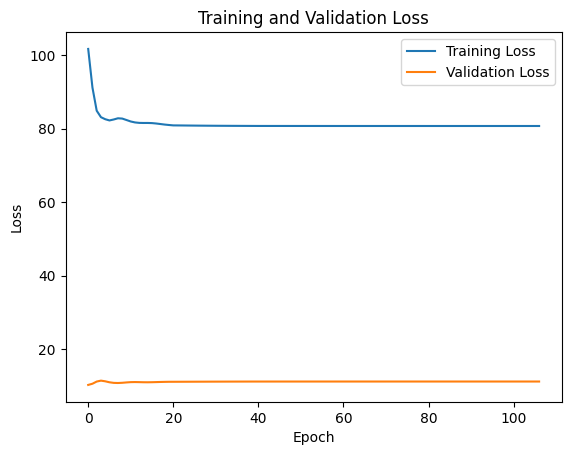

Model saved to models/gat_1l_mutag.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 10.14%
Average Memory Usage: 0.25GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 10.10s
Max CPU Usage: 58.85%
Max Memory Usage: 0.26GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [13]:
set_seed(42)
gat1_mutag = GAT1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gat1_mutag)
print(f"Total number of trainable parameters: {(gat1_mutag.count_parameters())*2}\n")
single_train(gat1_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, 
            num_epochs=500, step_size=20, save_path='models/gat_1l_mutag.pth')

In [14]:
gat1_mutag = GAT1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gat1_mutag.load_state_dict(torch.load('models/gat_1l_mutag.pth'))
single_test(gat1_mutag.to(device), mutag_test_loader)
inference_performance(gat1_mutag.to(device), mutag_test_loader)

Accuracy: 0.6842
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0044s
Average CPU Usage: 16.43%
Average Memory Usage: 0.25GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

#### SLIM160

### GAT 2-Layer

#### MUTAG

#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

#### SLIM160

## GCN

### GCN 1-Layer

#### MUTAG

GCN1Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 340


Fold 1/3
Epoch 1, Train Loss: 72.89328384399414, Val Loss: 8.741943061351776
Time: 0.01s, CPU: 39.30%, Memory: 0.10GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 66.599609375, Val Loss: 8.460152685642242
Time: 0.01s, CPU: 0.00%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 64.71770238876343, Val Loss: 8.375496864318848
Time: 0.01s, CPU: 16.65%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 64.00855588912964, Val Loss: 8.368660271167755
Time: 0.01s, CPU: 8.35%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 63.37956428527832, Val Loss: 8.330503821372986
Time: 0.01s, CPU: 0.00%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 62.37946557998657, Val Loss: 8.26278567314148
Time: 0.0

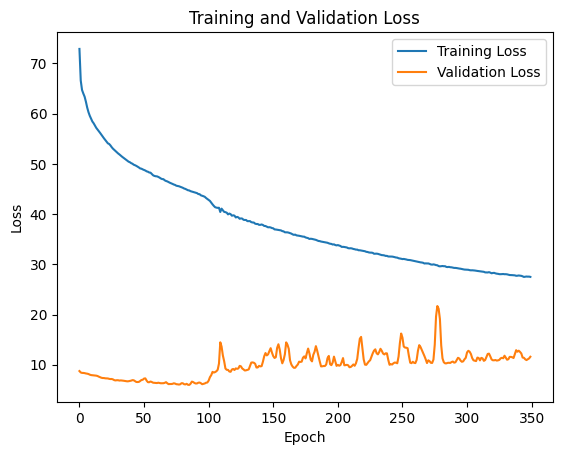

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.90%
Average Memory Usage: 0.12GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 1.90s
Max CPU Usage: 80.00%
Max Memory Usage: 0.12GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%
Fold 1 Results:
Accuracy: 0.8889
Average Sensitivity (Recall): 0.9756
Average Specificity: 0.7273

Fold 2/3
Epoch 1, Train Loss: 72.24380111694336, Val Loss: 8.883193135261536
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 64.45395088195801, Val Loss: 8.934863924980164
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 61.45788288116455, Val Loss: 9.26546198129654
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 59.70909118652344, Val Loss: 9.555239617824554
Time: 0.01s, CPU: 0.00%, Memory: 0.13GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 57.7092065811157

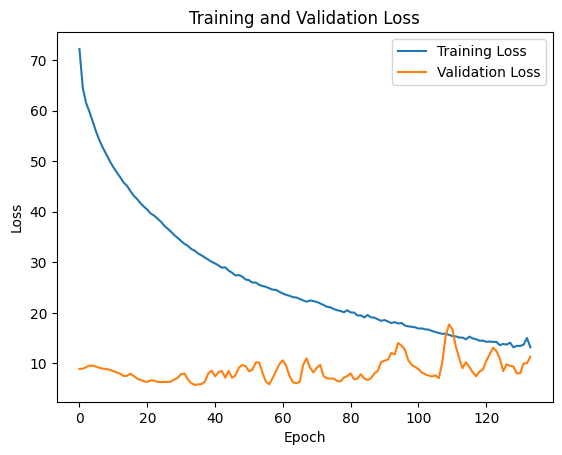

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.56%
Average Memory Usage: 0.13GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 0.82s
Max CPU Usage: 60.00%
Max Memory Usage: 0.14GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%
Fold 2 Results:
Accuracy: 0.8095
Average Sensitivity (Recall): 0.7857
Average Specificity: 0.8571

Fold 3/3
Epoch 1, Train Loss: 74.52165597677231, Val Loss: 8.537151336669922
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.91025590896606, Val Loss: 7.944094896316528
Time: 0.02s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 65.12292325496674, Val Loss: 7.597781121730804
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 63.303108751773834, Val Loss: 7.407283246517181
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 61.56655782461

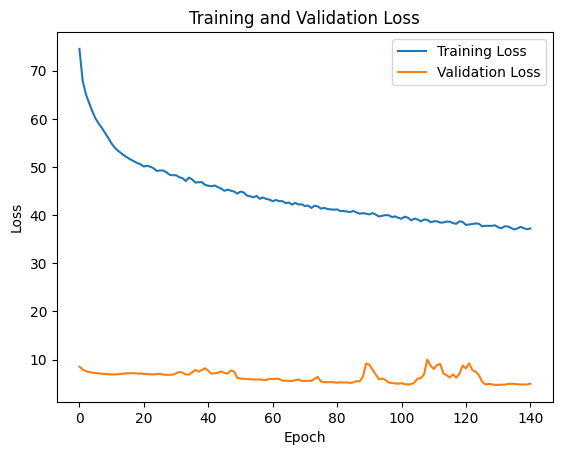

Model saved to models/gcn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.13%
Average Memory Usage: 0.14GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 0.85s
Max CPU Usage: 18.35%
Max Memory Usage: 0.14GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%
Fold 3 Results:
Accuracy: 0.8548
Average Sensitivity (Recall): 0.9048
Average Specificity: 0.7500
Cross-Validation Results:
accuracy: Mean = 0.8511, Std = 0.0325
sensitivity: Mean = 0.8887, Std = 0.0784
specificity: Mean = 0.7781, Std = 0.0566


In [22]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())*2}\n")
avg_metrics = single_train_test_cv(gcn1_mutag, mutag_dataset, num_folds=3, lr=0.01, num_epochs=500, step_size=500, save_path='models/gcn_1l_mutag.pth')

In [ ]:
set_seed(42)
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn1_mutag)
print(f"Total number of trainable parameters: {(gcn1_mutag.count_parameters())*2}\n")
single_train(gcn1_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_1l_mutag.pth')

Accuracy: 0.8421
Average Sensitivity (Recall): 0.9615
Average Specificity: 0.5833

Average Inference Time per Batch: 0.0004s
Average CPU Usage: 15.68%
Average Memory Usage: 4.52GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


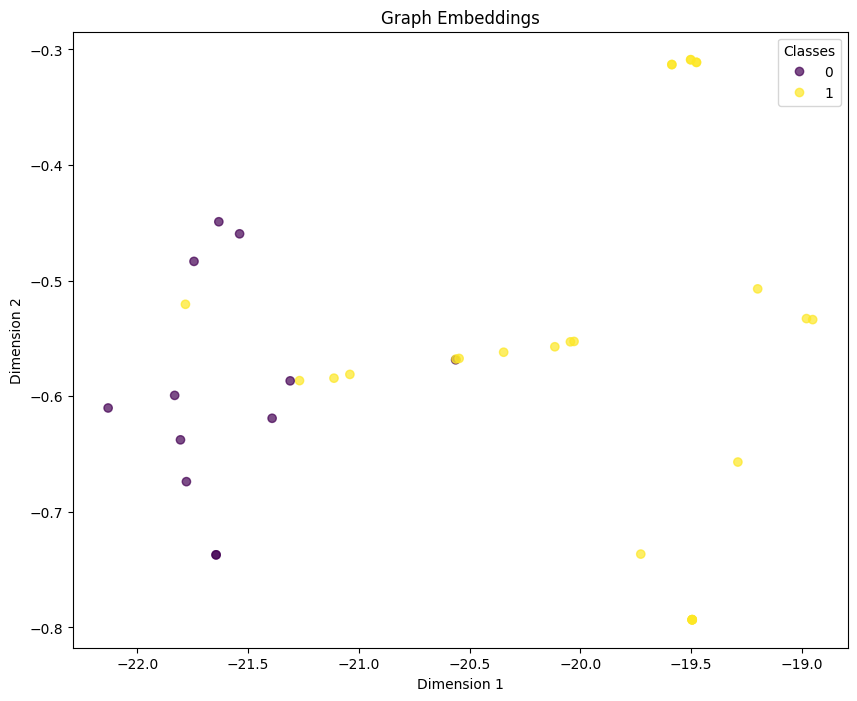

In [10]:
gcn1_mutag = GCN1Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn1_mutag.load_state_dict(torch.load('models/gcn_1l_mutag.pth'))
single_test(gcn1_mutag.to(device), mutag_test_loader)
inference_performance(gcn1_mutag.to(device), mutag_test_loader)

#### PROTEINS

GCN1Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 148

Epoch 1, Train Loss: 542.251392364502, Val Loss: 59.87826406955719
Time: 0.07s, CPU: 11.40%, Memory: 4.54GB, GPU: 0.03GB, GPU Util: 0.00%
Epoch 2, Train Loss: 527.7849671244621, Val Loss: 58.76831716299057
Time: 0.07s, CPU: 11.90%, Memory: 4.54GB, GPU: 0.04GB, GPU Util: 0.00%
Epoch 3, Train Loss: 524.6965968608856, Val Loss: 58.3279464840889
Time: 0.07s, CPU: 7.90%, Memory: 4.54GB, GPU: 0.04GB, GPU Util: 5.50%
Epoch 4, Train Loss: 522.4928016662598, Val Loss: 58.18120455741882
Time: 0.07s, CPU: 12.05%, Memory: 4.54GB, GPU: 0.04GB, GPU Util: 11.00%
Epoch 5, Train Loss: 520.9139139652252, Val Loss: 58.0422637462616
Time: 0.07s, CPU: 12.05%, Memory: 4.54GB, GPU: 0.04GB, GPU Util: 11.00%
Epoch 6, Train Loss: 519.5573785305023, Val Loss: 57.78257209062576
Time: 0.07s, CP

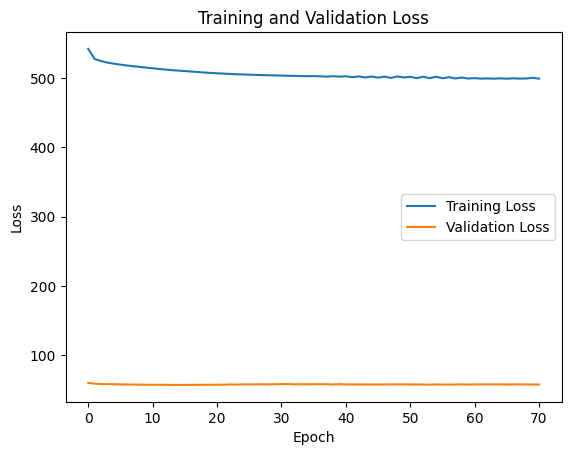

Model saved to models/gcn_1l_proteins.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 12.17%
Average Memory Usage: 4.54GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 10.54%

Total Training Time: 5.00s
Max CPU Usage: 30.70%
Max Memory Usage: 4.54GB
Max GPU Usage: 0.04GB
Max GPU Utilization: 12.00%


In [25]:
set_seed(42)
gcn1_proteins = GCN1Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn1_proteins)
print(f"Total number of trainable parameters: {(gcn1_proteins.count_parameters())*2}\n")
single_train(gcn1_proteins, proteins_train_loader, proteins_val_loader, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_1l_proteins.pth')

Accuracy: 0.6368
Average Sensitivity (Recall): 0.2418
Average Specificity: 0.9091

Average Inference Time per Batch: 0.0004s
Average CPU Usage: 6.77%
Average Memory Usage: 4.54GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 0.00%


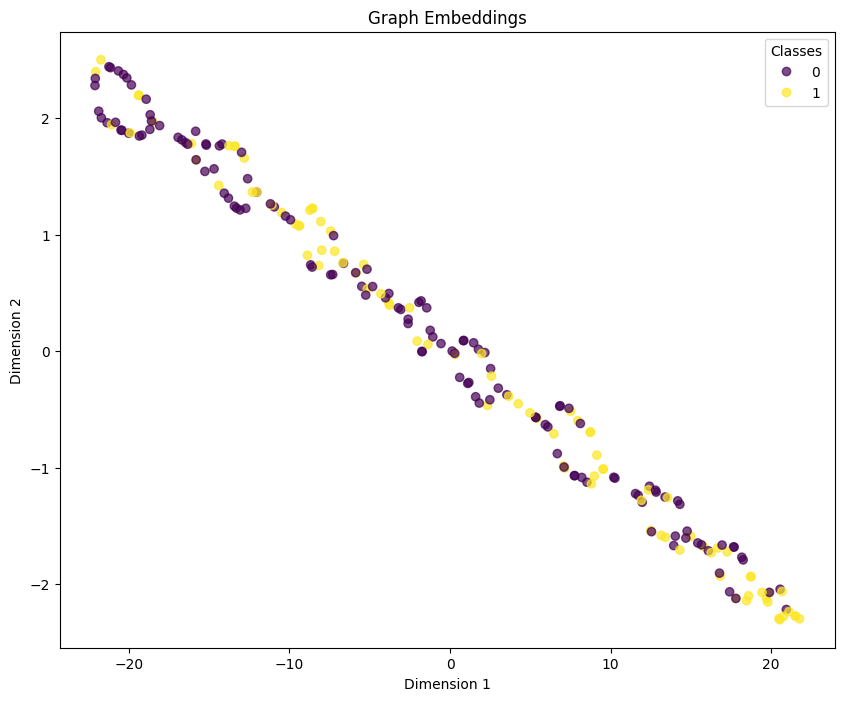

In [26]:
gcn1_proteins = GCN1Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
gcn1_proteins.load_state_dict(torch.load('models/gcn_1l_proteins.pth'))
single_test(gcn1_proteins.to(device), proteins_test_loader)
inference_performance(gcn1_proteins.to(device), proteins_test_loader)

#### DND

GCN1Layer(
  (gcn1): GCN (89 -> 178)
  (bn1): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 33468

Epoch 1, Train Loss: 539.5207841992378, Val Loss: 57.26763838529587
Time: 0.30s, CPU: 32.45%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 35.00%
Epoch 2, Train Loss: 492.2235709428787, Val Loss: 55.187343537807465
Time: 0.30s, CPU: 59.50%, Memory: 4.59GB, GPU: 1.22GB, GPU Util: 69.50%
Epoch 3, Train Loss: 484.90119567513466, Val Loss: 54.523500978946686
Time: 0.30s, CPU: 57.00%, Memory: 4.59GB, GPU: 1.22GB, GPU Util: 68.00%
Epoch 4, Train Loss: 480.8976925909519, Val Loss: 54.944134414196014
Time: 0.31s, CPU: 57.10%, Memory: 4.59GB, GPU: 1.22GB, GPU Util: 67.50%
Epoch 5, Train Loss: 475.7074918746948, Val Loss: 55.119579792022705
Time: 0.30s, CPU: 57.20%, Memory: 4.59GB, GPU: 1.22GB, GPU Util: 67.50%
Epoch 6, Train Loss: 470.5718881189823, Val Loss: 55.289264261

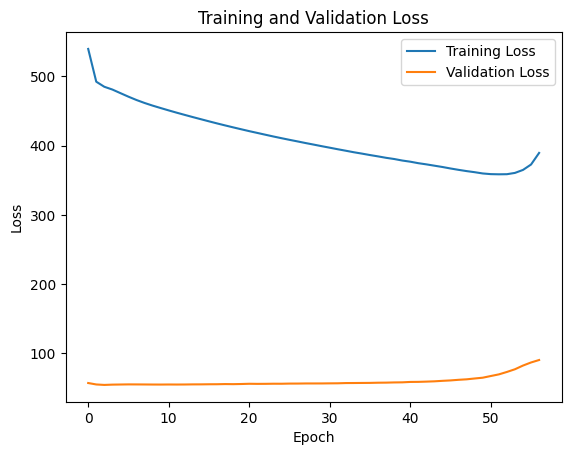

Model saved to models/gcn_1l_dnd.pth
Average Time per Epoch: 0.38s
Average CPU Usage: 58.86%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.22GB
Average GPU Utilization: 61.32%

Total Training Time: 21.45s
Max CPU Usage: 85.25%
Max Memory Usage: 4.59GB
Max GPU Usage: 1.22GB
Max GPU Utilization: 72.00%


In [43]:
set_seed(42)
gcn1_dnd = GCN1Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn1_dnd)
print(f"Total number of trainable parameters: {(gcn1_dnd.count_parameters())*2}\n")
single_train(gcn1_dnd, dnd_train_loader, dnd_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, gamma=0.5, save_path='models/gcn_1l_dnd.pth')

Accuracy: 0.6864
Average Sensitivity (Recall): 0.3263
Average Specificity: 0.9291

Average Inference Time per Batch: 0.0027s
Average CPU Usage: 49.44%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.30GB
Average GPU Utilization: 7.00%


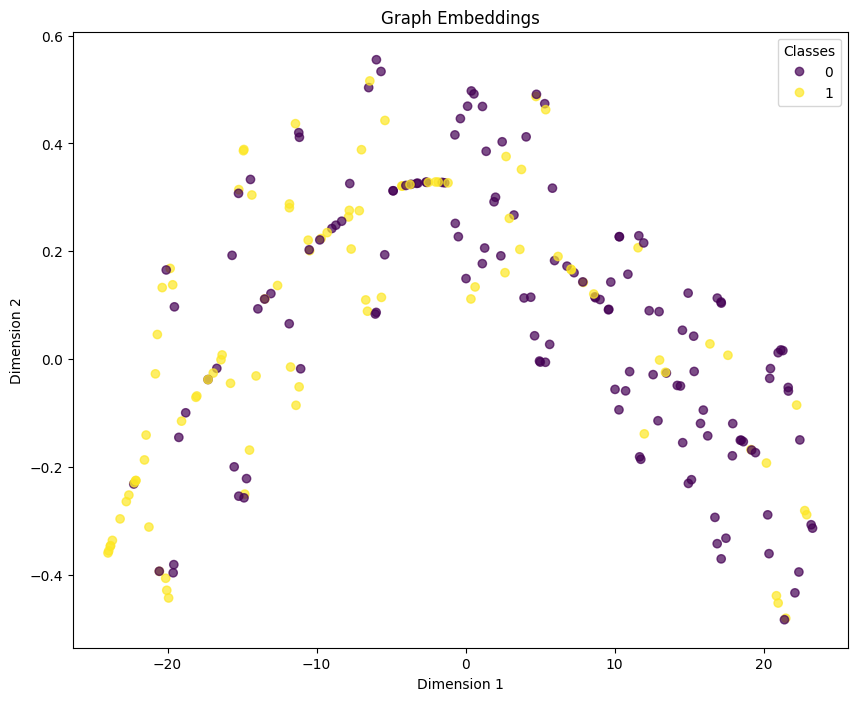

In [44]:
gcn1_dnd = GCN1Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
gcn1_dnd.load_state_dict(torch.load('models/gcn_1l_dnd.pth'))
single_test(gcn1_dnd.to(device), dnd_test_loader)
inference_performance(gcn1_dnd.to(device), dnd_test_loader)

#### ENZYM

GCN1Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 228

Epoch 1, Train Loss: 778.9972743988037, Val Loss: 87.08549118041992
Time: 0.04s, CPU: 8.05%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 2, Train Loss: 761.0409126281738, Val Loss: 85.78194427490234
Time: 0.04s, CPU: 17.15%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 3, Train Loss: 757.5995025634766, Val Loss: 84.7658519744873
Time: 0.04s, CPU: 24.45%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 4, Train Loss: 753.5449676513672, Val Loss: 84.2902603149414
Time: 0.04s, CPU: 16.45%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 7.00%
Epoch 5, Train Loss: 750.2431240081787, Val Loss: 84.06821060180664
Time: 0.04s, CPU: 13.40%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 7.00%
Epoch 6, Train Loss: 748.0430316925049, Val Loss: 83.82634735107422
Time: 0.04s, CPU

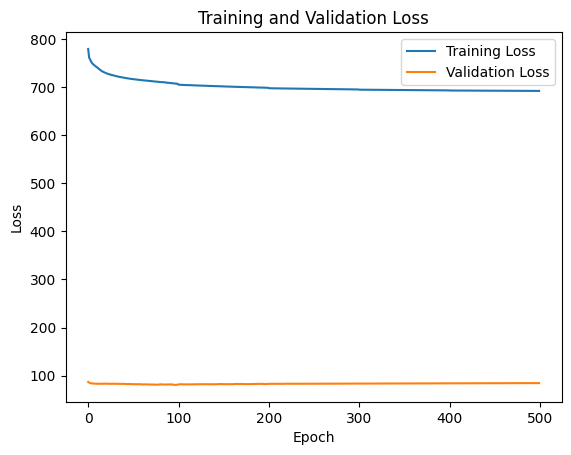

Model saved to models/gcn_1l_enzymes.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 14.28%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 9.57%

Total Training Time: 19.32s
Max CPU Usage: 46.90%
Max Memory Usage: 4.59GB
Max GPU Usage: 1.11GB
Max GPU Utilization: 11.00%


In [45]:
set_seed(42)
gcn1_enzymes = GCN1Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn1_enzymes)
print(f"Total number of trainable parameters: {(gcn1_enzymes.count_parameters())*2}\n")
single_train(gcn1_enzymes, enzymes_train_loader, enzymes_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, gamma=0.5, save_path='models/gcn_1l_enzymes.pth', 
            binary_classification=False)

Accuracy: 0.2583
Average Sensitivity (Recall): 0.2660
Average Specificity: 0.8524

Average Inference Time per Batch: 0.0004s
Average CPU Usage: 11.05%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 0.00%


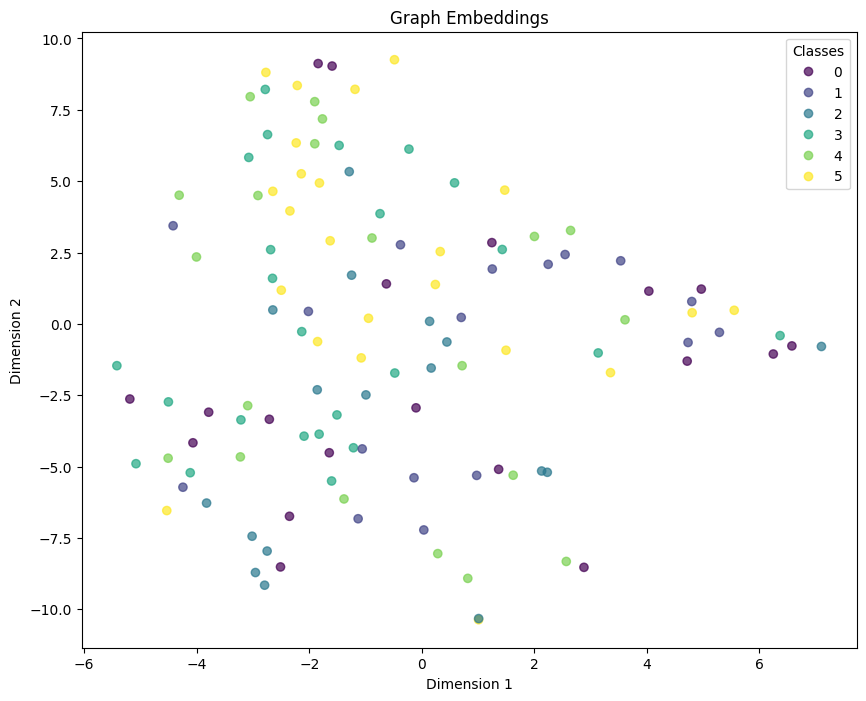

In [46]:
gcn1_enzymes = GCN1Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
gcn1_enzymes.load_state_dict(torch.load('models/gcn_1l_enzymes.pth'))
single_test(gcn1_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcn1_enzymes.to(device), enzymes_test_loader)

#### OASIS

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 390

Epoch 1, Train Loss: 271.2212026119232, Val Loss: 31.209784746170044
Time: 0.09s, CPU: 14.60%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 270.6651622056961, Val Loss: 31.11325240135193
Time: 0.09s, CPU: 12.00%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 3, Train Loss: 270.25449335575104, Val Loss: 31.03367829322815
Time: 0.11s, CPU: 19.00%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 269.9396622180939, Val Loss: 30.9683096408844
Time: 0.11s, CPU: 26.15%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 5, Train Loss: 269.6989566087723, Val Loss: 30.914416313171387
Time: 0.10s, CPU: 22.95%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 6, Train Loss: 269.51489090919495, Val Loss: 30.869946479797363
Time: 0.09s, CPU: 25.35%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.50%
Epoch 7, Train Loss: 269

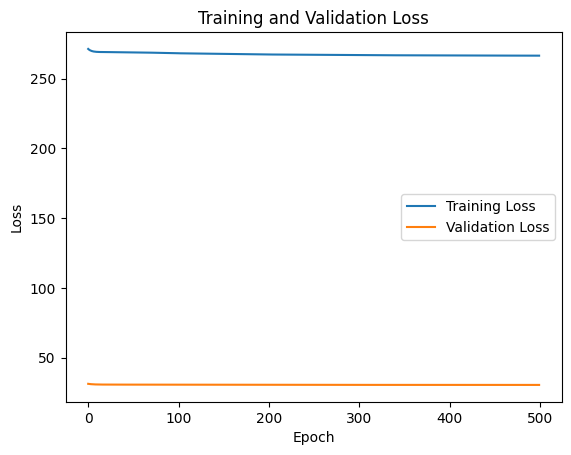

Model saved to models/gcn_1l_oasis.pth
Average Time per Epoch: 0.11s
Average CPU Usage: 23.73%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.28%

Total Training Time: 53.23s
Max CPU Usage: 66.60%
Max Memory Usage: 3.25GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%


In [12]:
set_seed(42)
gcn1_oasis = GCN1Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn1_oasis)
print(f"Total number of trainable parameters: {(gcn1_oasis.count_parameters())*2}\n")
single_train(gcn1_oasis, oasis_train_loader, oasis_val_loader, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_1l_oasis.pth')

In [22]:
gcn1_oasis = GCN1Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
gcn1_oasis.load_state_dict(torch.load('models/gcn_1l_oasis.pth'))
single_test(gcn1_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcn1_oasis.to(device), oasis_test_loader)

Accuracy: 0.2754
Average Sensitivity (Recall): 0.3467
Average Specificity: 0.6722

Average Inference Time per Batch: 0.0004s
Average CPU Usage: 12.23%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### EMCI-AD

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 356

Epoch 1, Train Loss: 66.93576407432556, Val Loss: 7.578530550003052
Time: 0.04s, CPU: 11.25%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 66.36269629001617, Val Loss: 7.604725003242493
Time: 0.04s, CPU: 8.35%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 3, Train Loss: 66.47167122364044, Val Loss: 7.6201446652412415
Time: 0.04s, CPU: 6.05%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 66.5421656370163, Val Loss: 7.611989200115204
Time: 0.05s, CPU: 21.85%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 5, Train Loss: 66.51615309715271, Val Loss: 7.603678464889526
Time: 0.04s, CPU: 15.35%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 6, Train Loss: 66.48370838165283, Val Loss: 7.601607263088226
Time: 0.05s, CPU: 18.15%, Memory: 3.21GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 7, Train Loss: 66.465881

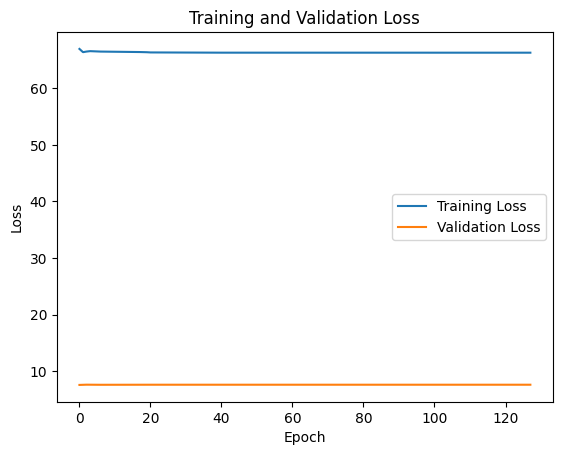

Model saved to models/gcn_1l_emci.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 13.53%
Average Memory Usage: 3.21GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.70%

Total Training Time: 5.60s
Max CPU Usage: 44.30%
Max Memory Usage: 3.21GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%


In [10]:
set_seed(42)
gcn1_emci = GCN1Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn1_emci)
print(f"Total number of trainable parameters: {(gcn1_emci.count_parameters())*2}\n")
single_train(gcn1_emci, emci_train_loader, emci_val_loader, 
            lr=0.01, num_epochs=500, step_size=20, patience=20, save_path='models/gcn_1l_emci.pth')


In [45]:
gcn1_emci = GCN1Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn1_emci.load_state_dict(torch.load('models/gcn_1l_emci.pth'))
single_test(gcn1_emci.to(device), emci_test_loader)
inference_performance(gcn1_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 30.63%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN1Layer(
  (gcn1): GCN (8 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 390

Epoch 1, Train Loss: 260.04783940315247, Val Loss: 29.889315247535706
Time: 0.13s, CPU: 38.50%, Memory: 3.33GB, GPU: 0.34GB, GPU Util: 5.50%
Epoch 2, Train Loss: 256.00520634651184, Val Loss: 29.789150834083557
Time: 0.13s, CPU: 54.25%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 14.00%
Epoch 3, Train Loss: 255.32504272460938, Val Loss: 29.69202482700348
Time: 0.17s, CPU: 55.60%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 14.50%
Epoch 4, Train Loss: 253.5604054927826, Val Loss: 29.77241063117981
Time: 0.12s, CPU: 51.25%, Memory: 3.34GB, GPU: 0.38GB, GPU Util: 12.00%
Epoch 5, Train Loss: 251.8092291355133, Val Loss: 29.8782559633255
Time: 0.17s, CPU: 50.30%, Memory: 3.33GB, GPU: 0.38GB, GPU Util: 17.00%
Epoch 6, Train Loss: 250.1774344444275, Val Loss: 29.931592226028442
Time: 0.13s, CPU: 46.35%, Memory: 3.34GB, GPU: 0.38GB, GPU Util: 15.50%
Epoch 7, Train Los

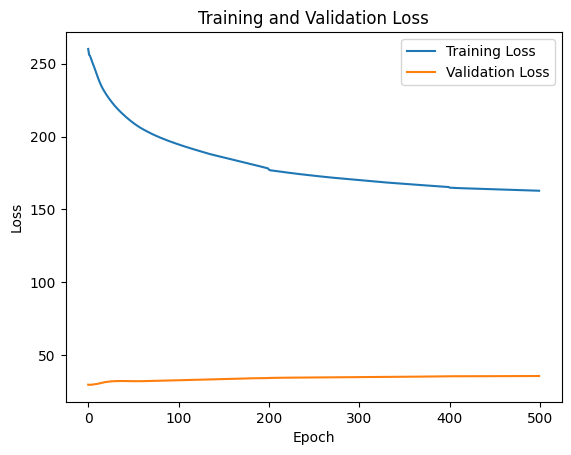

Model saved to models/gcn_1l_slim160.pth
Average Time per Epoch: 0.30s
Average CPU Usage: 55.50%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.38GB
Average GPU Utilization: 13.72%

Total Training Time: 151.67s
Max CPU Usage: 91.35%
Max Memory Usage: 3.36GB
Max GPU Usage: 0.38GB
Max GPU Utilization: 21.00%


In [16]:
set_seed(42)
gcn1_slim160 = GCN1Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn1_slim160)
print(f"Total number of trainable parameters: {(gcn1_slim160.count_parameters())*2}\n")
single_train(gcn1_slim160, slim160_train_loader, slim160_val_loader, 
            lr=0.01, num_epochs=500, step_size=200, gamma=0.5,
            save_path='models/gcn_1l_slim160.pth', binary_classification=False)


In [46]:
gcn1_slim160 = GCN1Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn1_slim160.load_state_dict(torch.load('models/gcn_1l_slim160.pth'))
single_test(gcn1_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn1_slim160.to(device), slim160_test_loader)

Accuracy: 0.3788
Average Sensitivity (Recall): 0.3981
Average Specificity: 0.6925

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 35.02%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 1.00%


### GCN 2-Layer

#### MUTAG

GCN2Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1348

Epoch 1, Train Loss: 97.2948517203331, Val Loss: 11.064492166042328
Time: 0.02s, CPU: 9.30%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.15675860643387, Val Loss: 11.626159250736237
Time: 0.02s, CPU: 7.70%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 3, Train Loss: 60.971393167972565, Val Loss: 11.800771057605743
Time: 0.02s, CPU: 21.55%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 4, Train Loss: 57.3019817173481, Val Loss: 10.643194019794464
Time: 0.02s, CPU: 15.40%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 0.00%
Epoch 5, Train Loss: 54.29932287335396, Val Loss: 8.543638586997986
Time: 0.02s, CPU: 14.30%, Memory:

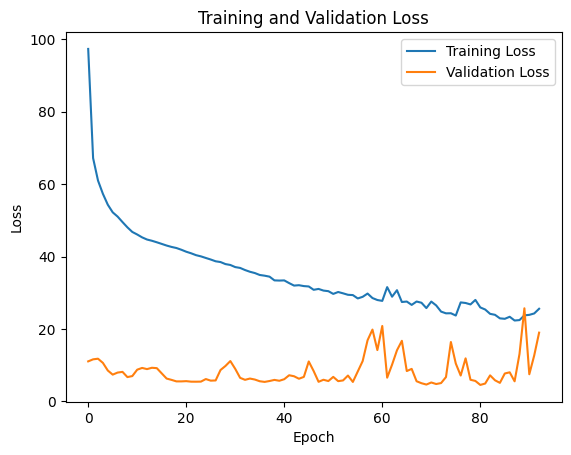

Model saved to models/gcn_2l_mutag.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 11.40%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 7.78%

Total Training Time: 1.43s
Max CPU Usage: 29.15%
Max Memory Usage: 4.59GB
Max GPU Usage: 1.11GB
Max GPU Utilization: 9.00%


In [47]:
set_seed(42)
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn2_mutag)
print(f"Total number of trainable parameters: {(gcn2_mutag.count_parameters())*2}\n")
single_train(gcn2_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_mutag.pth')

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 0.75%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 0.00%


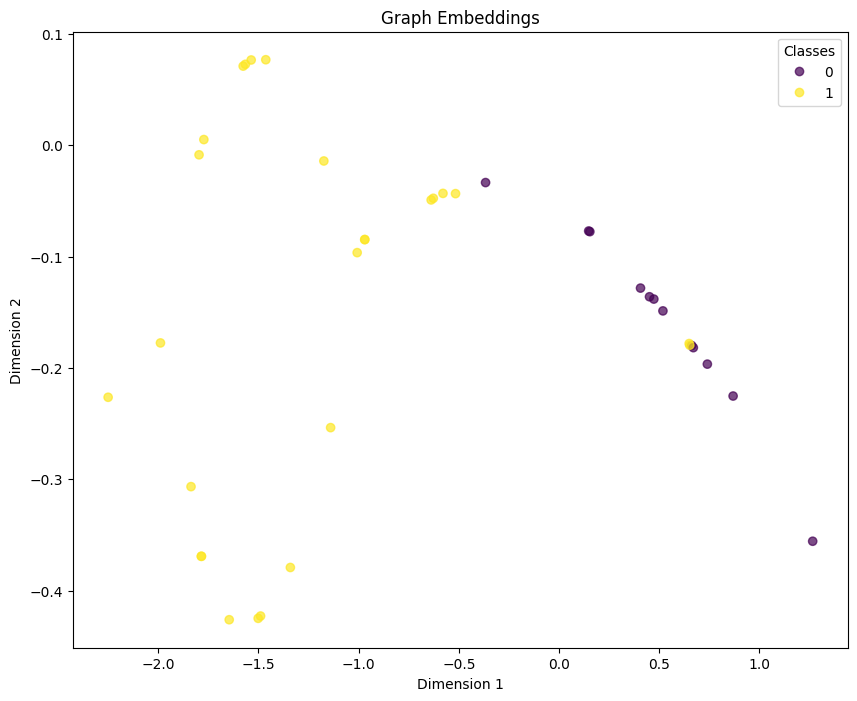

In [48]:
gcn2_mutag = GCN2Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn2_mutag.load_state_dict(torch.load('models/gcn_2l_mutag.pth'))
single_test(gcn2_mutag.to(device), mutag_test_loader)
inference_performance(gcn2_mutag.to(device), mutag_test_loader)

#### PROTEINS

GCN2Layer(
  (gcn1): GCN (3 -> 9)
  (bn1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (9 -> 18)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 616

Epoch 1, Train Loss: 518.4904714822769, Val Loss: 55.17985129356384
Time: 0.08s, CPU: 11.30%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 1.00%
Epoch 2, Train Loss: 508.1804996728897, Val Loss: 54.78326469659805
Time: 0.08s, CPU: 12.90%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 2.00%
Epoch 3, Train Loss: 500.2086865901947, Val Loss: 54.73651033639908
Time: 0.08s, CPU: 11.20%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 8.50%
Epoch 4, Train Loss: 496.7972237467766, Val Loss: 54.45407426357269
Time: 0.08s, CPU: 13.15%, Memory: 4.59GB, GPU: 1.11GB, GPU Util: 15.00%
Epoch 5, Train Loss: 493.71574330329895, Val Loss: 55.03725206851959
Time: 0.08s, CPU: 12.00%, Memory: 4.

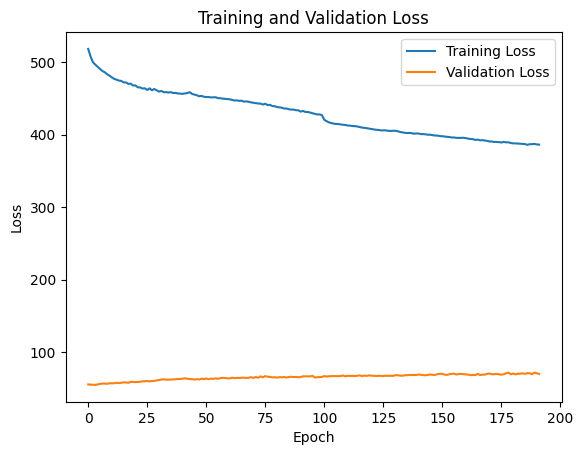

Model saved to models/gcn_2l_proteins.pth
Average Time per Epoch: 0.08s
Average CPU Usage: 13.43%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 14.05%

Total Training Time: 15.02s
Max CPU Usage: 31.30%
Max Memory Usage: 4.59GB
Max GPU Usage: 1.11GB
Max GPU Utilization: 15.00%


In [49]:
set_seed(42)
gcn2_proteins = GCN2Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn2_proteins)
print(f"Total number of trainable parameters: {(gcn2_proteins.count_parameters())*2}\n")
single_train(gcn2_proteins, proteins_train_loader, proteins_val_loader, lr=0.005, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_proteins.pth')

Accuracy: 0.6233
Average Sensitivity (Recall): 0.3516
Average Specificity: 0.8106

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 8.04%
Average Memory Usage: 4.59GB
Average GPU Usage: 1.11GB
Average GPU Utilization: 0.43%


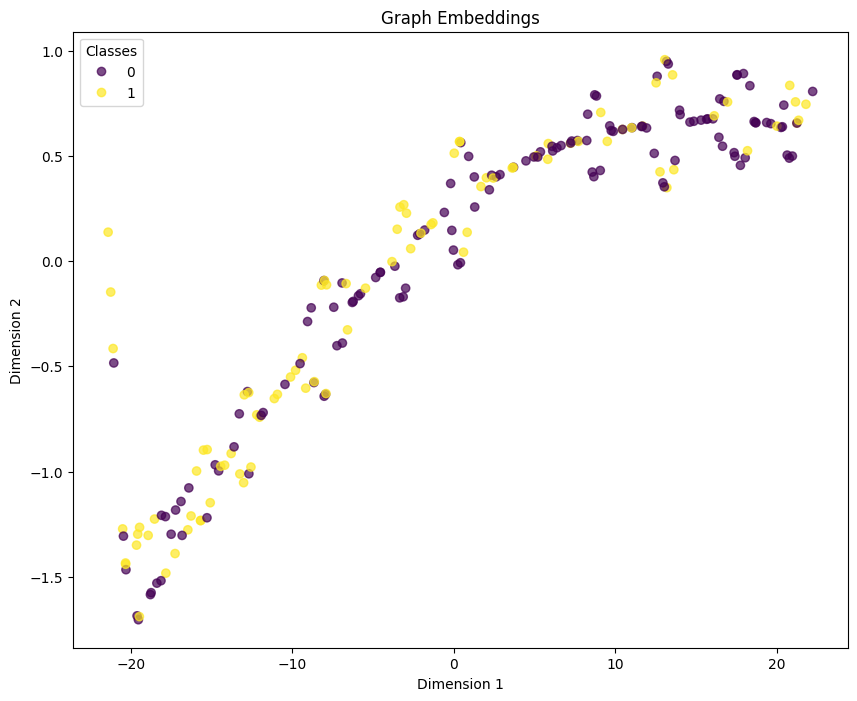

In [50]:
gcn2_proteins = GCN2Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
gcn2_proteins.load_state_dict(torch.load('models/gcn_2l_proteins.pth'))
single_test(gcn2_proteins.to(device), proteins_test_loader)
inference_performance(gcn2_proteins.to(device), proteins_test_loader)

#### DND

GCN2Layer(
  (gcn1): GCN (89 -> 178)
  (gcn2): GCN (178 -> 356)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 160916

Epoch 1, Train Loss: 621.6430268883705, Val Loss: 65.25818818807602
Time: 1.11s, CPU: 23.95%, Memory: 3.98GB, GPU: 0.07GB, GPU Util: 25.00%
Epoch 2, Train Loss: 574.6264258027077, Val Loss: 63.62443023920059
Time: 1.01s, CPU: 30.15%, Memory: 3.98GB, GPU: 0.18GB, GPU Util: 78.00%
Epoch 3, Train Loss: 543.2166835069656, Val Loss: 58.95075809955597
Time: 0.92s, CPU: 22.30%, Memory: 3.98GB, GPU: 0.18GB, GPU Util: 71.00%
Epoch 4, Train Loss: 513.9627436697483, Val Loss: 56.45810890197754
Time: 0.91s, CPU: 27.20%, Memory: 3.98GB, GPU: 0.18GB, GPU Util: 79.00%
Epoch 5, Train Loss: 506.4680352807045, Val Loss: 57.00013589859009
Time: 0.88s, CPU: 22.95%, Memory: 3.98GB, GPU: 0.18GB, GPU Util: 83.00%
Epoch 6, Train Loss: 491.4641170203686, Val Loss: 54.6330349445343
Time: 1.04s, CPU: 26.95%, Memory: 3.98GB, GPU: 0.18GB, GPU Uti

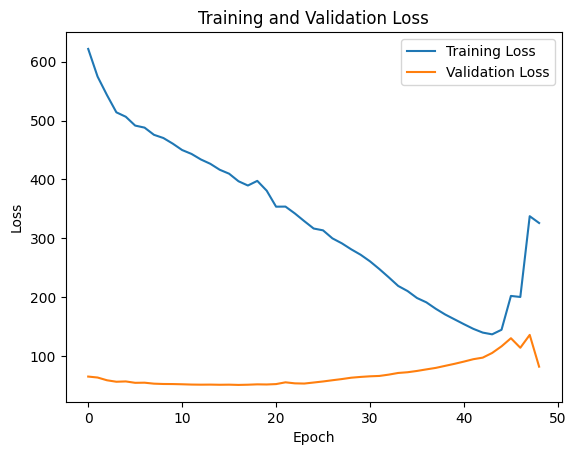

Model saved to models/gcn_2l_dnd.pth
Average Time per Epoch: 1.21s
Average CPU Usage: 45.34%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.18GB
Average GPU Utilization: 58.44%

Total Training Time: 59.21s
Max CPU Usage: 68.15%
Max Memory Usage: 3.98GB
Max GPU Usage: 0.18GB
Max GPU Utilization: 83.00%


In [43]:
set_seed(42)
gcn2_dnd = GCN2Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn2_dnd)
print(f"Total number of trainable parameters: {(gcn2_dnd.count_parameters())*2}\n")
single_train(gcn2_dnd, dnd_train_loader, dnd_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_2l_dnd.pth')

In [44]:
gcn2_dnd = GCN2Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
gcn2_dnd.load_state_dict(torch.load('models/gcn_2l_dnd.pth'))
single_test(gcn2_dnd.to(device), dnd_test_loader)
inference_performance(gcn2_dnd.to(device), dnd_test_loader)

Accuracy: 0.6695
Average Sensitivity (Recall): 0.7053
Average Specificity: 0.6454

Average Inference Time per Batch: 0.0109s
Average CPU Usage: 30.87%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.26GB
Average GPU Utilization: 38.88%


#### ENZYM

GCN2Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 660

Epoch 1, Train Loss: 781.4373950958252, Val Loss: 86.54996490478516
Time: 0.08s, CPU: 16.35%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 0.00%
Epoch 2, Train Loss: 777.5511150360107, Val Loss: 86.47380256652832
Time: 0.08s, CPU: 14.35%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 1.50%
Epoch 3, Train Loss: 776.3004417419434, Val Loss: 86.39432907104492
Time: 0.09s, CPU: 16.50%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 3.00%
Epoch 4, Train Loss: 775.523811340332, Val Loss: 86.3552417755127
Time: 0.09s, CPU: 9.70%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 5.00%
Epoch 5, Train Loss: 774.7764167785645, Val Loss: 86.33688163757324
Time: 0.07s, CPU: 12.40%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 5.00%
Epoch 6, Train Loss: 774.0312633514404, Val Loss: 86.31731796264648
Time: 0.08s, CPU: 18.95%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 5.00%
Epoch 7,

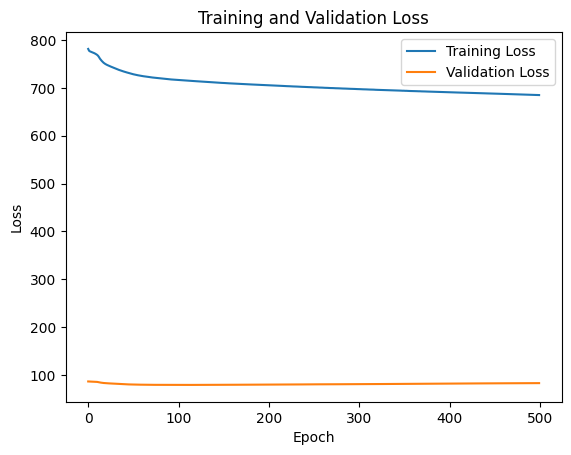

Model saved to models/gcn_2l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 16.62%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 5.75%

Total Training Time: 37.35s
Max CPU Usage: 47.65%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.13GB
Max GPU Utilization: 7.00%


In [100]:
set_seed(42)
gcn2_enzymes = GCN2Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn2_enzymes)
print(f"Total number of trainable parameters: {(gcn2_enzymes.count_parameters())*2}\n")
single_train(gcn2_enzymes, enzymes_train_loader, enzymes_val_loader, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_enzymes.pth', binary_classification=False)

In [101]:
gcn2_enzymes = GCN2Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
gcn2_enzymes.load_state_dict(torch.load('models/gcn_2l_enzymes.pth'))
single_test(gcn2_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcn2_enzymes.to(device), enzymes_test_loader)

Accuracy: 0.2750
Average Sensitivity (Recall): 0.2856
Average Specificity: 0.8555

Average Inference Time per Batch: 0.0007s
Average CPU Usage: 4.56%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.38%


#### OASIS

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1574

Epoch 1, Train Loss: 276.66574239730835, Val Loss: 30.85453748703003
Time: 0.15s, CPU: 22.35%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 271.6338634490967, Val Loss: 30.886475563049316
Time: 0.12s, CPU: 17.90%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 3, Train Loss: 273.02960753440857, Val Loss: 30.48271107673645
Time: 0.12s, CPU: 28.90%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.50%
Epoch 4, Train Loss: 270.4346042871475, Val Loss: 30.55841302871704
Time: 0.12s, CPU: 25.00%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Loss: 269.6003609895706, Val Loss: 30.536269903182983
Time: 0.12s, CPU: 26.95%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 6, Train Loss: 269.5209950208664, Val Loss: 30.50264000892639
Time: 0.12s, CPU: 26.80%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.50

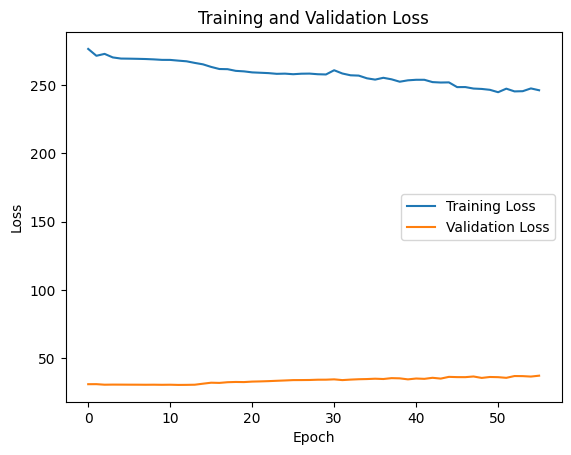

Model saved to models/gcn_2l_oasis.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 28.54%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.69%

Total Training Time: 6.82s
Max CPU Usage: 52.90%
Max Memory Usage: 3.25GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 7.00%


In [14]:
set_seed(42)
gcn2_oasis = GCN2Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn2_oasis)
print(f"Total number of trainable parameters: {(gcn2_oasis.count_parameters())*2}\n")
single_train(gcn2_oasis, oasis_train_loader, oasis_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_2l_oasis.pth')

In [23]:
gcn2_oasis = GCN2Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
gcn2_oasis.load_state_dict(torch.load('models/gcn_2l_oasis.pth'))
single_test(gcn2_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcn2_oasis.to(device), oasis_test_loader)

Accuracy: 0.3478
Average Sensitivity (Recall): 0.3481
Average Specificity: 0.6713

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 20.26%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### EMCI-AD

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1508

Epoch 1, Train Loss: 71.56606495380402, Val Loss: 7.8566460609436035
Time: 0.07s, CPU: 17.05%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 0.00%
Epoch 2, Train Loss: 68.20633161067963, Val Loss: 7.5821457505226135
Time: 0.06s, CPU: 26.35%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 1.50%
Epoch 3, Train Loss: 66.41744589805603, Val Loss: 7.683176159858704
Time: 0.06s, CPU: 25.45%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 3.00%
Epoch 4, Train Loss: 66.86147153377533, Val Loss: 7.593149483203888
Time: 0.07s, CPU: 23.65%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 3.50%
Epoch 5, Train Loss: 66.37889873981476, Val Loss: 7.639395236968994
Time: 0.06s, CPU: 21.15%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 4.00%
Epoch 6, Train Loss: 66.55304217338562, Val Loss: 7.621022880077362
Time: 0.07s, CPU: 21.35%, Memory: 3.34GB, GPU: 0.34GB, GPU Util: 4.00%


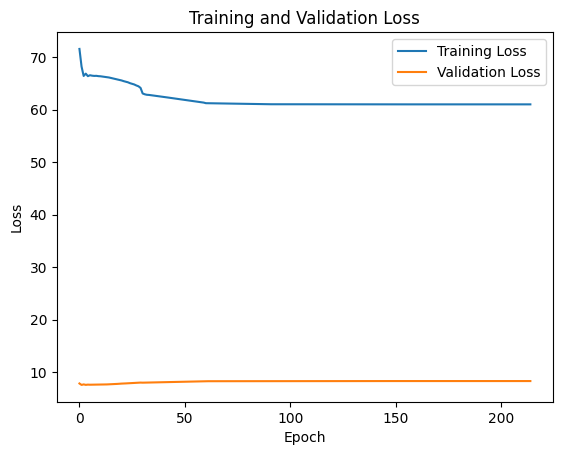

Model saved to models/gcn_2l_emci.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 20.03%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.34GB
Average GPU Utilization: 4.72%

Total Training Time: 11.65s
Max CPU Usage: 48.25%
Max Memory Usage: 3.34GB
Max GPU Usage: 0.34GB
Max GPU Utilization: 6.00%


In [22]:
set_seed(42)
gcn2_emci = GCN2Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn2_emci)
print(f"Total number of trainable parameters: {(gcn2_emci.count_parameters())*2}\n")
single_train(gcn2_emci, emci_train_loader, emci_val_loader, 
            lr=0.01, num_epochs=500, step_size=30, patience=10, 
            save_path='models/gcn_2l_emci.pth')


In [48]:
gcn2_emci = GCN2Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn2_emci.load_state_dict(torch.load('models/gcn_2l_emci.pth'))
single_test(gcn2_emci.to(device), emci_test_loader)
inference_performance(gcn2_emci.to(device), emci_test_loader)

Accuracy: 0.5556
Average Sensitivity (Recall): 0.5455
Average Specificity: 0.5625

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 14.90%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN2Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1574

Epoch 1, Train Loss: 508.5967903137207, Val Loss: 39.408928871154785
Time: 0.22s, CPU: 40.60%, Memory: 3.36GB, GPU: 0.45GB, GPU Util: 4.00%
Epoch 2, Train Loss: 278.14805006980896, Val Loss: 32.664613008499146
Time: 0.15s, CPU: 51.15%, Memory: 3.36GB, GPU: 0.49GB, GPU Util: 13.00%
Epoch 3, Train Loss: 258.1234874725342, Val Loss: 31.4747132062912
Time: 0.13s, CPU: 53.50%, Memory: 3.37GB, GPU: 0.49GB, GPU Util: 20.00%
Epoch 4, Train Loss: 241.13186943531036, Val Loss: 31.333887577056885
Time: 0.14s, CPU: 43.65%, Memory: 3.39GB, GPU: 0.49GB, GPU Util: 22.50%
Epoch 5, Train Loss: 240.39900135993958, Val Loss: 30.568740248680115
Time: 0.14s, CPU: 48.30%, Memory: 3.37GB, GPU: 0.49GB, GPU Util: 22.00%
Epoch 6, Train Loss: 229.95044255256653, Val Loss: 30.631211042404175
Time: 0.35s, CPU: 34.30%, Memory: 3.38GB, GPU: 0.33GB, GPU Ut

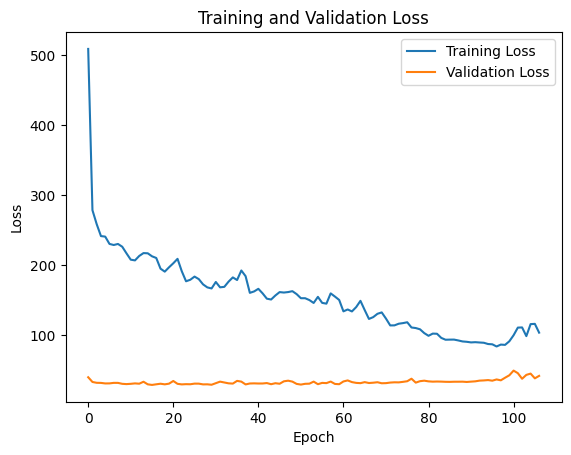

Model saved to models/gcn_2l_slim160.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 50.35%
Average Memory Usage: 3.37GB
Average GPU Usage: 0.18GB
Average GPU Utilization: 21.59%

Total Training Time: 15.64s
Max CPU Usage: 80.55%
Max Memory Usage: 3.39GB
Max GPU Usage: 0.49GB
Max GPU Utilization: 28.00%


In [33]:
set_seed(42)
gcn2_slim160 = GCN2Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn2_slim160)
print(f"Total number of trainable parameters: {(gcn2_slim160.count_parameters())*2}\n")
single_train(gcn2_slim160, slim160_train_loader, slim160_val_loader, 
            lr=0.01, num_epochs=500, step_size=75, patience=10, gamma=0.5,
            save_path='models/gcn_2l_slim160.pth', binary_classification=False)


In [50]:
gcn2_slim160 = GCN2Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn2_slim160.load_state_dict(torch.load('models/gcn_2l_slim160.pth'))
single_test(gcn2_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn2_slim160.to(device), slim160_test_loader)

Accuracy: 0.4091
Average Sensitivity (Recall): 0.4120
Average Specificity: 0.7034

Average Inference Time per Batch: 0.0015s
Average CPU Usage: 36.37%
Average Memory Usage: 3.38GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 1.33%


### GCN 3-Layer

#### MUTAG

GCN3Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 14)
  (bn3): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 2160

Epoch 1, Train Loss: 86.51026570796967, Val Loss: 10.46858936548233
Time: 0.03s, CPU: 14.00%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 82.08281904459, Val Loss: 10.481446981430054
Time: 0.03s, CPU: 13.65%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 3, Train Loss: 78.75292456150055, Val Loss: 10.361693501472473
Time: 0.03s, CPU: 8.00%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 4, Train Loss: 75.76006925106049, Val Loss: 10.122548639774323
Time: 0.04s, CPU: 13.80%, Memory: 3.14GB, GPU: 0.02GB, GPU U

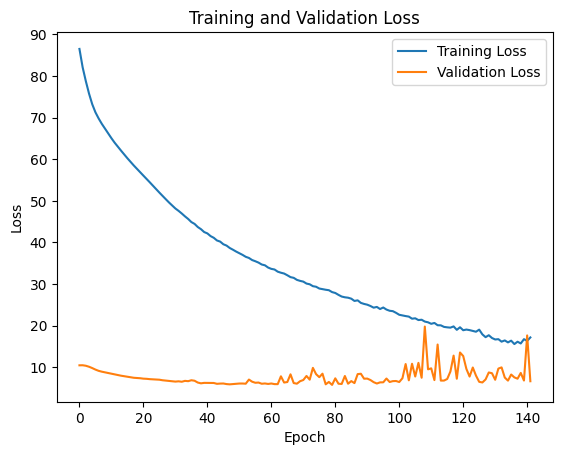

Model saved to models/gcn_3l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 25.15%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.55%

Total Training Time: 4.34s
Max CPU Usage: 53.20%
Max Memory Usage: 3.14GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%


In [21]:
set_seed(42)
gcn3_mutag = GCN3Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn3_mutag)
print(f"Total number of trainable parameters: {(gcn3_mutag.count_parameters())*2}\n")
single_train(gcn3_mutag, mutag_train_loader, mutag_val_loader, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_mutag.pth')

In [22]:
gcn3_mutag = GCN3Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn3_mutag.load_state_dict(torch.load('models/gcn_3l_mutag.pth'))
single_test(gcn3_mutag.to(device), mutag_test_loader)
inference_performance(gcn3_mutag.to(device), mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0007s
Average CPU Usage: 17.07%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### PROTEINS

GCN3Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 9)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 814

Epoch 1, Train Loss: 534.5297865867615, Val Loss: 58.801357209682465
Time: 0.16s, CPU: 14.95%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 1.50%
Epoch 2, Train Loss: 534.3358796238899, Val Loss: 58.803684771060944
Time: 0.15s, CPU: 27.20%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 5.50%
Epoch 3, Train Loss: 541.000208735466, Val Loss: 58.10534626245499
Time: 0.15s, CPU: 23.90%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 529.8150383234024, Val Loss: 58.5428472161293
Time: 0.15s, CPU: 20.10%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 525.2953674793243, Val Loss: 57.1085501909256
Time: 0.14s, CPU: 26.05%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 6, Train Loss: 518.8460148572922, Val Loss: 54.988021314144135
Time: 0.15s, CPU: 14.40%, Memory: 3.98GB, GPU: 0.02GB

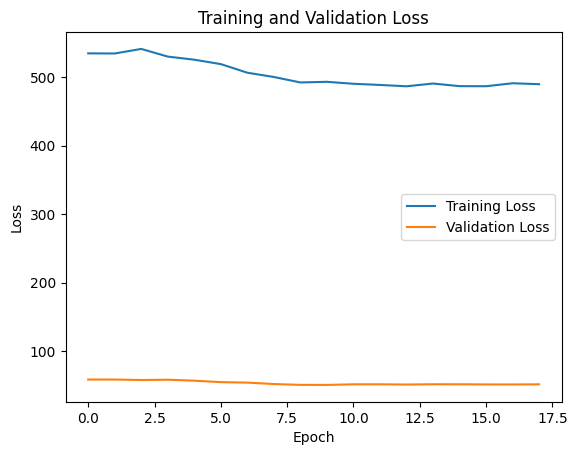

Model saved to models/gcn_3l_proteins.pth
Average Time per Epoch: 0.14s
Average CPU Usage: 15.95%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.92%

Total Training Time: 2.59s
Max CPU Usage: 27.20%
Max Memory Usage: 3.98GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%


In [63]:
set_seed(42)
gcn3_proteins = GCN3Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn3_proteins)
print(f"Total number of trainable parameters: {(gcn3_proteins.count_parameters())*2}\n")
single_train(gcn3_proteins, proteins_train_loader, proteins_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_proteins.pth')

In [64]:
gcn3_proteins = GCN3Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
gcn3_proteins.load_state_dict(torch.load('models/gcn_3l_proteins.pth'))
single_test(gcn3_proteins.to(device), proteins_test_loader)
inference_performance(gcn3_proteins.to(device), proteins_test_loader)

Accuracy: 0.6143
Average Sensitivity (Recall): 0.5385
Average Specificity: 0.6667

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 20.36%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 0.00%


#### DND

GCN3Layer(
  (gcn1): GCN (89 -> 178)
  (gcn2): GCN (178 -> 356)
  (gcn3): GCN (356 -> 178)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 287296

Epoch 1, Train Loss: 934.7356151342392, Val Loss: 62.31033045053482
Time: 1.39s, CPU: 20.95%, Memory: 3.98GB, GPU: 0.07GB, GPU Util: 28.00%
Epoch 2, Train Loss: 553.577757537365, Val Loss: 62.974065601825714
Time: 1.34s, CPU: 34.15%, Memory: 3.98GB, GPU: 0.17GB, GPU Util: 50.00%
Epoch 3, Train Loss: 543.9592317938805, Val Loss: 59.0948982834816
Time: 1.79s, CPU: 57.55%, Memory: 3.98GB, GPU: 0.17GB, GPU Util: 49.00%
Epoch 4, Train Loss: 512.9547656774521, Val Loss: 60.96751421689987
Time: 1.34s, CPU: 46.95%, Memory: 3.98GB, GPU: 0.17GB, GPU Util: 63.00%
Epoch 5, Train Loss: 516.1311339437962, Val Loss: 56.290114998817444
Time: 1.49s, CPU: 29.85%, Memory: 3.98GB, GPU: 0.17GB, GPU Util: 83.50%
Epoch 6, Train Loss: 503.6271488070488, Val Loss: 52.23356622457504
Time: 1.35s, CPU: 27.00%, Memory: 

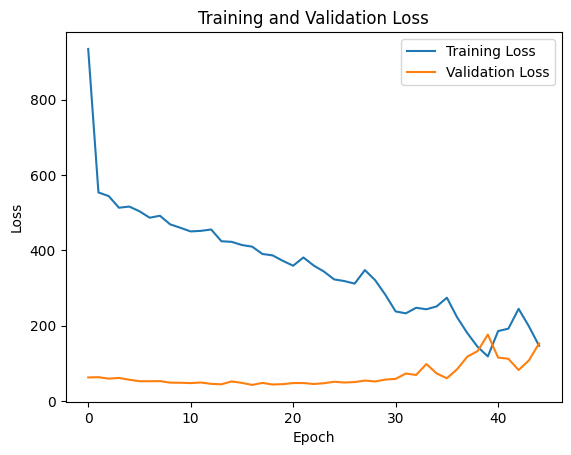

Model saved to models/gcn_3l_dnd.pth
Average Time per Epoch: 1.31s
Average CPU Usage: 28.42%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.17GB
Average GPU Utilization: 76.49%

Total Training Time: 59.13s
Max CPU Usage: 57.55%
Max Memory Usage: 3.98GB
Max GPU Usage: 0.17GB
Max GPU Utilization: 87.50%


In [61]:
set_seed(42)
gcn3_dnd = GCN3Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn3_dnd)
print(f"Total number of trainable parameters: {(gcn3_dnd.count_parameters())*2}\n")
single_train(gcn3_dnd, dnd_train_loader, dnd_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_3l_dnd.pth')

In [62]:
gcn3_dnd = GCN3Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
gcn3_dnd.load_state_dict(torch.load('models/gcn_3l_dnd.pth'))
single_test(gcn3_dnd.to(device), dnd_test_loader)
inference_performance(gcn3_dnd.to(device), dnd_test_loader)

Accuracy: 0.6780
Average Sensitivity (Recall): 0.3895
Average Specificity: 0.8723

Average Inference Time per Batch: 0.0155s
Average CPU Usage: 35.29%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.25GB
Average GPU Utilization: 53.00%


#### ENZYM

GCN3Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 9)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 894

Epoch 1, Train Loss: 792.7690467834473, Val Loss: 88.13405227661133
Time: 0.08s, CPU: 17.30%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 1.00%
Epoch 2, Train Loss: 784.7152099609375, Val Loss: 87.52825927734375
Time: 0.08s, CPU: 21.25%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 2.00%
Epoch 3, Train Loss: 782.4484596252441, Val Loss: 87.32097816467285
Time: 0.09s, CPU: 24.35%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 4.50%
Epoch 4, Train Loss: 781.4705123901367, Val Loss: 87.18851470947266
Time: 0.07s, CPU: 22.45%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 7.00%
Epoch 5, Train Loss: 780.6271800994873, Val Loss: 87.06101417541504
Time: 0.07s, CPU: 24.30%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 7.00%
Epoch 6, Train Loss: 779.8828372955322, Val Loss: 86.94829368591309
Time: 0.08s, CPU: 27.80%, Memory: 4.05GB, GPU: 0.13GB

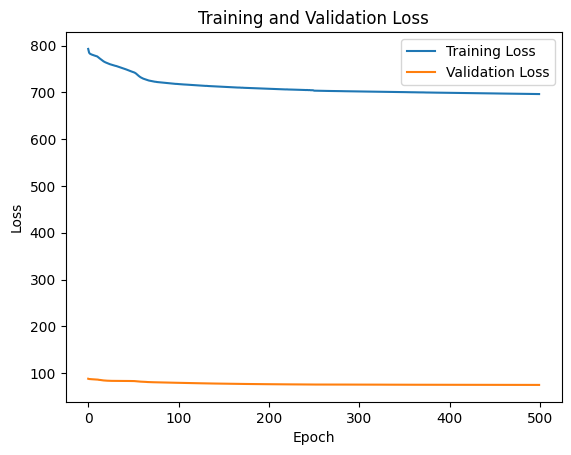

Model saved to models/gcn_3l_enzymes.pth
Average Time per Epoch: 0.07s
Average CPU Usage: 16.71%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 7.34%

Total Training Time: 36.59s
Max CPU Usage: 42.80%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.13GB
Max GPU Utilization: 9.00%


In [95]:
set_seed(42)
gcn3_enzymes = GCN3Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn3_enzymes)
print(f"Total number of trainable parameters: {(gcn3_enzymes.count_parameters())*2}\n")
single_train(gcn3_enzymes, enzymes_train_loader, enzymes_val_loader, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_3l_enzymes.pth', 
            binary_classification=False)

In [96]:
gcn3_enzymes = GCN3Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
gcn3_enzymes.load_state_dict(torch.load('models/gcn_3l_enzymes.pth'))
single_test(gcn3_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcn3_enzymes.to(device), enzymes_test_loader)

Accuracy: 0.2833
Average Sensitivity (Recall): 0.2906
Average Specificity: 0.8569

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 10.28%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### OASIS

GCN3Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 2534

Epoch 1, Train Loss: 517.8145772218704, Val Loss: 36.28430998325348
Time: 0.16s, CPU: 27.15%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 2.00%
Epoch 2, Train Loss: 305.957715511322, Val Loss: 42.9185049533844
Time: 0.13s, CPU: 44.40%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 5.00%
Epoch 3, Train Loss: 290.02098321914673, Val Loss: 34.02426886558533
Time: 0.14s, CPU: 32.30%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 4, Train Loss: 279.2143100500107, Val Loss: 34.73310852050781
Time: 0.13s, CPU: 24.10%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 5, Train Loss: 276.9124537706375, Val Loss: 34.29428005218506
Time: 0.13s, CPU: 24.90%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 6, Train Loss: 274.59918916225433, Val Loss: 34.01079487800598
Time: 0.13s, CPU: 21.10%, Memory: 3.25GB, GPU: 0

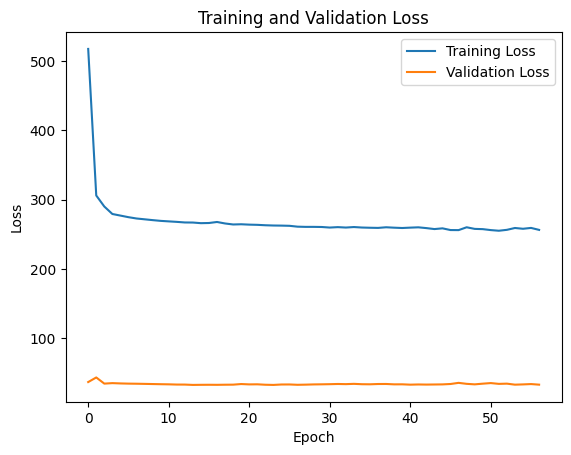

Model saved to models/gcn_3l_oasis.pth
Average Time per Epoch: 0.13s
Average CPU Usage: 29.44%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.21%

Total Training Time: 7.41s
Max CPU Usage: 52.15%
Max Memory Usage: 3.25GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%


In [16]:
set_seed(42)
gcn3_oasis = GCN3Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn3_oasis)
print(f"Total number of trainable parameters: {(gcn3_oasis.count_parameters())*2}\n")
single_train(gcn3_oasis, oasis_train_loader, oasis_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_3l_oasis.pth')

In [24]:
gcn3_oasis = GCN3Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
gcn3_oasis.load_state_dict(torch.load('models/gcn_3l_oasis.pth'))
single_test(gcn3_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcn3_oasis.to(device), oasis_test_loader)

Accuracy: 0.3478
Average Sensitivity (Recall): 0.3548
Average Specificity: 0.6734

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 6.26%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### EMCI-AD

GCN3Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 2500

Epoch 1, Train Loss: 450.75278890132904, Val Loss: 14.311256408691406
Time: 0.05s, CPU: 9.00%, Memory: 4.02GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 105.90197956562042, Val Loss: 8.120960235595703
Time: 0.05s, CPU: 13.25%, Memory: 4.02GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 69.80377161502838, Val Loss: 7.715306103229523
Time: 0.05s, CPU: 13.00%, Memory: 4.02GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 4, Train Loss: 67.32264184951782, Val Loss: 7.715738773345947
Time: 0.05s, CPU: 6.60%, Memory: 4.02GB, GPU: 0.02GB, GPU Util: 3.00%
Epoch 5, Train Loss: 66.64974462985992, Val Loss: 7.739627957344055
Time: 0.05s, CPU: 12.15%, Memory: 4.02GB, GPU: 0.02GB, GPU Util: 6.00%
Epoch 6, Train Loss: 66.74803066253662, Val Loss: 7.792609333992004
Time: 0.05s, CPU: 5.55%, Memory: 4.02GB, GPU: 0

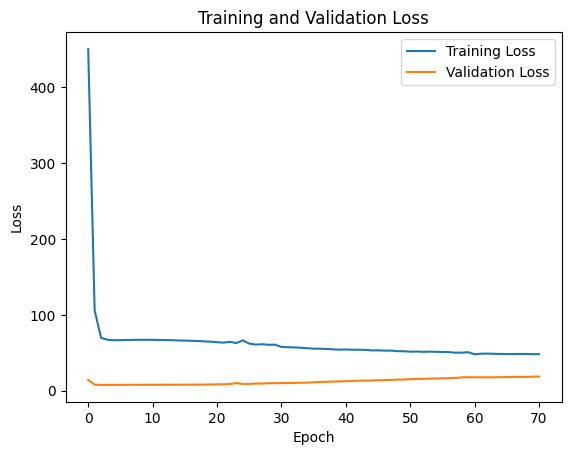

Model saved to models/gcn_3l_emci.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 15.07%
Average Memory Usage: 4.02GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.25%

Total Training Time: 3.61s
Max CPU Usage: 37.50%
Max Memory Usage: 4.02GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 6.00%


In [75]:
set_seed(42)
gcn3_emci = GCN3Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn3_emci)
print(f"Total number of trainable parameters: {(gcn3_emci.count_parameters())*2}\n")
single_train(gcn3_emci, emci_train_loader, emci_val_loader, lr=0.01, 
            num_epochs=500, step_size=30, patience=10,
            save_path='models/gcn_3l_emci.pth')

In [72]:
gcn3_emci = GCN3Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn3_emci.load_state_dict(torch.load('models/gcn_3l_emci.pth'))
single_test(gcn3_emci.to(device), emci_test_loader)
inference_performance(gcn3_emci.to(device), emci_test_loader)

Accuracy: 0.5185
Average Sensitivity (Recall): 0.2727
Average Specificity: 0.6875

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 7.97%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN3Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 2534

Epoch 1, Train Loss: 34589.55731201172, Val Loss: 1710.2940216064453
Time: 0.21s, CPU: 37.95%, Memory: 4.04GB, GPU: 0.13GB, GPU Util: 7.00%
Epoch 2, Train Loss: 13821.814079284668, Val Loss: 985.8358726501465
Time: 0.15s, CPU: 56.65%, Memory: 4.04GB, GPU: 0.17GB, GPU Util: 14.00%
Epoch 3, Train Loss: 7826.495590209961, Val Loss: 1015.368049621582
Time: 0.26s, CPU: 81.85%, Memory: 4.05GB, GPU: 0.17GB, GPU Util: 9.50%
Epoch 4, Train Loss: 6311.907264709473, Val Loss: 744.6855411529541
Time: 0.12s, CPU: 45.70%, Memory: 4.05GB, GPU: 0.17GB, GPU Util: 16.00%
Epoch 5, Train Loss: 4960.532165527344, Val Loss: 610.6257991790771
Time: 0.13s, CPU: 46.15%, Memory: 4.05GB, GPU: 0.17GB, GPU Util: 19.50%
Epoch 6, Train Loss: 4611.074895858765, Val Loss: 561.3608207702637
Time: 0.11s, CPU: 44.15%, Memory: 4.05GB, G

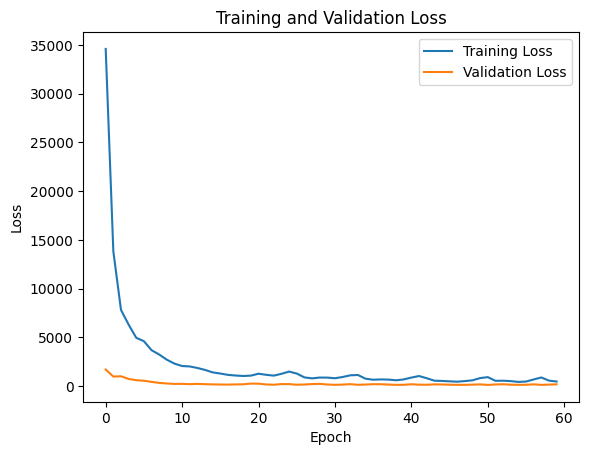

Model saved to models/gcn_3l_slim160.pth
Average Time per Epoch: 0.16s
Average CPU Usage: 48.14%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.17GB
Average GPU Utilization: 21.86%

Total Training Time: 9.81s
Max CPU Usage: 87.90%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.17GB
Max GPU Utilization: 28.00%


In [90]:
set_seed(42)
gcn3_slim160 = GCN3Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn3_slim160)
print(f"Total number of trainable parameters: {(gcn3_slim160.count_parameters())*2}\n")
single_train(gcn3_slim160, slim160_train_loader, slim160_val_loader, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_3l_slim160.pth', 
            binary_classification=False)

In [91]:
gcn3_slim160 = GCN3Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn3_slim160.load_state_dict(torch.load('models/gcn_3l_slim160.pth'))
single_test(gcn3_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn3_slim160.to(device), slim160_test_loader)

Accuracy: 0.3788
Average Sensitivity (Recall): 0.3981
Average Specificity: 0.6944

Average Inference Time per Batch: 0.0016s
Average CPU Usage: 24.37%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 2.00%


### GCN 4-Layer

#### MUTAG

GCN4Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 6472

Epoch 1, Train Loss: 90.79411739110947, Val Loss: 10.483548045158386
Time: 0.04s, CPU: 13.00%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 78.2390125989914, Val Loss: 10.257503092288971
Time: 0.03s, CPU: 10.55%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 73.14315176010132, Val Loss: 10.193261504173279
Time: 0.04s, CPU: 21.25%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 4, Tr

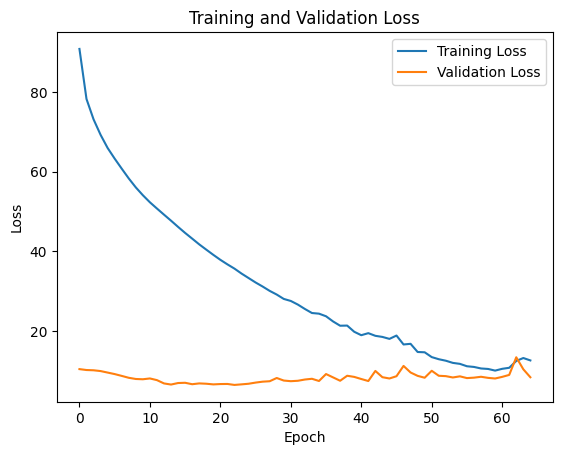

Model saved to models/gcn_4l_mutag.pth
Average Time per Epoch: 0.03s
Average CPU Usage: 18.33%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.22%

Total Training Time: 2.16s
Max CPU Usage: 40.85%
Max Memory Usage: 3.14GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%


In [19]:
set_seed(42)
gcn4_mutag = GCN4Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn4_mutag)
print(f"Total number of trainable parameters: {(gcn4_mutag.count_parameters())*2}\n")
single_train(gcn4_mutag, mutag_train_loader, mutag_val_loader, lr=0.001, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_mutag.pth')

In [20]:
gcn4_mutag = GCN4Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn4_mutag.load_state_dict(torch.load('models/gcn_4l_mutag.pth'))
single_test(gcn4_mutag.to(device), mutag_test_loader)
inference_performance(gcn4_mutag.to(device), mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0013s
Average CPU Usage: 0.85%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### PROTEINS

GCN4Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 27)
  (gcn4): GCN (27 -> 18)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 2542

Epoch 1, Train Loss: 553.3626368045807, Val Loss: 63.696690022945404
Time: 0.15s, CPU: 7.70%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 1.50%
Epoch 2, Train Loss: 542.0229476690292, Val Loss: 60.41180056333542
Time: 0.15s, CPU: 19.05%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 6.50%
Epoch 3, Train Loss: 529.8098745346069, Val Loss: 70.71288257837296
Time: 0.15s, CPU: 12.40%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 9.50%
Epoch 4, Train Loss: 533.343384206295, Val Loss: 58.398676455020905
Time: 0.16s, CPU: 13.60%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 9.50%
Epoch 5, Train Loss: 521.6216068863869, Val Loss: 58.863022327423096
Time: 0.15s, CPU: 11.15%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 10.00%
Epoch 6, Train Loss: 523.814596414566, Val Loss: 58.915641367435455
Time: 0.15s, CPU: 10.25

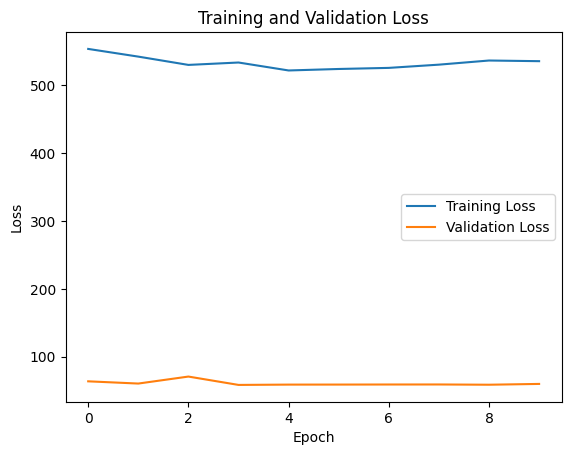

Model saved to models/gcn_4l_proteins.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 13.29%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 8.60%

Total Training Time: 1.52s
Max CPU Usage: 19.05%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.13GB
Max GPU Utilization: 10.00%


In [106]:
set_seed(42)
gcn4_proteins = GCN4Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn4_proteins)
print(f"Total number of trainable parameters: {(gcn4_proteins.count_parameters())*2}\n")
single_train(gcn4_proteins, proteins_train_loader, proteins_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_proteins.pth')

In [107]:
gcn4_proteins = GCN4Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
gcn4_proteins.load_state_dict(torch.load('models/gcn_4l_proteins.pth'))
single_test(gcn4_proteins.to(device), proteins_test_loader)
inference_performance(gcn4_proteins.to(device), proteins_test_loader)

Accuracy: 0.5919
Average Sensitivity (Recall): 0.4835
Average Specificity: 0.6667

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 19.69%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.14GB
Average GPU Utilization: 0.21%


#### DND

GCN4Layer(
  (gcn1): GCN (89 -> 178)
  (gcn2): GCN (178 -> 356)
  (gcn3): GCN (356 -> 534)
  (gcn4): GCN (534 -> 356)
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 923112

Epoch 1, Train Loss: 5969.492367684841, Val Loss: 63.70528185367584
Time: 2.43s, CPU: 27.25%, Memory: 4.05GB, GPU: 0.18GB, GPU Util: 45.50%
Epoch 2, Train Loss: 565.427326977253, Val Loss: 63.7872394323349
Time: 2.10s, CPU: 33.20%, Memory: 4.05GB, GPU: 0.29GB, GPU Util: 91.00%
Epoch 3, Train Loss: 621.1514084935188, Val Loss: 64.27519541978836
Time: 2.54s, CPU: 51.05%, Memory: 4.05GB, GPU: 0.29GB, GPU Util: 66.50%
Epoch 4, Train Loss: 572.0770880579948, Val Loss: 63.995557487010956
Time: 2.09s, CPU: 18.90%, Memory: 4.05GB, GPU: 0.29GB, GPU Util: 89.50%
Epoch 5, Train Loss: 560.9775601029396, Val Loss: 63.203907549381256
Time: 2.61s, CPU: 33.15%, Memory: 4.05GB, GPU: 0.29GB, GPU Util: 80.00%
Epoch 6, Train Loss: 552.7507624030113, Val Loss: 62.65052515268326
Time: 2

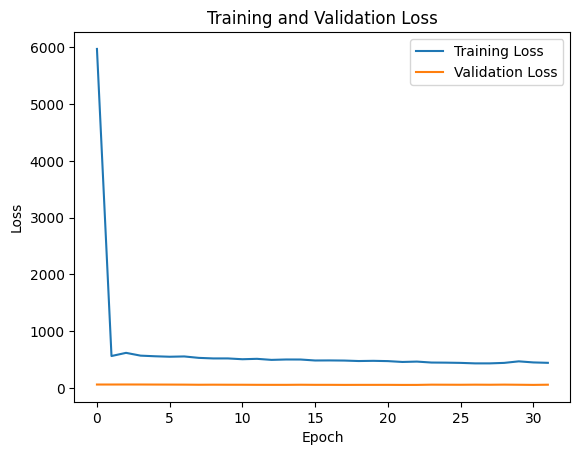

Model saved to models/gcn_4l_dnd.pth
Average Time per Epoch: 2.36s
Average CPU Usage: 32.97%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.29GB
Average GPU Utilization: 78.22%

Total Training Time: 75.44s
Max CPU Usage: 53.00%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.29GB
Max GPU Utilization: 93.00%


In [108]:
set_seed(42)
gcn4_dnd = GCN4Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn4_dnd)
print(f"Total number of trainable parameters: {(gcn4_dnd.count_parameters())*2}\n")
single_train(gcn4_dnd, dnd_train_loader, dnd_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_4l_dnd.pth')

In [109]:
gcn4_dnd = GCN4Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
gcn4_dnd.load_state_dict(torch.load('models/gcn_4l_dnd.pth'))
single_test(gcn4_dnd.to(device), dnd_test_loader)
inference_performance(gcn4_dnd.to(device), dnd_test_loader)

Accuracy: 0.6907
Average Sensitivity (Recall): 0.4737
Average Specificity: 0.8369

Average Inference Time per Batch: 0.0270s
Average CPU Usage: 49.23%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.37GB
Average GPU Utilization: 67.69%


#### ENZYM

GCN4Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 27)
  (gcn4): GCN (27 -> 18)
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 2694

Epoch 1, Train Loss: 784.5359859466553, Val Loss: 88.53850173950195
Time: 0.08s, CPU: 9.35%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 0.00%
Epoch 2, Train Loss: 778.5581645965576, Val Loss: 88.9166202545166
Time: 0.08s, CPU: 6.55%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 2.50%
Epoch 3, Train Loss: 771.0615882873535, Val Loss: 87.74656677246094
Time: 0.08s, CPU: 12.00%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 5.00%
Epoch 4, Train Loss: 766.2739238739014, Val Loss: 87.2216796875
Time: 0.08s, CPU: 12.25%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 7.00%
Epoch 5, Train Loss: 762.1963939666748, Val Loss: 86.88726997375488
Time: 0.08s, CPU: 11.10%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 9.00%
Epoch 6, Train Loss: 757.5379066467285, Val Loss: 86.18482780456543
Time: 0.10s, CPU: 8.35%, Memory:

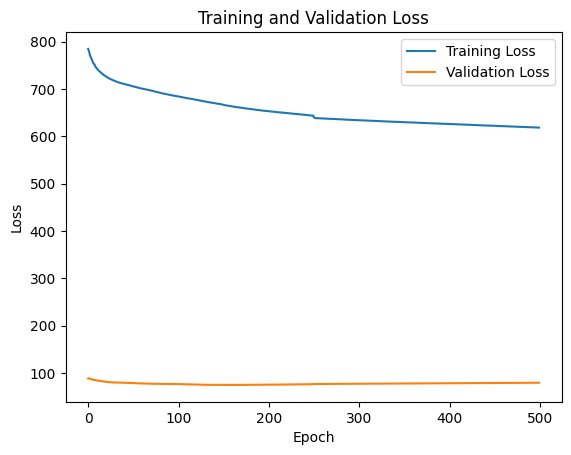

Model saved to models/gcn_4l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 20.31%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 7.71%

Total Training Time: 42.99s
Max CPU Usage: 54.75%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.13GB
Max GPU Utilization: 9.00%


In [110]:
set_seed(42)
gcn4_enzymes = GCN4Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn4_enzymes)
print(f"Total number of trainable parameters: {(gcn4_enzymes.count_parameters())*2}\n")
single_train(gcn4_enzymes, enzymes_train_loader, enzymes_val_loader, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_4l_enzymes.pth', 
            binary_classification=False)

In [111]:
gcn4_enzymes = GCN4Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
gcn4_enzymes.load_state_dict(torch.load('models/gcn_4l_enzymes.pth'))
single_test(gcn4_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcn4_enzymes.to(device), enzymes_test_loader)

Accuracy: 0.3167
Average Sensitivity (Recall): 0.3238
Average Specificity: 0.8635

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 8.54%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.14GB
Average GPU Utilization: 0.00%


#### OASIS

GCN4Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 7878

Epoch 1, Train Loss: 5152.338716983795, Val Loss: 37.38574552536011
Time: 0.12s, CPU: 14.05%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 500.3347486257553, Val Loss: 41.82014513015747
Time: 0.15s, CPU: 11.95%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 3, Train Loss: 332.07914412021637, Val Loss: 40.88445568084717
Time: 0.13s, CPU: 10.95%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 305.2053815126419, Val Loss: 33.70637607574463
Time: 0.13s, CPU: 11.50%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 5, Train Loss: 274.09312665462494, Val Loss: 32.67255210876465
Time: 0.12s, CPU: 10.35%, Memory: 3.25GB, GPU: 0.02GB, GPU Util: 7.50%
Epoch 6, Train Loss: 273.8710278272629, Val Loss: 31.101969242095947
Time: 0.12s, CPU: 17

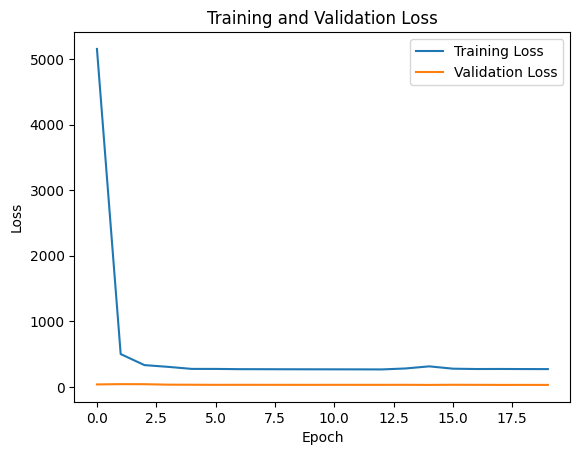

Model saved to models/gcn_4l_oasis.pth
Average Time per Epoch: 0.12s
Average CPU Usage: 18.65%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.05%

Total Training Time: 2.49s
Max CPU Usage: 36.65%
Max Memory Usage: 3.25GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.50%


In [18]:
set_seed(42)
gcn4_oasis = GCN4Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn4_oasis)
print(f"Total number of trainable parameters: {(gcn4_oasis.count_parameters())*2}\n")
single_train(gcn4_oasis, oasis_train_loader, oasis_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_4l_oasis.pth')

In [21]:
gcn4_oasis = GCN4Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
gcn4_oasis.load_state_dict(torch.load('models/gcn_4l_oasis.pth'))
single_test(gcn4_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcn4_oasis.to(device), oasis_test_loader)

Accuracy: 0.2609
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 12.85%
Average Memory Usage: 3.25GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 1.00%


#### EMCI-AD

GCN4Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 7812

Epoch 1, Train Loss: 3266.501020550728, Val Loss: 43.804958783090115
Time: 0.06s, CPU: 21.75%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 0.00%
Epoch 2, Train Loss: 501.030300617218, Val Loss: 30.207862377166748
Time: 0.06s, CPU: 38.25%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 0.00%
Epoch 3, Train Loss: 152.48078191280365, Val Loss: 10.61532723903656
Time: 0.06s, CPU: 41.60%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 2.00%
Epoch 4, Train Loss: 73.5060065984726, Val Loss: 8.841200143098831
Time: 0.05s, CPU: 35.40%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 4.00%
Epoch 5, Train Loss: 70.82279849052429, Val Loss: 8.115488469600677
Time: 0.05s, CPU: 40.50%, Memory: 4.05GB, GPU: 0.13GB, GPU Util: 4.00%
Epoch 6, Train Loss: 68.39312422275543, Val Loss: 7.931341648101807
Time: 0.05s, CPU: 33.8

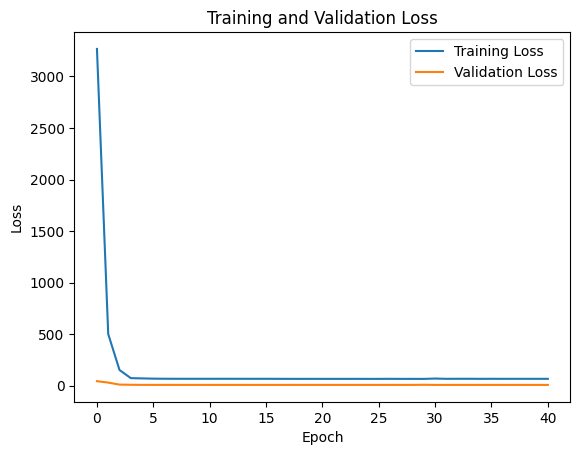

Model saved to models/gcn_4l_emci.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 26.83%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 6.05%

Total Training Time: 2.05s
Max CPU Usage: 52.95%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.13GB
Max GPU Utilization: 8.00%


In [114]:
set_seed(42)
gcn4_emci = GCN4Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn4_emci)
print(f"Total number of trainable parameters: {(gcn4_emci.count_parameters())*2}\n")
single_train(gcn4_emci, emci_train_loader, emci_val_loader, lr=0.01, 
            num_epochs=500, step_size=30, patience=10,
            save_path='models/gcn_4l_emci.pth')

In [115]:
gcn4_emci = GCN4Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn4_emci.load_state_dict(torch.load('models/gcn_4l_emci.pth'))
single_test(gcn4_emci.to(device), emci_test_loader)
inference_performance(gcn4_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 0.97%
Average Memory Usage: 4.05GB
Average GPU Usage: 0.13GB
Average GPU Utilization: 0.00%


#### SLIM160

GCN4Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 7878

Epoch 1, Train Loss: 796482.8283691406, Val Loss: 49390.50146484375
Time: 0.15s, CPU: 25.80%, Memory: 4.05GB, GPU: 0.14GB, GPU Util: 4.50%
Epoch 2, Train Loss: 305602.0480957031, Val Loss: 25117.287231445312
Time: 0.12s, CPU: 42.90%, Memory: 4.05GB, GPU: 0.18GB, GPU Util: 9.00%
Epoch 3, Train Loss: 145565.50247192383, Val Loss: 9452.42578125
Time: 0.12s, CPU: 43.10%, Memory: 4.05GB, GPU: 0.18GB, GPU Util: 34.00%
Epoch 4, Train Loss: 88685.24111938477, Val Loss: 6606.60905456543
Time: 0.48s, CPU: 26.15%, Memory: 4.05GB, GPU: 0.12GB, GPU Util: 22.50%
Epoch 5, Train Loss: 68552.39378356934, Val Loss: 8318.525482177734
Time: 0.15s, CPU: 42.00%, Memory: 4.01GB, GPU: 0.07GB, GPU Util: 11.00%
Epoch 6, Train Loss: 55997.098445892334, Val Loss: 8094.424163818359
Time: 0.12s, CPU: 39.2

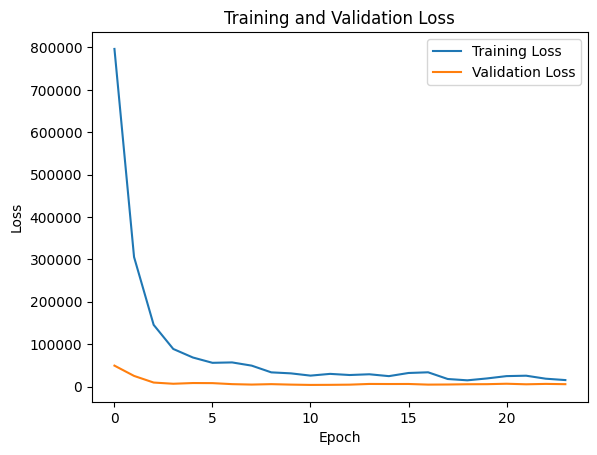

Model saved to models/gcn_4l_slim160.pth
Average Time per Epoch: 0.15s
Average CPU Usage: 44.67%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.08GB
Average GPU Utilization: 25.92%

Total Training Time: 3.64s
Max CPU Usage: 76.75%
Max Memory Usage: 4.05GB
Max GPU Usage: 0.18GB
Max GPU Utilization: 34.00%


In [116]:
set_seed(42)
gcn4_slim160 = GCN4Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn4_slim160)
print(f"Total number of trainable parameters: {(gcn4_slim160.count_parameters())*2}\n")
single_train(gcn4_slim160, slim160_train_loader, slim160_val_loader, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_4l_slim160.pth', 
            binary_classification=False)

In [117]:
gcn4_slim160 = GCN4Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn4_slim160.load_state_dict(torch.load('models/gcn_4l_slim160.pth'))
single_test(gcn4_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn4_slim160.to(device), slim160_test_loader)

Accuracy: 0.3939
Average Sensitivity (Recall): 0.4213
Average Specificity: 0.7123

Average Inference Time per Batch: 0.0023s
Average CPU Usage: 23.68%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 4.00%


### GCN 5-Layer

#### MUTAG

GCN5Layer(
  (gcn1): GCN (7 -> 14)
  (bn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn2): GCN (14 -> 28)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn3): GCN (28 -> 42)
  (bn3): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn4): GCN (42 -> 28)
  (bn4): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn5): GCN (28 -> 14)
  (bn5): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 7284

Epoch 1, Train Loss: 75.4940470457077, Val Loss: 13.146620392799377
Time: 0.03s, CPU: 22.80%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 58.89496651291847, Val Loss: 10.286677479743958
Time: 0.03s, CPU: 22.30%, Memory: 3.14GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 3, Train Loss: 52.9115188121795

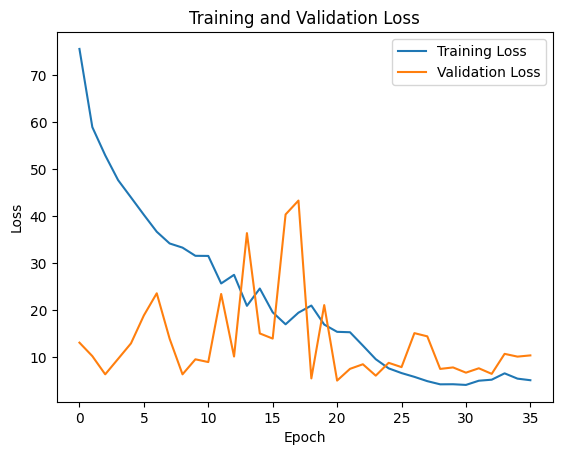

Model saved to models/gcn_5l_mutag.pth
Average Time per Epoch: 0.04s
Average CPU Usage: 25.87%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.51%

Total Training Time: 1.30s
Max CPU Usage: 41.65%
Max Memory Usage: 3.14GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 8.00%


In [17]:
set_seed(42)
gcn5_mutag = GCN5Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
print(gcn5_mutag)
print(f"Total number of trainable parameters: {(gcn5_mutag.count_parameters())*2}\n")
single_train(gcn5_mutag, mutag_train_loader, mutag_val_loader, lr=0.01, 
            num_epochs=500, step_size=20, save_path='models/gcn_5l_mutag.pth')

In [18]:
gcn5_mutag = GCN5Layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes)
gcn5_mutag.load_state_dict(torch.load('models/gcn_5l_mutag.pth'))
single_test(gcn5_mutag.to(device), mutag_test_loader)
inference_performance(gcn5_mutag.to(device), mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 3.42%
Average Memory Usage: 3.14GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### PROTEINS

GCN5Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 27)
  (gcn4): GCN (27 -> 18)
  (gcn5): GCN (18 -> 9)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 2848

Epoch 1, Train Loss: 559.6238840818405, Val Loss: 58.33554428815842
Time: 0.17s, CPU: 17.50%, Memory: 4.04GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 528.7451416254044, Val Loss: 56.3127019405365
Time: 0.17s, CPU: 23.95%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 10.00%
Epoch 3, Train Loss: 530.511073410511, Val Loss: 57.895185112953186
Time: 0.17s, CPU: 27.85%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 10.00%
Epoch 4, Train Loss: 518.4994850158691, Val Loss: 56.33201992511749
Time: 0.17s, CPU: 36.50%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 10.50%
Epoch 5, Train Loss: 503.5767448544502, Val Loss: 55.70300340652466
Time: 0.18s, CPU: 30.30%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 10.50%
Epoch 6, Train Loss: 501.9609678387642, Val Loss: 56.25245028734207

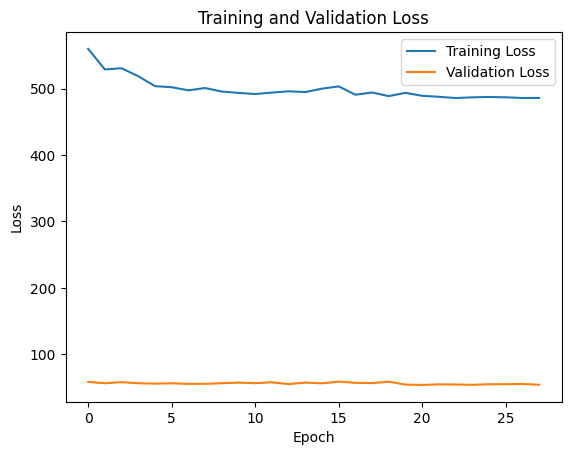

Model saved to models/gcn_5l_proteins.pth
Average Time per Epoch: 0.17s
Average CPU Usage: 17.71%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 9.93%

Total Training Time: 4.70s
Max CPU Usage: 36.85%
Max Memory Usage: 4.04GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 12.00%


In [121]:
set_seed(42)
gcn5_proteins = GCN5Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
print(gcn5_proteins)
print(f"Total number of trainable parameters: {(gcn5_proteins.count_parameters())*2}\n")
single_train(gcn5_proteins, proteins_train_loader, proteins_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_5l_proteins.pth')

In [122]:
gcn5_proteins = GCN5Layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes)
gcn5_proteins.load_state_dict(torch.load('models/gcn_5l_proteins.pth'))
single_test(gcn5_proteins.to(device), proteins_test_loader)
inference_performance(gcn5_proteins.to(device), proteins_test_loader)

Accuracy: 0.6323
Average Sensitivity (Recall): 0.4725
Average Specificity: 0.7424

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 11.06%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 0.00%


#### DND

GCN5Layer(
  (gcn1): GCN (89 -> 178)
  (gcn2): GCN (178 -> 356)
  (gcn3): GCN (356 -> 534)
  (gcn4): GCN (534 -> 356)
  (gcn5): GCN (356 -> 178)
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 1049492

Epoch 1, Train Loss: 39002.01570415497, Val Loss: 64.71470320224762
Time: 2.60s, CPU: 14.40%, Memory: 4.04GB, GPU: 0.07GB, GPU Util: 46.50%
Epoch 2, Train Loss: 575.0762156844139, Val Loss: 64.60330784320831
Time: 2.40s, CPU: 17.10%, Memory: 4.04GB, GPU: 0.19GB, GPU Util: 74.50%
Epoch 3, Train Loss: 569.4223286509514, Val Loss: 64.48830837011337
Time: 2.53s, CPU: 20.90%, Memory: 4.04GB, GPU: 0.19GB, GPU Util: 86.00%
Epoch 4, Train Loss: 569.9728470444679, Val Loss: 64.39815527200699
Time: 2.46s, CPU: 23.90%, Memory: 4.04GB, GPU: 0.19GB, GPU Util: 77.00%
Epoch 5, Train Loss: 565.2511612176895, Val Loss: 65.7596971988678
Time: 2.53s, CPU: 19.20%, Memory: 4.04GB, GPU: 0.19GB, GPU Util: 85.00%
Epoch 6, Train Loss: 571.3070247173309, Val Loss

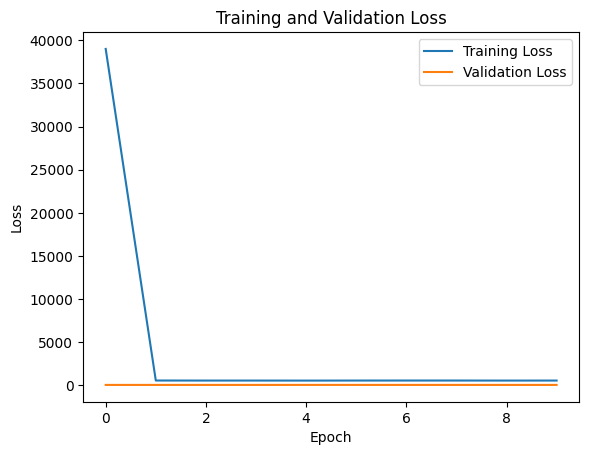

Model saved to models/gcn_5l_dnd.pth
Average Time per Epoch: 2.61s
Average CPU Usage: 25.10%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.17GB
Average GPU Utilization: 74.50%

Total Training Time: 26.06s
Max CPU Usage: 47.35%
Max Memory Usage: 4.04GB
Max GPU Usage: 0.19GB
Max GPU Utilization: 86.00%


In [123]:
set_seed(42)
gcn5_dnd = GCN5Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
print(gcn5_dnd)
print(f"Total number of trainable parameters: {(gcn5_dnd.count_parameters())*2}\n")
single_train(gcn5_dnd, dnd_train_loader, dnd_val_loader, lr=0.01, 
            num_epochs=500, step_size=500, save_path='models/gcn_5l_dnd.pth')

In [124]:
gcn5_dnd = GCN5Layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes)
gcn5_dnd.load_state_dict(torch.load('models/gcn_5l_dnd.pth'))
single_test(gcn5_dnd.to(device), dnd_test_loader)
inference_performance(gcn5_dnd.to(device), dnd_test_loader)

Accuracy: 0.6017
Average Sensitivity (Recall): 0.1789
Average Specificity: 0.8865

Average Inference Time per Batch: 0.0321s
Average CPU Usage: 51.96%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.26GB
Average GPU Utilization: 58.56%


#### ENZYM

GCN5Layer(
  (gcn1): GCN (3 -> 9)
  (gcn2): GCN (9 -> 18)
  (gcn3): GCN (18 -> 27)
  (gcn4): GCN (27 -> 18)
  (gcn5): GCN (18 -> 9)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 2928

Epoch 1, Train Loss: 1046.8257484436035, Val Loss: 96.7481803894043
Time: 0.10s, CPU: 12.05%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 0.00%
Epoch 2, Train Loss: 861.1622772216797, Val Loss: 86.48391723632812
Time: 0.10s, CPU: 11.20%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 4.00%
Epoch 3, Train Loss: 805.8550052642822, Val Loss: 84.50221633911133
Time: 0.10s, CPU: 17.15%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 8.00%
Epoch 4, Train Loss: 791.4318199157715, Val Loss: 84.37108612060547
Time: 0.10s, CPU: 11.60%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 8.00%
Epoch 5, Train Loss: 785.9702949523926, Val Loss: 84.85362434387207
Time: 0.10s, CPU: 12.85%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 8.00%
Epoch 6, Train Loss: 779.4515609741211, Val Loss: 84.64962959289551
Ti

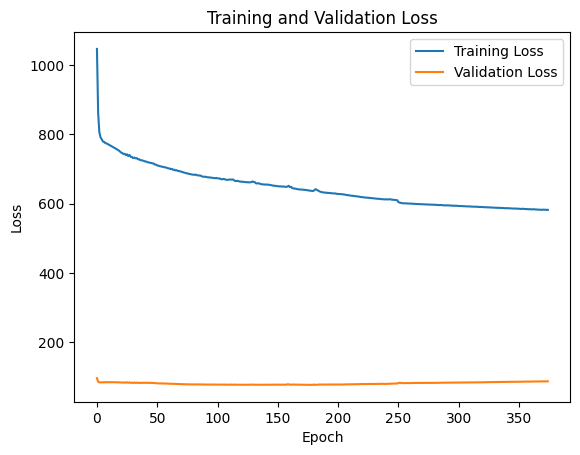

Model saved to models/gcn_5l_enzymes.pth
Average Time per Epoch: 0.09s
Average CPU Usage: 20.18%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 8.36%

Total Training Time: 34.26s
Max CPU Usage: 47.65%
Max Memory Usage: 4.04GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 10.00%


In [125]:
set_seed(42)
gcn5_enzymes = GCN5Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
print(gcn5_enzymes)
print(f"Total number of trainable parameters: {(gcn5_enzymes.count_parameters())*2}\n")
single_train(gcn5_enzymes, enzymes_train_loader, enzymes_val_loader, lr=0.001, 
            num_epochs=500, step_size=250, save_path='models/gcn_5l_enzymes.pth', 
            binary_classification=False)

In [126]:
gcn5_enzymes = GCN5Layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes)
gcn5_enzymes.load_state_dict(torch.load('models/gcn_5l_enzymes.pth'))
single_test(gcn5_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcn5_enzymes.to(device), enzymes_test_loader)

Accuracy: 0.3833
Average Sensitivity (Recall): 0.3980
Average Specificity: 0.8774

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 9.19%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 2.00%


#### OASIS

GCN5Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (gcn5): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 8838

Epoch 1, Train Loss: 46421.4450776577, Val Loss: 32.342729806900024
Time: 0.14s, CPU: 15.20%, Memory: 3.26GB, GPU: 0.02GB, GPU Util: 0.00%
Epoch 2, Train Loss: 273.6000370979309, Val Loss: 31.835054397583008
Time: 0.14s, CPU: 16.20%, Memory: 3.26GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 271.3376969099045, Val Loss: 31.374017000198364
Time: 0.14s, CPU: 13.20%, Memory: 3.26GB, GPU: 0.02GB, GPU Util: 7.50%
Epoch 4, Train Loss: 270.0224447250366, Val Loss: 31.08069372177124
Time: 0.13s, CPU: 9.85%, Memory: 3.26GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 5, Train Loss: 269.444819688797, Val Loss: 30.907620668411255
Time: 0.12s, CPU: 19.15%, Memory: 3.26GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 6, Train Loss: 269.22966480255127, Val Loss: 30.80745124816

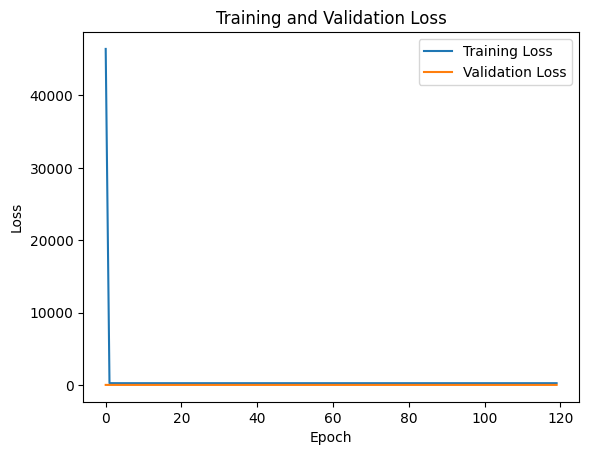

Model saved to models/gcn_5l_oasis.pth
Average Time per Epoch: 0.13s
Average CPU Usage: 14.78%
Average Memory Usage: 3.26GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.97%

Total Training Time: 15.46s
Max CPU Usage: 36.15%
Max Memory Usage: 3.26GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 9.00%


In [26]:
set_seed(42)
gcn5_oasis = GCN5Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
print(gcn5_oasis)
print(f"Total number of trainable parameters: {(gcn5_oasis.count_parameters())*2}\n")
single_train(gcn5_oasis, oasis_train_loader, oasis_val_loader, lr=0.01, 
            num_epochs=500, step_size=100, save_path='models/gcn_5l_oasis.pth')

In [28]:
gcn5_oasis = GCN5Layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes)
gcn5_oasis.load_state_dict(torch.load('models/gcn_5l_oasis.pth'))
single_test(gcn5_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcn5_oasis.to(device), oasis_test_loader)

Accuracy: 0.2609
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 18.84%
Average Memory Usage: 3.26GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### EMCI-AD

GCN5Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (gcn5): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 8804

Epoch 1, Train Loss: 27783.96192932129, Val Loss: 1146.3774108886719
Time: 0.06s, CPU: 28.20%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 0.00%
Epoch 2, Train Loss: 7444.533542633057, Val Loss: 222.30716705322266
Time: 0.05s, CPU: 33.65%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 0.00%
Epoch 3, Train Loss: 908.4213528633118, Val Loss: 120.46480178833008
Time: 0.06s, CPU: 23.05%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 2.50%
Epoch 4, Train Loss: 505.47454476356506, Val Loss: 14.457050636410713
Time: 0.05s, CPU: 25.60%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 5.00%
Epoch 5, Train Loss: 121.80503284931183, Val Loss: 8.421084523200989
Time: 0.05s, CPU: 25.85%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 5.00%
Epoch 6, Train Loss: 141.2911536693573, Val Loss: 7.76840126

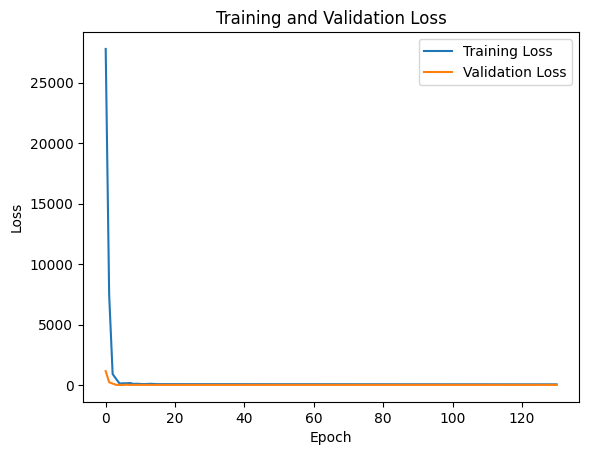

Model saved to models/gcn_5l_emci.pth
Average Time per Epoch: 0.06s
Average CPU Usage: 23.77%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 6.60%

Total Training Time: 7.34s
Max CPU Usage: 54.05%
Max Memory Usage: 4.04GB
Max GPU Usage: 0.03GB
Max GPU Utilization: 8.00%


In [129]:
set_seed(42)
gcn5_emci = GCN5Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
print(gcn5_emci)
print(f"Total number of trainable parameters: {(gcn5_emci.count_parameters())*2}\n")
single_train(gcn5_emci, emci_train_loader, emci_val_loader, lr=0.01, 
            num_epochs=500, step_size=30, patience=10,
            save_path='models/gcn_5l_emci.pth')

In [130]:
gcn5_emci = GCN5Layer(emci_num_features, 2*emci_num_features, emci_num_classes)
gcn5_emci.load_state_dict(torch.load('models/gcn_5l_emci.pth'))
single_test(gcn5_emci.to(device), emci_test_loader)
inference_performance(gcn5_emci.to(device), emci_test_loader)

Accuracy: 0.4444
Average Sensitivity (Recall): 0.3636
Average Specificity: 0.5000

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 22.58%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 0.33%


#### SLIM160

GCN5Layer(
  (gcn1): GCN (8 -> 16)
  (gcn2): GCN (16 -> 32)
  (gcn3): GCN (32 -> 48)
  (gcn4): GCN (48 -> 32)
  (gcn5): GCN (32 -> 16)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 8838

Epoch 1, Train Loss: 69603493.59375, Val Loss: 2521873.40625
Time: 1.04s, CPU: 52.10%, Memory: 4.04GB, GPU: 0.03GB, GPU Util: 1.50%
Epoch 2, Train Loss: 13742449.21875, Val Loss: 738312.416015625
Time: 0.14s, CPU: 54.65%, Memory: 4.04GB, GPU: 0.07GB, GPU Util: 3.00%
Epoch 3, Train Loss: 4557533.009765625, Val Loss: 233961.275390625
Time: 0.13s, CPU: 49.00%, Memory: 4.04GB, GPU: 0.07GB, GPU Util: 29.00%
Epoch 4, Train Loss: 2770273.490234375, Val Loss: 212441.7216796875
Time: 0.13s, CPU: 50.90%, Memory: 4.04GB, GPU: 0.07GB, GPU Util: 31.50%
Epoch 5, Train Loss: 1591333.8662109375, Val Loss: 186127.55859375
Time: 0.23s, CPU: 56.35%, Memory: 4.04GB, GPU: 0.07GB, GPU Util: 26.50%
Epoch 6, Train Loss: 1145085.1025390625, Val Loss: 124145.3935546875
Time: 0

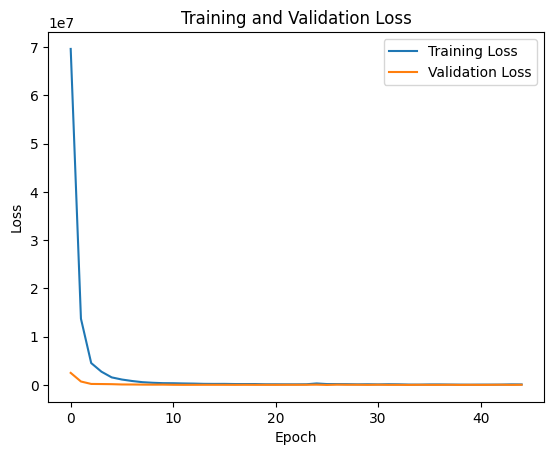

Model saved to models/gcn_5l_slim160.pth
Average Time per Epoch: 0.30s
Average CPU Usage: 50.86%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.07GB
Average GPU Utilization: 25.51%

Total Training Time: 13.29s
Max CPU Usage: 89.20%
Max Memory Usage: 4.04GB
Max GPU Usage: 0.07GB
Max GPU Utilization: 37.00%


In [131]:
set_seed(42)
gcn5_slim160 = GCN5Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
print(gcn5_slim160)
print(f"Total number of trainable parameters: {(gcn5_slim160.count_parameters())*2}\n")
single_train(gcn5_slim160, slim160_train_loader, slim160_val_loader, lr=0.001, 
            num_epochs=500, step_size=100, save_path='models/gcn_5l_slim160.pth', 
            binary_classification=False)

In [132]:
gcn5_slim160 = GCN5Layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes)
gcn5_slim160.load_state_dict(torch.load('models/gcn_5l_slim160.pth'))
single_test(gcn5_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcn5_slim160.to(device), slim160_test_loader)

Accuracy: 0.3030
Average Sensitivity (Recall): 0.2824
Average Specificity: 0.6399

Average Inference Time per Batch: 0.0027s
Average CPU Usage: 26.07%
Average Memory Usage: 4.04GB
Average GPU Usage: 0.10GB
Average GPU Utilization: 5.00%


## GCESN

### GCESN 1-Layer

#### MUTAG

In [ ]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_mutag)
print(f"Total number of trainable parameters: {gcesn_mutag.count_parameters()}\n")

multi_train_test(gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_mutag.pth')


Accuracy: 0.9737
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0005s
Average CPU Usage: 4.40%
Average Memory Usage: 0.10GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


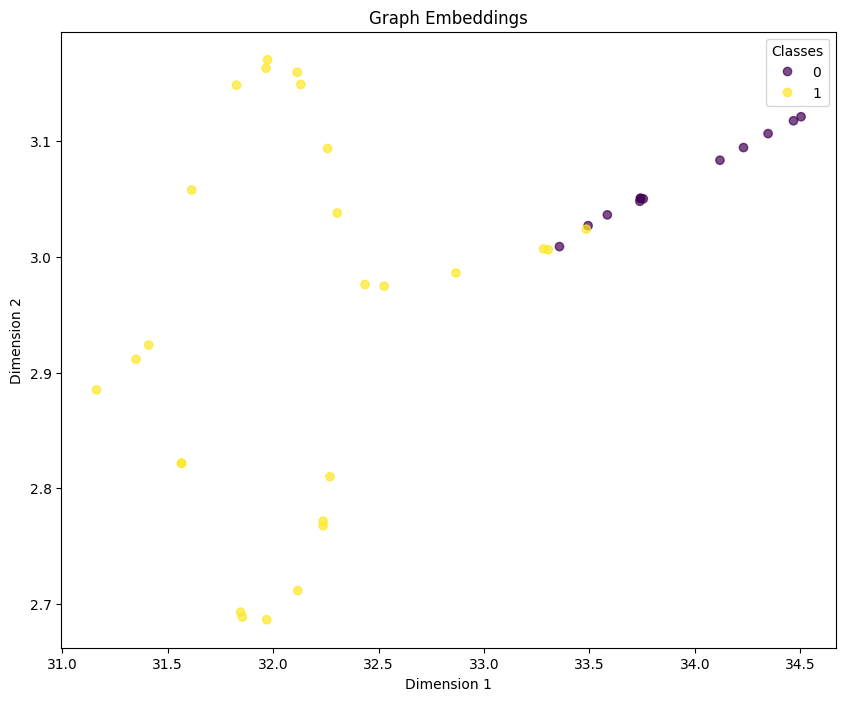

In [40]:
gcesn_mutag = GCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_mutag.load_state_dict(torch.load('models/best_gcesn_1l_mutag.pth'))
# for name, param in gcesn_mutag.named_parameters():
#     print(f'After loading - {name}: {param.data}')

single_test(gcesn_mutag.to(device), mutag_test_loader)
inference_performance(gcesn_mutag.to(device), mutag_test_loader)

#### PROTEINS

In [40]:
gcesn_proteins = GCESN_1layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_proteins)
print(f"Total number of trainable parameters: {gcesn_proteins.count_parameters()}\n")

multi_train_test(gcesn_proteins, proteins_train_loader, proteins_val_loader, proteins_test_loader,
                lr=0.01, num_epochs=500, patience=10, step_size=50, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_proteins.pth')


GCESN_1layer(
  (fc1): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 128


Run 1/5 -> Loss: 487.51401, Total Training Time: 2.63s
  Accuracy: 0.6413, Sensitivity: 0.1758, Specificity: 0.9621
  Best model saved to models/best_gcesn_1l_proteins.pth with accuracy 0.6413 from run 1

Run 2/5 -> Loss: 497.74017, Total Training Time: 1.18s
  Accuracy: 0.6278, Sensitivity: 0.2527, Specificity: 0.8864

Run 3/5 -> Loss: 474.76538, Total Training Time: 4.81s
  Accuracy: 0.6637, Sensitivity: 0.3736, Specificity: 0.8636
  Best model saved to models/best_gcesn_1l_proteins.pth with accuracy 0.6637 from run 3

Run 4/5 -> Loss: 476.42326, Total Training Time: 11.67s
  Accuracy: 0.6682, Sensitivity: 0.4396, Specificity: 0.8258
  Best model saved to models/best_gcesn_1l_proteins.pth with accuracy 0.6682 from run 4

Run 5

Accuracy: 0.6726
Average Sensitivity (Recall): 0.3956
Average Specificity: 0.8636

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 6.18%
Average Memory Usage: 4.59GB
Average GPU Usage: 0.03GB
Average GPU Utilization: 0.00%


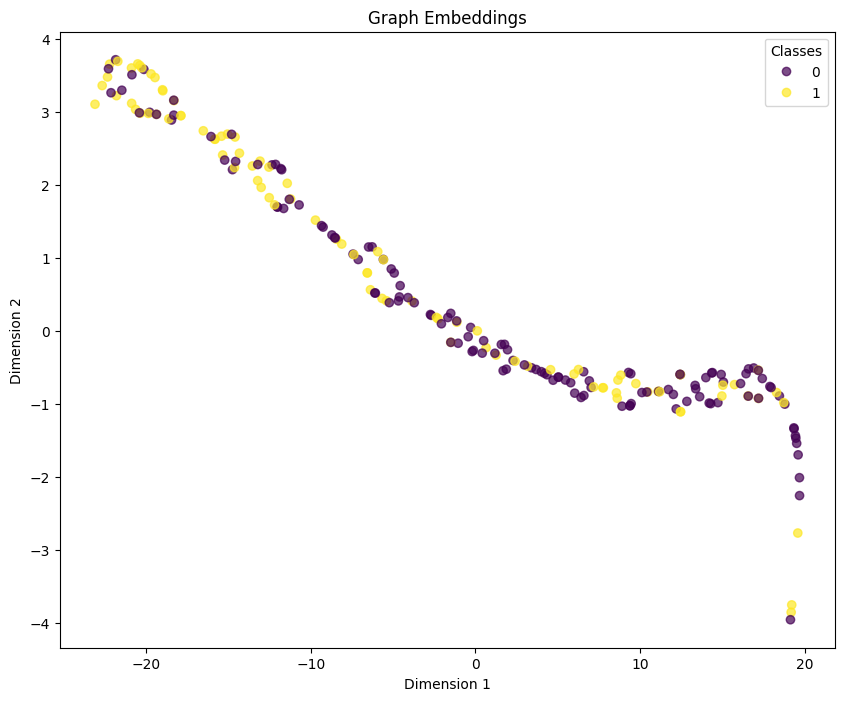

In [41]:
gcesn_proteins = GCESN_1layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_proteins.initialize_weights()
gcesn_proteins.load_state_dict(torch.load('models/best_gcesn_1l_proteins.pth'))
single_test(gcesn_proteins.to(device), proteins_test_loader)
inference_performance(gcesn_proteins.to(device), proteins_test_loader)

#### DND

In [24]:
gcesn_dnd = GCESN_1layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd)
print(f"Total number of trainable parameters: {gcesn_dnd.count_parameters()}\n")

multi_train_test(gcesn_dnd, dnd_train_loader, dnd_val_loader, dnd_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_dnd.pth')


GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=178, out_features=178, bias=True)
  )
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 32220


Run 1/5 -> Loss: 462.98536, Total Training Time: 44.68s
  Accuracy: 0.7331, Sensitivity: 0.5579, Specificity: 0.8511

Run 2/5 -> Loss: 472.80923, Total Training Time: 62.14s
  Accuracy: 0.7288, Sensitivity: 0.6421, Specificity: 0.7872

Run 3/5 -> Loss: 475.01598, Total Training Time: 57.35s
  Accuracy: 0.7161, Sensitivity: 0.6737, Specificity: 0.7447

Run 4/5 -> Loss: 467.70568, Total Training Time: 47.92s
  Accuracy: 0.7585, Sensitivity: 0.6105, Specificity: 0.8582

Run 5/5 -> Loss: 477.74203, Total Training Time: 45.34s
  Accuracy: 0.7415, Sensitivity: 0.6947, Specificity: 0.7730
Best model saved to models/best_gcesn_1l_dnd.pth with accuracy 0.7585
Overall Results:
  Avg Accuracy: 0.7356 ± 0.01, Avg Sensitivity: 0.6358 ± 0.05, Avg Specificity: 0.8028 ± 0.04
  Max Acc

In [12]:
gcesn_dnd = GCESN_1layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=6)
gcesn_dnd.initialize_weights()
gcesn_dnd.load_state_dict(torch.load('models/best_gcesn_1l_dnd.pth'))
single_test(gcesn_dnd.to(device), dnd_test_loader)
inference_performance(gcesn_dnd.to(device), dnd_test_loader)

Accuracy: 0.4025
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0128s
Average CPU Usage: 32.50%
Average Memory Usage: 3.94GB
Average GPU Usage: 0.25GB
Average GPU Utilization: 39.00%


#### ENZYM

In [19]:
gcesn_enzymes = GCESN_1layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_enzymes)
print(f"Total number of trainable parameters: {gcesn_enzymes.count_parameters()}\n")

multi_train_test(gcesn_enzymes, enzymes_train_loader, enzymes_val_loader, enzymes_test_loader,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_1l_enzymes.pth')


GCESN_1layer(
  (fc1): Linear(in_features=9, out_features=9, bias=True)
  (bn): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 168


Run 1/5 -> Loss: 648.20205, Total Training Time: 8.03s
  Accuracy: 0.2917, Sensitivity: 0.2928, Specificity: 0.8581

Run 2/5 -> Loss: 709.30482, Total Training Time: 7.94s
  Accuracy: 0.2417, Sensitivity: 0.2445, Specificity: 0.8489

Run 3/5 -> Loss: 684.74668, Total Training Time: 7.83s
  Accuracy: 0.2500, Sensitivity: 0.2544, Specificity: 0.8502

Run 4/5 -> Loss: 693.50831, Total Training Time: 7.69s
  Accuracy: 0.2500, Sensitivity: 0.2493, Specificity: 0.8503

Run 5/5 -> Loss: 684.26288, Total Training Time: 8.20s
  Accuracy: 0.2333, Sensitivity: 0.2422, Specificity: 0.8462
Best model saved to models/best_gcesn_1l_enzymes.pth with accuracy 0.2917 from run 5
Overall Results:
  Avg Accuracy: 0.2533 ± 0.02, Avg Sensitivity: 0.25

In [14]:
gcesn_enzymes = GCESN_1layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_enzymes.initialize_weights()
gcesn_enzymes.load_state_dict(torch.load('models/best_gcesn_1l_enzymes.pth'))
single_test(gcesn_enzymes.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcesn_enzymes.to(device), enzymes_test_loader)

Accuracy: 0.1500
Average Sensitivity (Recall): 0.1754
Average Specificity: 0.8349

Average Inference Time per Batch: 0.0007s
Average CPU Usage: 22.80%
Average Memory Usage: 3.94GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.00%


#### OASIS

In [21]:
gcesn_oasis = GCESN_1layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_oasis)
print(f"Total number of trainable parameters: {gcesn_oasis.count_parameters()}\n")

multi_train_test(gcesn_oasis, oasis_train_loader, oasis_val_loader, oasis_test_loader,
                lr=0.01, num_epochs=500, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_1l_oasis.pth')


GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 323


Run 1/5 -> Loss: 261.48955, Total Training Time: 2.10s
  Accuracy: 0.2029, Sensitivity: 0.2178, Specificity: 0.6119

Run 2/5 -> Loss: 267.24195, Total Training Time: 1.32s
  Accuracy: 0.3478, Sensitivity: 0.3823, Specificity: 0.6878

Run 3/5 -> Loss: 270.60981, Total Training Time: 1.57s
  Accuracy: 0.3768, Sensitivity: 0.4146, Specificity: 0.7061

Run 4/5 -> Loss: 278.93208, Total Training Time: 0.90s
  Accuracy: 0.3333, Sensitivity: 0.3581, Specificity: 0.6801

Run 5/5 -> Loss: 263.04613, Total Training Time: 2.24s
  Accuracy: 0.2754, Sensitivity: 0.2839, Specificity: 0.6437
Best model saved to models/best_gcesn_1l_oasis.pth with accuracy 0.3768
Overall Results:
  Avg Accuracy: 0.3072 ± 0.06, Avg Sensitivity: 0.3313 ± 0.07, Avg Specificity: 0.6659 ± 0.03
  Max Accuracy: 0

In [16]:
gcesn_oasis = GCESN_1layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_oasis.initialize_weights()
gcesn_oasis.load_state_dict(torch.load('models/best_gcesn_1l_oasis.pth'))
single_test(gcesn_oasis.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcesn_oasis.to(device), oasis_test_loader)

Accuracy: 0.3623
Average Sensitivity (Recall): 0.3333
Average Specificity: 0.6667

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 19.24%
Average Memory Usage: 3.94GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 3.00%


#### EMCI-AD

In [23]:
gcesn_emci = GCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_emci)
print(f"Total number of trainable parameters: {gcesn_emci.count_parameters()}\n")

multi_train_test(gcesn_emci, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_1l_emci.pth')

GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 306


Run 1/5 -> Loss: 65.65547, Total Training Time: 0.87s
  Accuracy: 0.4444, Sensitivity: 0.4545, Specificity: 0.4375

Run 2/5 -> Loss: 66.54837, Total Training Time: 0.11s
  Accuracy: 0.4074, Sensitivity: 0.2727, Specificity: 0.5000

Run 3/5 -> Loss: 65.26823, Total Training Time: 6.85s
  Accuracy: 0.4074, Sensitivity: 0.5455, Specificity: 0.3125

Run 4/5 -> Loss: 65.85930, Total Training Time: 1.57s
  Accuracy: 0.4815, Sensitivity: 0.4545, Specificity: 0.5000

Run 5/5 -> Loss: 64.63026, Total Training Time: 7.10s
  Accuracy: 0.5185, Sensitivity: 0.5455, Specificity: 0.5000
Best model saved to models/best_gcesn_1l_emci.pth with accuracy 0.5185
Overall Results:
  Avg Accuracy: 0.4519 ± 0.04, Avg Sensitivity: 0.4545 ± 0.10, Avg Specificity: 0.4500 ± 0.07
  Max Accuracy: 0.5185,

In [21]:
gcesn_emci = GCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
gcesn_emci.initialize_weights()
gcesn_emci.load_state_dict(torch.load('models/best_gcesn_1l_emci.pth'))
single_test(gcesn_emci.to(device), emci_test_loader)
inference_performance(gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0006s
Average CPU Usage: 9.15%
Average Memory Usage: 3.26GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 2.00%


#### SLIM160

In [28]:
gcesn_slim160 = GCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_slim160)
print(f"Total number of trainable parameters: {gcesn_slim160.count_parameters()}\n")

multi_train_test(gcesn_slim160, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.005, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_1l_slim160.pth')

GCESN_1layer(
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 323


Run 1/5 -> Loss: 232.76876, Total Training Time: 97.67s
  Accuracy: 0.4848, Sensitivity: 0.4954, Specificity: 0.7490

Run 2/5 -> Loss: 234.50420, Total Training Time: 94.94s
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6954

Run 3/5 -> Loss: 237.71320, Total Training Time: 102.55s
  Accuracy: 0.3333, Sensitivity: 0.3426, Specificity: 0.6726

Run 4/5 -> Loss: 236.94705, Total Training Time: 95.69s
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6925

Run 5/5 -> Loss: 224.11920, Total Training Time: 107.08s
  Accuracy: 0.4091, Sensitivity: 0.4398, Specificity: 0.7123
Best model saved to models/best_gcesn_1l_slim160.pth with accuracy 0.4848
Overall Results:
  Avg Accuracy: 0.3970 ± 0.05, Avg Sensitivity: 0.4111 ± 0.05, Avg Specificity: 0.7044 ± 0.03
  Max Ac

In [24]:
gcesn_slim160 = GCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
gcesn_slim160.initialize_weights()
gcesn_slim160.load_state_dict(torch.load('models/best_gcesn_1l_slim160.pth'))
single_test(gcesn_slim160.to(device), slim160_test_loader)
inference_performance(gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.0000
Average Sensitivity (Recall): 0.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 37.27%
Average Memory Usage: 3.34GB
Average GPU Usage: 0.20GB
Average GPU Utilization: 0.00%


### GCESN 2-Layer

#### MUTAG

In [12]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_mutag_2)
print(f"Total number of trainable parameters: {gcesn_mutag_2.count_parameters()}\n")

multi_train_test(gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_mutag.pth')

GCESN_2layer(
  (fc1): Linear(in_features=14, out_features=28, bias=True)
  (fc2): Linear(in_features=28, out_features=28, bias=True)
  (bn2): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 1346


Run 1/5 -> Loss: 34.01942, Total Training Time: 2.87s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 2/5 -> Loss: 30.42605, Total Training Time: 2.98s
  Accuracy: 0.9474, Sensitivity: 0.9615, Specificity: 0.9167

Run 3/5 -> Loss: 25.87535, Total Training Time: 2.82s
  Accuracy: 0.9474, Sensitivity: 0.9615, Specificity: 0.9167

Run 4/5 -> Loss: 24.50950, Total Training Time: 2.83s
  Accuracy: 0.9211, Sensitivity: 0.9615, Specificity: 0.8333

Run 5/5 -> Loss: 25.87597, Total Training Time: 2.82s
  Accuracy: 0.8947, Sensitivity: 0.9615, Specificity: 0.7500
Best model saved to models/best_gcesn_2l_mutag.pth with accuracy 0.9474
Overall Results:
  Av

In [ ]:
gcesn_mutag_2 = GCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=1, num_iterations=1)
gcesn_mutag_2.load_state_dict(torch.load('models/best_gcesn_2l_mutag.pth'))
single_test(gcesn_mutag_2.to(device), mutag_test_loader)
inference_performance(gcesn_mutag_2.to(device), mutag_test_loader)

#### PROTEINS

In [52]:
gcesn_proteins_2 = GCESN_2layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=3)
print(gcesn_proteins_2)
print(f"Total number of trainable parameters: {gcesn_proteins_2.count_parameters()}\n")

multi_train_test(gcesn_proteins_2, proteins_train_loader, proteins_val_loader, proteins_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_proteins.pth')


GCESN_2layer(
  (fc1): Linear(in_features=9, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=18, bias=True)
  (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 596


Run 1/5 -> Loss: 471.62885, Total Training Time: 18.02s
  Accuracy: 0.6233, Sensitivity: 0.2418, Specificity: 0.8864
  Best model saved to models/best_gcesn_2l_proteins.pth with accuracy 0.6233 from run 1

Run 2/5 -> Loss: 491.62095, Total Training Time: 5.76s
  Accuracy: 0.6457, Sensitivity: 0.2967, Specificity: 0.8864
  Best model saved to models/best_gcesn_2l_proteins.pth with accuracy 0.6457 from run 2

Run 3/5 -> Loss: 468.60493, Total Training Time: 18.05s
  Accuracy: 0.6368, Sensitivity: 0.2857, Specificity: 0.8788

Run 4/5 -> Loss: 468.10090, Total Training Time: 10.91s
  Accuracy: 0.6502, Sensitivity: 0.4835, Specificity: 0.7652
  Best model saved to models/

In [19]:
gcesn_proteins_2 = GCESN_2layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
gcesn_proteins_2.load_state_dict(torch.load('models/best_gcesn_2l_proteins.pth'))
single_test(gcesn_proteins_2.to(device), proteins_test_loader)
inference_performance(gcesn_proteins_2.to(device), proteins_test_loader)

Accuracy: 0.4081
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 21.86%
Average Memory Usage: 3.94GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 6.00%


#### DND

In [29]:
gcesn_dnd_2 = GCESN_2layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_dnd_2)
print(f"Total number of trainable parameters: {gcesn_dnd_2.count_parameters()}\n")

multi_train_test(gcesn_dnd_2, dnd_train_loader, dnd_val_loader, dnd_test_loader,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_dnd.pth')


GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=178, out_features=356, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=356, out_features=356, bias=True)
  )
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 191530


Run 1/5 -> Loss: 134.64046, Total Training Time: 186.37s
  Accuracy: 0.7203, Sensitivity: 0.6000, Specificity: 0.8014

Run 2/5 -> Loss: 231.27174, Total Training Time: 127.75s
  Accuracy: 0.7288, Sensitivity: 0.4316, Specificity: 0.9291

Run 3/5 -> Loss: 481.94195, Total Training Time: 45.51s
  Accuracy: 0.6737, Sensitivity: 0.2316, Specificity: 0.9716

Run 4/5 -> Loss: 434.96279, Total Training Time: 44.97s
  Accuracy: 0.7034, Sensitivity: 0.6421, Specificity: 0.7447

Run 5/5 -> Loss: 400.92607, Total Training Time: 62.41s
  Accuracy: 0.6992, Sensitivity: 0.2842, Specificity: 0.9787
Best model saved to models/best_gcesn_2l_dnd.pth with accuracy 0.7288
Overall Resul

In [ ]:
gcesn_dnd_2 = GCESN_2layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_dnd_2.load_state_dict(torch.load('models/best_gcesn_2l_dnd.pth'))
single_test(gcesn_dnd_2.to(device), dnd_test_loader)
inference_performance(gcesn_dnd_2.to(device), dnd_test_loader)

#### ENZYM

In [55]:
gcesn_enzymes_2 = GCESN_2layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_enzymes_2)
print(f"Total number of trainable parameters: {gcesn_enzymes_2.count_parameters()}\n")

multi_train_test(gcesn_enzymes_2, enzymes_train_loader, enzymes_val_loader, enzymes_test_loader,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_2l_enzymes.pth')


GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=18, bias=True)
  )
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 636


Run 1/5 -> Loss: 692.60529, Total Training Time: 9.47s
  Accuracy: 0.2833, Sensitivity: 0.2881, Specificity: 0.8569

Run 2/5 -> Loss: 717.59160, Total Training Time: 2.71s
  Accuracy: 0.2833, Sensitivity: 0.2906, Specificity: 0.8576

Run 3/5 -> Loss: 746.73321, Total Training Time: 1.96s
  Accuracy: 0.2083, Sensitivity: 0.2367, Specificity: 0.8460

Run 4/5 -> Loss: 693.60806, Total Training Time: 9.43s
  Accuracy: 0.3000, Sensitivity: 0.3057, Specificity: 0.8598

Run 5/5 -> Loss: 704.15222, Total Training Time: 9.31s
  Accuracy: 0.2833, Sensitivity: 0.2906, Specificity: 0.8568
Best model saved to models/best_gcesn_2l_enzymes.pth with accuracy 0.3000
Overall Results:
  Avg Ac

In [23]:
gcesn_enzymes_2 = GCESN_2layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_enzymes_2.load_state_dict(torch.load('models/best_gcesn_2l_enzymes.pth'))
single_test(gcesn_enzymes_2.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcesn_enzymes_2.to(device), enzymes_test_loader)

Accuracy: 0.1417
Average Sensitivity (Recall): 0.1667
Average Specificity: 0.8333

Average Inference Time per Batch: 0.0010s
Average CPU Usage: 10.89%
Average Memory Usage: 3.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 4.00%


#### OASIS

In [60]:
gcesn_oasis_2 = GCESN_2layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.8, num_iterations=3)
print(gcesn_oasis_2)
print(f"Total number of trainable parameters: {gcesn_oasis_2.count_parameters()}\n")

multi_train_test(gcesn_oasis_2, oasis_train_loader, oasis_val_loader, oasis_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_2l_oasis.pth')


GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1699


Run 1/5 -> Loss: 17095.24248, Total Training Time: 0.94s
  Accuracy: 0.4058, Sensitivity: 0.3662, Specificity: 0.6843

Run 2/5 -> Loss: 10682.83951, Total Training Time: 1.17s
  Accuracy: 0.3333, Sensitivity: 0.3051, Specificity: 0.6505

Run 3/5 -> Loss: 11867.65992, Total Training Time: 2.36s
  Accuracy: 0.3333, Sensitivity: 0.2990, Specificity: 0.6478

Run 4/5 -> Loss: 40795.93990, Total Training Time: 0.66s
  Accuracy: 0.3478, Sensitivity: 0.3169, Specificity: 0.6575

Run 5/5 -> Loss: 24379.11051, Total Training Time: 0.68s
  Accuracy: 0.3913, Sensitivity: 0.3472, Specificity: 0.6784
Best model saved to models/best_gcesn_2l_oasis.pth with accuracy 0.4058
Overall Results

In [49]:
gcesn_oasis_2 = GCESN_2layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.7, num_iterations=3)
gcesn_oasis_2.load_state_dict(torch.load('models/best_gcesn_2l_oasis.pth'))
single_test(gcesn_oasis_2.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcesn_oasis_2.to(device), oasis_test_loader)

Accuracy: 0.2609
Average Sensitivity (Recall): 0.3276
Average Specificity: 0.6642

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 19.31%
Average Memory Usage: 3.35GB
Average GPU Usage: 0.12GB
Average GPU Utilization: 3.00%


#### EMCI-AD

In [66]:
gcesn_emci_2 = GCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=3, ridge_alpha=0.9)
print(gcesn_emci_2)
print(f"Total number of trainable parameters: {gcesn_emci_2.count_parameters()}\n")

multi_train_test(gcesn_emci_2, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_emci.pth')

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1666


Run 1/5 -> Loss: 4675.86898, Total Training Time: 1.89s
  Accuracy: 0.4444, Sensitivity: 0.4545, Specificity: 0.4375

Run 2/5 -> Loss: 2993.18024, Total Training Time: 0.60s
  Accuracy: 0.4444, Sensitivity: 0.1818, Specificity: 0.6250

Run 3/5 -> Loss: 3888.48024, Total Training Time: 3.66s
  Accuracy: 0.5556, Sensitivity: 0.4545, Specificity: 0.6250

Run 4/5 -> Loss: 23405.91219, Total Training Time: 0.36s
  Accuracy: 0.5556, Sensitivity: 0.1818, Specificity: 0.8125

Run 5/5 -> Loss: 5548.20183, Total Training Time: 0.74s
  Accuracy: 0.6667, Sensitivity: 0.6364, Specificity: 0.6875
Best model saved to models/best_gcesn_2l_emci.pth with accuracy 0.6667
Overall Results:
  A

In [51]:
gcesn_emci_2 = GCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=3, ridge_alpha=0.9)
gcesn_emci_2.load_state_dict(torch.load('models/best_gcesn_2l_emci.pth'))
single_test(gcesn_emci_2.to(device), emci_test_loader)
inference_performance(gcesn_emci_2.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 22.90%
Average Memory Usage: 3.35GB
Average GPU Usage: 0.12GB
Average GPU Utilization: 5.00%


#### SLIM160

In [67]:
gcesn_slim160_2 = GCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_slim160_2)
print(f"Total number of trainable parameters: {gcesn_slim160_2.count_parameters()}\n")

multi_train_test(gcesn_slim160_2, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.01, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_2l_slim160.pth')

GCESN_2layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1699


Run 1/5 -> Loss: 221.26316, Total Training Time: 10.96s
  Accuracy: 0.6364, Sensitivity: 0.7857, Specificity: 0.5263

Run 2/5 -> Loss: 233.24770, Total Training Time: 12.55s
  Accuracy: 0.5500, Sensitivity: 0.7895, Specificity: 0.3333

Run 3/5 -> Loss: 123.46353, Total Training Time: 50.71s
  Accuracy: 0.5294, Sensitivity: 0.5625, Specificity: 0.5000

Run 4/5 -> Loss: 187.49141, Total Training Time: 23.20s
  Accuracy: 0.6071, Sensitivity: 0.6154, Specificity: 0.6000

Run 5/5 -> Loss: 211.84390, Total Training Time: 14.31s
  Accuracy: 0.5250, Sensitivity: 0.6842, Specificity: 0.3810
Best model saved to models/best_gcesn_2l_slim160.pth with accuracy 0.6364
Overall Results:
 

In [53]:
gcesn_slim160_2 = GCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
gcesn_slim160_2.load_state_dict(torch.load('models/best_gcesn_2l_slim160.pth'))
single_test(gcesn_slim160_2.to(device), slim160_test_loader)
inference_performance(gcesn_slim160_2.to(device), slim160_test_loader)

Accuracy: 0.4894
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0015s
Average CPU Usage: 28.83%
Average Memory Usage: 3.35GB
Average GPU Usage: 0.19GB
Average GPU Utilization: 4.00%


### GCESN 3-Layer

#### MUTAG

In [9]:
gcesn_mutag_3 = GCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_mutag_3)
print(f"Total number of trainable parameters: {gcesn_mutag_3.count_parameters()}\n")

multi_train_test(gcesn_mutag_3, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_mutag.pth')

GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=28, out_features=14, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 1066


Run 1/5 -> Loss: 31.71820, Total Training Time: 13.55s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 2/5 -> Loss: 30.28936, Total Training Time: 13.31s
  Accuracy: 0.9737, Sensitivity: 0.9615, Specificity: 1.0000

Run 3/5 -> Loss: 31.10873, Total Training Time: 13.06s
  Accuracy: 0.9474, Sensitivity: 0.9615, Specificity: 0.9167

Run 4/5 -> Loss: 27.77352, Total Training Time: 12.60s
  Accuracy: 0.9474, Sensitivity: 0.9615, Specificity: 0.9167

Run 5/5 -> Loss: 34.51413, Total Training Time: 13.44s
  Accuracy: 0.9211, Sensitivity: 0.9615, Specificity: 0.83

In [25]:
gcesn_mutag_3 = GCESN_3layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
gcesn_mutag_3.initialize_weights()
gcesn_mutag_3.load_state_dict(torch.load('models/best_gcesn_3l_mutag.pth'))
single_test(gcesn_mutag_3.to(device), mutag_test_loader)
inference_performance(gcesn_mutag_3.to(device), mutag_test_loader)

Accuracy: 0.6842
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0007s
Average CPU Usage: 1.73%
Average Memory Usage: 3.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 5.00%


#### PROTEINS

In [13]:
gcesn_proteins_3 = GCESN_3layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_proteins_3)
print(f"Total number of trainable parameters: {gcesn_proteins_3.count_parameters()}\n")

multi_train_test(gcesn_proteins_3, proteins_train_loader, proteins_val_loader, proteins_test_loader,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_proteins.pth')


GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=9, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=9, out_features=9, bias=True)
  )
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 461


Run 1/5 -> Loss: 465.03299, Total Training Time: 66.84s
  Accuracy: 0.6771, Sensitivity: 0.4615, Specificity: 0.8258

Run 2/5 -> Loss: 482.67800, Total Training Time: 32.97s
  Accuracy: 0.6502, Sensitivity: 0.3956, Specificity: 0.8258

Run 3/5 -> Loss: 464.28580, Total Training Time: 68.73s
  Accuracy: 0.6771, Sensitivity: 0.4615, Specificity: 0.8258

Run 4/5 -> Loss: 469.22467, Total Training Time: 68.53s
  Accuracy: 0.6502, Sensitivity: 0.4286, Specificity: 0.8030

Run 5/5 -> Loss: 480.42911, Total Training Time: 21.18s
  Accuracy: 0.6726, Sensitivity: 0.4505, Specificity: 0.825

In [27]:
gcesn_proteins_3 = GCESN_3layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
gcesn_proteins_3.initialize_weights()
gcesn_proteins_3.load_state_dict(torch.load('models/best_gcesn_3l_proteins.pth'))
single_test(gcesn_proteins_3.to(device), proteins_test_loader)
inference_performance(gcesn_proteins_3.to(device), proteins_test_loader)

Accuracy: 0.4081
Average Sensitivity (Recall): 0.9890
Average Specificity: 0.0076

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 9.12%
Average Memory Usage: 3.93GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 14.00%


#### DND

In [12]:
gcesn_dnd_3 = GCESN_3layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd_3)
print(f"Total number of trainable parameters: {gcesn_dnd_3.count_parameters()}\n")

multi_train_test(gcesn_dnd_3, dnd_train_loader, dnd_val_loader, dnd_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_dnd.pth')


GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=178, out_features=356, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=356, out_features=178, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=178, out_features=178, bias=True)
  )
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 159490


Run 1/5 -> Loss: 243.33829, Total Training Time: 74.64s
  Accuracy: 0.6992, Sensitivity: 0.3368, Specificity: 0.9433

Run 2/5 -> Loss: 180.81722, Total Training Time: 96.60s
  Accuracy: 0.7500, Sensitivity: 0.5158, Specificity: 0.9078

Run 3/5 -> Loss: 384.73152, Total Training Time: 65.13s
  Accuracy: 0.7288, Sensitivity: 0.4316, Specificity: 0.9291

Run 4/5 -> Loss: 250.29300, Total Training Time: 84.40s
  Accuracy: 0.7076, Sensitivity: 0.3789, Specificity: 0.9291

Run 5/5 -> Loss: 261.95725, Total Training Time: 102.37s
  Accuracy: 0.7076, Sensitivity: 0.2947, Sp

In [13]:
gcesn_dnd_3 = GCESN_3layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_dnd_3.initialize_weights()
gcesn_dnd_3.load_state_dict(torch.load('models/best_gcesn_3l_dnd.pth'))
single_test(gcesn_dnd_3.to(device), dnd_test_loader)
inference_performance(gcesn_dnd_3.to(device), dnd_test_loader)

Accuracy: 0.4237
Average Sensitivity (Recall): 0.9895
Average Specificity: 0.0426

Average Inference Time per Batch: 0.0688s
Average CPU Usage: 32.38%
Average Memory Usage: 3.29GB
Average GPU Usage: 0.26GB
Average GPU Utilization: 91.88%


#### ENZYM

In [37]:
gcesn_enzymes_3 = GCESN_3layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_enzymes_3)
print(f"Total number of trainable parameters: {gcesn_enzymes_3.count_parameters()}\n")

multi_train_test(gcesn_enzymes_3, enzymes_train_loader, enzymes_val_loader, enzymes_test_loader,
                lr=0.01, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_3l_enzymes.pth')


GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=9, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=9, out_features=9, bias=True)
  )
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 501


Run 1/5 -> Loss: 651.43563, Total Training Time: 9.21s
  Accuracy: 0.3417, Sensitivity: 0.3444, Specificity: 0.8681

Run 2/5 -> Loss: 719.21777, Total Training Time: 3.39s
  Accuracy: 0.2167, Sensitivity: 0.2359, Specificity: 0.8463

Run 3/5 -> Loss: 753.97346, Total Training Time: 2.15s
  Accuracy: 0.2833, Sensitivity: 0.2781, Specificity: 0.8562

Run 4/5 -> Loss: 632.29811, Total Training Time: 9.15s
  Accuracy: 0.3167, Sensitivity: 0.3203, Specificity: 0.8630

Run 5/5 -> Loss: 641.92677, Total Training Time: 9.32s
  Accuracy: 0.3333, Sensitivity: 0.3298, Specificity: 0.8667
Bes

In [ ]:
gcesn_enzymes_3 = GCESN_3layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_enzymes_3.initialize_weights()
gcesn_enzymes_3.load_state_dict(torch.load('models/best_gcesn_3l_enzymes.pth'))
single_test(gcesn_enzymes_3.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcesn_enzymes_3.to(device), enzymes_test_loader)

#### OASIS

In [43]:
gcesn_oasis_3 = GCESN_3layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_oasis_3)
print(f"Total number of trainable parameters: {gcesn_oasis_3.count_parameters()}\n")

multi_train_test(gcesn_oasis_3, oasis_train_loader, oasis_val_loader, oasis_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.01, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_3l_oasis.pth')


GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 1395


Run 1/5 -> Loss: 2098.61447, Total Training Time: 4.90s
  Accuracy: 0.3913, Sensitivity: 0.3586, Specificity: 0.6810

Run 2/5 -> Loss: 792.34642, Total Training Time: 6.23s
  Accuracy: 0.3913, Sensitivity: 0.3472, Specificity: 0.6786

Run 3/5 -> Loss: 4865.23242, Total Training Time: 1.22s
  Accuracy: 0.3913, Sensitivity: 0.3632, Specificity: 0.6782

Run 4/5 -> Loss: 5992.17533, Total Training Time: 1.70s
  Accuracy: 0.4058, Sensitivity: 0.3714, Specificity: 0.6862

Run 5/5 -> Loss: 473.43942, Total Training Time: 4.77s
  Accuracy: 0.3333, Sensitivity: 0.3083, Specificity: 0

In [ ]:
gcesn_oasis_3 = GCESN_3layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_oasis_3.initialize_weights()
gcesn_oasis_3.load_state_dict(torch.load('models/best_gcesn_3l_oasis.pth'))
single_test(gcesn_oasis_3.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcesn_oasis_3.to(device), oasis_test_loader)

#### EMCI-AD

In [19]:
gcesn_emci_3 = GCESN_3layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_emci_3)
print(f"Total number of trainable parameters: {gcesn_emci_3.count_parameters()}\n")

multi_train_test(gcesn_emci_3, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.00001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_3l_emci.pth')

GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 1378


Run 1/5 -> Loss: 66.82379, Total Training Time: 4.01s
  Accuracy: 0.5926, Sensitivity: 0.8182, Specificity: 0.4375

Run 2/5 -> Loss: 70.08717, Total Training Time: 9.58s
  Accuracy: 0.4815, Sensitivity: 0.5455, Specificity: 0.4375

Run 3/5 -> Loss: 66.26848, Total Training Time: 9.85s
  Accuracy: 0.4815, Sensitivity: 0.5455, Specificity: 0.4375

Run 4/5 -> Loss: 66.35118, Total Training Time: 1.21s
  Accuracy: 0.4444, Sensitivity: 0.6364, Specificity: 0.3125

Run 5/5 -> Loss: 67.31962, Total Training Time: 9.77s
  Accuracy: 0.5185, Sensitivity: 0.8182, Specificity: 0.3125
Be

In [ ]:
gcesn_emci_3 = GCESN_3layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=3, ridge_alpha=0.9)
gcesn_emci_3.initialize_weights()
gcesn_emci_3.load_state_dict(torch.load('models/best_gcesn_3l_emci.pth'))
single_test(gcesn_emci_3.to(device), emci_test_loader)
inference_performance(gcesn_emci_3.to(device), emci_test_loader)

#### SLIM160

In [48]:
gcesn_slim160_3 = GCESN_3layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_slim160_3)
print(f"Total number of trainable parameters: {gcesn_slim160_3.count_parameters()}\n")

multi_train_test(gcesn_slim160_3, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_3l_slim160.pth')

GCESN_3layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 1395


Run 1/5 -> Loss: 638.48116, Total Training Time: 10.25s
  Accuracy: 0.3939, Sensitivity: 0.4352, Specificity: 0.7073

Run 2/5 -> Loss: 211.32190, Total Training Time: 32.93s
  Accuracy: 0.3333, Sensitivity: 0.3380, Specificity: 0.6677

Run 3/5 -> Loss: 163.22711, Total Training Time: 25.46s
  Accuracy: 0.3788, Sensitivity: 0.3935, Specificity: 0.6935

Run 4/5 -> Loss: 214.10123, Total Training Time: 8.36s
  Accuracy: 0.4697, Sensitivity: 0.4954, Specificity: 0.7460

Run 5/5 -> Loss: 203.81103, Total Training Time: 47.22s
  Accuracy: 0.3636, Sensitivity: 0.3796, Specificity: 

In [ ]:
gcesn_slim160_3 = GCESN_3layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
gcesn_slim160_3.initialize_weights()
gcesn_slim160_3.load_state_dict(torch.load('models/best_gcesn_3l_slim160.pth'))
single_test(gcesn_slim160_3.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcesn_slim160_3.to(device), slim160_test_loader)

### GCESN 4-Layer

#### MUTAG

In [52]:
gcesn_mutag_4 = GCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_mutag_4)
print(f"Total number of trainable parameters: {gcesn_mutag_4.count_parameters()}\n")

multi_train_test(gcesn_mutag_4, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_4l_mutag.pth')

GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=28, out_features=42, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=42, out_features=28, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=28, out_features=28, bias=True)
  )
  (fc): Linear(in_features=28, out_features=2, bias=True)
)
Total number of trainable parameters: 3712


Run 1/5 -> Loss: 47.27437, Total Training Time: 0.67s
  Accuracy: 0.8684, Sensitivity: 0.8846, Specificity: 0.8333

Run 2/5 -> Loss: 37.78033, Total Training Time: 0.61s
  Accuracy: 0.9737, Sensitivity: 0.9615, Specificity: 1.0000

Run 3/5 -> Loss: 36.65980, Total Training Time: 0.88s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 4/5 -> Loss: 22.56725, Total Training Time: 3.54s
  Accuracy: 0.9737, Sensitivity: 0.9615, Specificity: 1.0000

Run 5/5 -> Loss: 

In [ ]:
gcesn_mutag_4 = GCESN_4layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
gcesn_mutag_4.initialize_weights()
gcesn_mutag_4.load_state_dict(torch.load('models/best_gcesn_4l_mutag.pth'))
single_test(gcesn_mutag_4.to(device), mutag_test_loader)
inference_performance(gcesn_mutag_4.to(device), mutag_test_loader)

#### PROTEINS

In [53]:
gcesn_proteins_4 = GCESN_4layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_proteins_4)
print(f"Total number of trainable parameters: {gcesn_proteins_4.count_parameters()}\n")

multi_train_test(gcesn_proteins_4, proteins_train_loader, proteins_val_loader, proteins_test_loader,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=10, binary_classification=True, best_model_path='models/best_gcesn_4l_proteins.pth')


GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=27, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=27, out_features=18, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=18, out_features=18, bias=True)
  )
  (fc): Linear(in_features=18, out_features=2, bias=True)
)
Total number of trainable parameters: 1577


Run 1/10 -> Loss: 480.22380, Total Training Time: 5.20s
  Accuracy: 0.6771, Sensitivity: 0.4396, Specificity: 0.8409

Run 2/10 -> Loss: 467.18531, Total Training Time: 18.18s
  Accuracy: 0.6592, Sensitivity: 0.4176, Specificity: 0.8258

Run 3/10 -> Loss: 433.01370, Total Training Time: 18.27s
  Accuracy: 0.6771, Sensitivity: 0.4396, Specificity: 0.8409

Run 4/10 -> Loss: 453.68353, Total Training Time: 18.32s
  Accuracy: 0.6682, Sensitivity: 0.4396, Specificity: 0.8258

Run 5/1

In [ ]:
gcesn_proteins_4 = GCESN_4layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
gcesn_proteins_4.initialize_weights()
gcesn_proteins_4.load_state_dict(torch.load('models/best_gcesn_4l_proteins.pth'))
single_test(gcesn_proteins_4.to(device), proteins_test_loader)
inference_performance(gcesn_proteins_4.to(device), proteins_test_loader)

#### DND

In [23]:
gcesn_dnd_4 = GCESN_4layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_dnd_4)
print(f"Total number of trainable parameters: {gcesn_dnd_4.count_parameters()}\n")

multi_train_test(gcesn_dnd_4, dnd_train_loader, dnd_val_loader, dnd_test_loader,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_4l_dnd.pth')


GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=178, out_features=356, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=356, out_features=534, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=534, out_features=356, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=356, out_features=356, bias=True)
  )
  (fc): Linear(in_features=356, out_features=2, bias=True)
)
Total number of trainable parameters: 572628


Run 1/5 -> Loss: 188.39352, Total Training Time: 147.12s
  Accuracy: 0.6695, Sensitivity: 0.6632, Specificity: 0.6738

Run 2/5 -> Loss: 200.49207, Total Training Time: 153.63s
  Accuracy: 0.7119, Sensitivity: 0.3158, Specificity: 0.9787

Run 3/5 -> Loss: 294.84447, Total Training Time: 122.55s
  Accuracy: 0.6992, Sensitivity: 0.6947, Specificity: 0.7021

Run 4/5 -> Loss: 201.30767, Total Training Time: 128.53s
  Accuracy: 0.7373, Sensitivity: 0.3684, Specificity: 0.

In [ ]:
gcesn_dnd_4 = GCESN_4layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_dnd_4.initialize_weights()
gcesn_dnd_4.load_state_dict(torch.load('models/best_gcesn_4l_dnd.pth'))
single_test(gcesn_dnd_4.to(device), dnd_test_loader)
inference_performance(gcesn_dnd_4.to(device), dnd_test_loader)

#### ENZYM

In [31]:
gcesn_enzymes_4 = GCESN_4layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_enzymes_4)
print(f"Total number of trainable parameters: {gcesn_enzymes_4.count_parameters()}\n")

multi_train_test(gcesn_enzymes_4, enzymes_train_loader, enzymes_val_loader, enzymes_test_loader,
                lr=0.001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_4l_enzymes.pth')


GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=27, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=27, out_features=18, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=18, out_features=18, bias=True)
  )
  (fc): Linear(in_features=18, out_features=6, bias=True)
)
Total number of trainable parameters: 1653


Run 1/5 -> Loss: 684.08965, Total Training Time: 16.11s
  Accuracy: 0.2583, Sensitivity: 0.2736, Specificity: 0.8532

Run 2/5 -> Loss: 683.24416, Total Training Time: 16.42s
  Accuracy: 0.3000, Sensitivity: 0.3084, Specificity: 0.8610

Run 3/5 -> Loss: 666.53983, Total Training Time: 16.24s
  Accuracy: 0.3083, Sensitivity: 0.3191, Specificity: 0.8631

Run 4/5 -> Loss: 686.28839, Total Training Time: 16.29s
  Accuracy: 0.2833, Sensitivity: 0.2932, Specificity: 0.8571

Run 5/5 ->

In [40]:
gcesn_enzymes_4 = GCESN_4layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_enzymes_4.initialize_weights()
gcesn_enzymes_4.load_state_dict(torch.load('models/best_gcesn_4l_enzymes.pth'))
single_test(gcesn_enzymes_4.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcesn_enzymes_4.to(device), enzymes_test_loader)

Accuracy: 0.1917
Average Sensitivity (Recall): 0.1667
Average Specificity: 0.8334

Average Inference Time per Batch: 0.0018s
Average CPU Usage: 29.20%
Average Memory Usage: 3.96GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.00%


#### OASIS

In [82]:
gcesn_oasis_4 = GCESN_4layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_oasis_4)
print(f"Total number of trainable parameters: {gcesn_oasis_4.count_parameters()}\n")

multi_train_test(gcesn_oasis_4, oasis_train_loader, oasis_val_loader, oasis_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_4l_oasis.pth')


GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 4851


Run 1/5 -> Loss: 357.03331, Total Training Time: 1.74s
  Accuracy: 0.4058, Sensitivity: 0.3656, Specificity: 0.6871

Run 2/5 -> Loss: 311.54194, Total Training Time: 2.30s
  Accuracy: 0.3913, Sensitivity: 0.3519, Specificity: 0.6756

Run 3/5 -> Loss: 270.32915, Total Training Time: 3.66s
  Accuracy: 0.4203, Sensitivity: 0.3951, Specificity: 0.6976

Run 4/5 -> Loss: 365.19320, Total Training Time: 2.08s
  Accuracy: 0.3768, Sensitivity: 0.3390, Specificity: 0.6691

Run 5/5 -> Lo

In [ ]:
gcesn_oasis_4 = GCESN_4layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_oasis_4.initialize_weights()
gcesn_oasis_4.load_state_dict(torch.load('models/best_gcesn_4l_oasis.pth'))
single_test(gcesn_oasis_4.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcesn_oasis_4.to(device), oasis_test_loader)

#### EMCI-AD

In [61]:
gcesn_emci_4 = GCESN_4layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_emci_4)
print(f"Total number of trainable parameters: {gcesn_emci_4.count_parameters()}\n")

multi_train_test(gcesn_emci_4, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=10, binary_classification=True, best_model_path='models/best_gcesn_4l_emci.pth')

GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 4818


Run 1/10 -> Loss: 71.92728, Total Training Time: 0.48s
  Accuracy: 0.5926, Sensitivity: 0.0000, Specificity: 1.0000

Run 2/10 -> Loss: 79.03139, Total Training Time: 0.32s
  Accuracy: 0.5926, Sensitivity: 0.0000, Specificity: 1.0000

Run 3/10 -> Loss: 80.25447, Total Training Time: 0.38s
  Accuracy: 0.5926, Sensitivity: 0.0000, Specificity: 1.0000

Run 4/10 -> Loss: 75.08463, Total Training Time: 0.62s
  Accuracy: 0.5556, Sensitivity: 0.2727, Specificity: 0.7500

Run 5/10 -> L

In [85]:
gcesn_emci_4 = GCESN_4layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=3, ridge_alpha=0.9)
gcesn_emci_4.initialize_weights()
gcesn_emci_4.load_state_dict(torch.load('models/best_gcesn_4l_emci.pth'))
single_test(gcesn_emci_4.to(device), emci_test_loader)
inference_performance(gcesn_emci_4.to(device), emci_test_loader)

Accuracy: 0.5926
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0019s
Average CPU Usage: 15.25%
Average Memory Usage: 3.36GB
Average GPU Usage: 0.54GB
Average GPU Utilization: 1.00%


#### SLIM160

In [98]:
gcesn_slim160_4 = GCESN_4layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_slim160_4)
print(f"Total number of trainable parameters: {gcesn_slim160_4.count_parameters()}\n")

multi_train_test(gcesn_slim160_4, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_4l_slim160.pth')

GCESN_4layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 4851


Run 1/5 -> Loss: 3756.24274, Total Training Time: 24.26s
  Accuracy: 0.3788, Sensitivity: 0.3935, Specificity: 0.6915

Run 2/5 -> Loss: 2163.33468, Total Training Time: 17.16s
  Accuracy: 0.3939, Sensitivity: 0.3935, Specificity: 0.7024

Run 3/5 -> Loss: 2438.73495, Total Training Time: 16.10s
  Accuracy: 0.4091, Sensitivity: 0.4213, Specificity: 0.7083

Run 4/5 -> Loss: 6302.74869, Total Training Time: 19.79s
  Accuracy: 0.3788, Sensitivity: 0.3889, Specificity: 0.6925

Run 5

In [ ]:
gcesn_slim160_4 = GCESN_4layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
gcesn_slim160_4.initialize_weights()
gcesn_slim160_4.load_state_dict(torch.load('models/best_gcesn_4l_slim160.pth'))
single_test(gcesn_slim160_4.to(device), slim160_test_loader, binary_classification=False)
inference_performance(gcesn_slim160_4.to(device), slim160_test_loader)

### GCESN 5-Layer

#### MUTAG

In [71]:
gcesn_mutag_5 = GCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_mutag_5)
print(f"Total number of trainable parameters: {gcesn_mutag_5.count_parameters()}\n")

multi_train_test(gcesn_mutag_5, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_mutag.pth')

GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=14, out_features=28, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=28, out_features=42, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=42, out_features=28, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=28, out_features=14, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=14, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 3488


Run 1/5 -> Loss: 55.00159, Total Training Time: 0.58s
  Accuracy: 0.9211, Sensitivity: 0.8846, Specificity: 1.0000

Run 2/5 -> Loss: 16.84029, Total Training Time: 3.82s
  Accuracy: 0.9737, Sensitivity: 0.9615, Specificity: 1.0000

Run 3/5 -> Loss: 23.89728, Total Training Time: 3.80s
  Accuracy: 0.9474, Sensitivity: 0.9615, Specificity: 0.9167

Run 4/5 -> Loss: 21.39205, Total 

In [ ]:
gcesn_mutag_5 = GCESN_5layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, leaky_rate=0.9, num_iterations=1)
gcesn_mutag_5.initialize_weights()
gcesn_mutag_5.load_state_dict(torch.load('models/best_gcesn_5l_mutag.pth'))
single_test(gcesn_mutag_5.to(device), mutag_test_loader)
inference_performance(gcesn_mutag_5.to(device), mutag_test_loader)

#### PROTEINS

In [74]:
gcesn_proteins_5 = GCESN_5layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
print(gcesn_proteins_5)
print(f"Total number of trainable parameters: {gcesn_proteins_5.count_parameters()}\n")

multi_train_test(gcesn_proteins_5, proteins_train_loader, proteins_val_loader, proteins_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_proteins.pth')


GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=27, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=27, out_features=18, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=18, out_features=9, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=9, out_features=9, bias=True)
  )
  (fc): Linear(in_features=9, out_features=2, bias=True)
)
Total number of trainable parameters: 1478


Run 1/5 -> Loss: 483.88065, Total Training Time: 23.51s
  Accuracy: 0.6368, Sensitivity: 0.3516, Specificity: 0.8333

Run 2/5 -> Loss: 458.25303, Total Training Time: 23.39s
  Accuracy: 0.6682, Sensitivity: 0.4066, Specificity: 0.8485

Run 3/5 -> Loss: 468.78339, Total Training Time: 6.95s
  Accuracy: 0.6637, Sensitivity: 0.4066, Specificity: 0.8409

Run 4/5 -> Loss: 455.97714, Total

In [ ]:
gcesn_proteins_5 = GCESN_5layer(proteins_num_features, 3*proteins_num_features, proteins_num_classes, leaky_rate=0.9, num_iterations=2)
gcesn_proteins_5.initialize_weights()
gcesn_proteins_5.load_state_dict(torch.load('models/best_gcesn_5l_proteins.pth'))
single_test(gcesn_proteins_5.to(device), proteins_test_loader)
inference_performance(gcesn_proteins_5.to(device), proteins_test_loader)

#### DND

In [27]:
gcesn_dnd_5 = GCESN_5layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_dnd_5)
print(f"Total number of trainable parameters: {gcesn_dnd_5.count_parameters()}\n")

multi_train_test(gcesn_dnd_5, dnd_train_loader, dnd_val_loader, dnd_test_loader,
                lr=0.0005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_dnd.pth')


GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=178, out_features=356, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=356, out_features=534, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=534, out_features=356, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=356, out_features=178, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=178, out_features=178, bias=True)
  )
  (fc): Linear(in_features=178, out_features=2, bias=True)
)
Total number of trainable parameters: 540588


Run 1/5 -> Loss: 358.25066, Total Training Time: 120.49s
  Accuracy: 0.6780, Sensitivity: 0.2842, Specificity: 0.9433

Run 2/5 -> Loss: 369.58391, Total Training Time: 151.47s
  Accuracy: 0.7458, Sensitivity: 0.7368, Specificity: 0.7518

Run 3/5 -> Loss: 375.77317, Total Training Time: 138.63s
  Accuracy: 0.7161, Sensitivity: 0.6947, Specificity: 0.7305

Run 4/5 -> 

In [28]:
gcesn_dnd_5 = GCESN_5layer(dnd_num_features, 2*dnd_num_features, dnd_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_dnd_5.initialize_weights()
gcesn_dnd_5.load_state_dict(torch.load('models/best_gcesn_5l_dnd.pth'))
single_test(gcesn_dnd_5.to(device), dnd_test_loader)
inference_performance(gcesn_dnd_5.to(device), dnd_test_loader)

Accuracy: 0.5975
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.1463s
Average CPU Usage: 34.31%
Average Memory Usage: 3.32GB
Average GPU Usage: 0.26GB
Average GPU Utilization: 96.31%


#### ENZYM

In [87]:
gcesn_enzymes_5 = GCESN_5layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.8, num_iterations=1)
print(gcesn_enzymes_5)
print(f"Total number of trainable parameters: {gcesn_enzymes_5.count_parameters()}\n")

multi_train_test(gcesn_enzymes_5, enzymes_train_loader, enzymes_val_loader, enzymes_test_loader,
                lr=0.005, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_5l_enzymes.pth')


GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=9, out_features=18, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=18, out_features=27, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=27, out_features=18, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=18, out_features=9, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=9, out_features=9, bias=True)
  )
  (fc): Linear(in_features=9, out_features=6, bias=True)
)
Total number of trainable parameters: 1518


Run 1/5 -> Loss: 709.81890, Total Training Time: 1.91s
  Accuracy: 0.2417, Sensitivity: 0.2615, Specificity: 0.8503

Run 2/5 -> Loss: 577.29024, Total Training Time: 8.44s
  Accuracy: 0.3250, Sensitivity: 0.3216, Specificity: 0.8648

Run 3/5 -> Loss: 655.85549, Total Training Time: 5.35s
  Accuracy: 0.2917, Sensitivity: 0.3044, Specificity: 0.8595

Run 4/5 -> Loss: 635.41637, Total T

In [ ]:
gcesn_enzymes_5 = GCESN_5layer(enzymes_num_features, 3*enzymes_num_features, enzymes_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_enzymes_5.initialize_weights()
gcesn_enzymes_5.load_state_dict(torch.load('models/best_gcesn_5l_enzymes.pth'))
single_test(gcesn_enzymes_5.to(device), enzymes_test_loader, binary_classification=False)
inference_performance(gcesn_enzymes_5.to(device), enzymes_test_loader)

#### OASIS

In [81]:
gcesn_oasis_5 = GCESN_5layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=1, num_iterations=1)
print(gcesn_oasis_5)
print(f"Total number of trainable parameters: {gcesn_oasis_5.count_parameters()}\n")

multi_train_test(gcesn_oasis_5, oasis_train_loader, oasis_val_loader, oasis_test_loader,
                lr=0.0005, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_5l_oasis.pth')


GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 4547


Run 1/5 -> Loss: 266.89239, Total Training Time: 3.31s
  Accuracy: 0.3623, Sensitivity: 0.3324, Specificity: 0.6633

Run 2/5 -> Loss: 399.80167, Total Training Time: 2.32s
  Accuracy: 0.3913, Sensitivity: 0.3538, Specificity: 0.6790

Run 3/5 -> Loss: 395.86629, Total Training Time: 3.58s
  Accuracy: 0.3913, Sensitivity: 0.3487, Specificity: 0.6774

Run 4/5 -> Loss: 1337.65430, T

In [ ]:
gcesn_oasis_5 = GCESN_5layer(oasis_num_features, 2*oasis_num_features, oasis_num_classes, leaky_rate=0.9, num_iterations=3)
gcesn_oasis_5.initialize_weights()
gcesn_oasis_5.load_state_dict(torch.load('models/best_gcesn_5l_oasis.pth'))
single_test(gcesn_oasis_5.to(device), oasis_test_loader, binary_classification=False)
inference_performance(gcesn_oasis_5.to(device), oasis_test_loader)

#### EMCI-AD

In [86]:
gcesn_emci_5 = GCESN_5layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_emci_5)
print(f"Total number of trainable parameters: {gcesn_emci_5.count_parameters()}\n")

multi_train_test(gcesn_emci_5, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.0001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_gcesn_5l_emci.pth')

GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 4530


Run 1/5 -> Loss: 85.54519, Total Training Time: 17.31s
  Accuracy: 0.5185, Sensitivity: 0.5455, Specificity: 0.5000

Run 2/5 -> Loss: 73.84849, Total Training Time: 1.93s
  Accuracy: 0.4074, Sensitivity: 0.8182, Specificity: 0.1250

Run 3/5 -> Loss: 90.86103, Total Training Time: 3.69s
  Accuracy: 0.4444, Sensitivity: 0.5455, Specificity: 0.3750

Run 4/5 -> Loss: 275.17790, Tota

In [ ]:
gcesn_emci_5 = GCESN_5layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=3, ridge_alpha=0.9)
gcesn_emci_5.initialize_weights()
gcesn_emci_5.load_state_dict(torch.load('models/best_gcesn_5l_emci.pth'))
single_test(gcesn_emci_5.to(device), emci_test_loader)
inference_performance(gcesn_emci_5.to(device), emci_test_loader)

Accuracy: 0.5926
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0032s
Average CPU Usage: 34.85%
Average Memory Usage: 3.30GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 2.00%


#### SLIM160

In [91]:
gcesn_slim160_5 = GCESN_5layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=1)
print(gcesn_slim160_5)
print(f"Total number of trainable parameters: {gcesn_slim160_5.count_parameters()}\n")

multi_train_test(gcesn_slim160_5, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.0001, num_epochs=200, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=False, best_model_path='models/best_gcesn_5l_slim160.pth')

GCESN_5layer(
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (ridge_layer_2): RidgeLayer(
    (linear): Linear(in_features=32, out_features=48, bias=True)
  )
  (ridge_layer_3): RidgeLayer(
    (linear): Linear(in_features=48, out_features=32, bias=True)
  )
  (ridge_layer_4): RidgeLayer(
    (linear): Linear(in_features=32, out_features=16, bias=True)
  )
  (ridge_layer_5): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 4547


Run 1/5 -> Loss: 102331.74804, Total Training Time: 20.06s
  Accuracy: 0.4091, Sensitivity: 0.4120, Specificity: 0.7073

Run 2/5 -> Loss: 41152.51472, Total Training Time: 31.50s
  Accuracy: 0.3333, Sensitivity: 0.3287, Specificity: 0.6687

Run 3/5 -> Loss: 44430.92487, Total Training Time: 16.78s
  Accuracy: 0.3485, Sensitivity: 0.3611, Specificity: 0.6815

Run 4/5 -> Loss: 712

## Decoupled GCESN

### 1-Layer

#### MUTAG

In [23]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (7 -> 14)
  (bn_gcn1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7, out_features=14, bias=True)
  (bn_r1): BatchNorm1d(14, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 310


Run 1/5 -> Loss: 48.22498, Total Training Time: 8.02s
  Accuracy: 0.8421, Sensitivity: 0.8846, Specificity: 0.7500

Run 2/5 -> Loss: 49.13298, Total Training Time: 7.49s
  Accuracy: 0.8947, Sensitivity: 0.8846, Specificity: 0.9167

Run 3/5 -> Loss: 41.69735, Total Training Time: 7.84s
  Accuracy: 0.8421, Sensitivity: 0.9231, Specificity: 0.6667

Run 4/5 -> Loss: 46.97236, Total Training Time: 7.65s
  Accuracy: 0.7895, Sensitivity: 0.9231, Specificity: 0.5000

Run 5/5 -> Loss: 37.45223, Total Training Time: 7.66s
  Accuracy: 0.8421, Sensitivity: 0.9615, Specificity: 0.5833
Best model saved to models/

In [29]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
decoupled_gcesn_mutag.initialize_weights()
decoupled_gcesn_mutag.load_state_dict(torch.load('models/best_decoupledgcesn_1l_mutag.pth'))
single_test(decoupled_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag.to(device), mutag_test_loader)

Accuracy: 0.6842
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0008s
Average CPU Usage: 22.90%
Average Memory Usage: 3.96GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### PROTEINS

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
decoupled_gcesn_mutag.initialize_weights()
decoupled_gcesn_mutag.load_state_dict(torch.load('models/best_decoupledgcesn_1l_mutag.pth'))
single_test(decoupled_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag.to(device), mutag_test_loader)

#### DND

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
decoupled_gcesn_mutag.initialize_weights()
decoupled_gcesn_mutag.load_state_dict(torch.load('models/best_decoupledgcesn_1l_mutag.pth'))
single_test(decoupled_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag.to(device), mutag_test_loader)

#### ENZYM

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

#### OASIS

In [ ]:
decoupled_gcesn_mutag = decoupledGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.5, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_mutag.pth')

#### EMCI-AD

In [18]:
decoupled_gcesn_emci = decoupledGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=1, num_iterations=1)
print(decoupled_gcesn_emci)
print(f"Total number of trainable parameters: {decoupled_gcesn_emci.count_parameters()}\n")

multi_train_test(decoupled_gcesn_emci, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.01, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_emci.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=2, bias=True)
)
Total number of trainable parameters: 450


Run 1/50 -> Loss: 41.66671, Total Training Time: 10.69s
  Accuracy: 0.5185, Sensitivity: 0.5455, Specificity: 0.5000

Run 2/50 -> Loss: 49.73309, Total Training Time: 11.02s
  Accuracy: 0.2963, Sensitivity: 0.4545, Specificity: 0.1875

Run 3/50 -> Loss: 43.67198, Total Training Time: 10.97s
  Accuracy: 0.2593, Sensitivity: 0.2727, Specificity: 0.2500

Run 4/50 -> Loss: 51.25417, Total Training Time: 10.62s
  Accuracy: 0.4444, Sensitivity: 0.4545, Specificity: 0.4375

Run 5/50 -> Loss: 48.27971, Total Training Time: 10.74s
  Accuracy: 0.2593, Sensitivity: 0.2727, Specificity: 0.2500

Run 6/50 -> Loss: 54.26389, Total Training Time: 1.80s
  Accuracy: 0.5185, Sensitivity: 0.2727, Specificity: 0.6875

Run 7/50 -> Loss: 54.29724, Total Training T

In [21]:
decoupled_gcesn_emci = decoupledGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=2)
decoupled_gcesn_emci.initialize_weights()
decoupled_gcesn_emci.load_state_dict(torch.load('models/best_decoupledgcesn_1l_emci.pth'))
single_test(decoupled_gcesn_emci.to(device), emci_test_loader)
inference_performance(decoupled_gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0000

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 9.12%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### SLIM160

In [19]:
decoupled_gcesn_slim160 = decoupledGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=0.9, num_iterations=2)
print(decoupled_gcesn_slim160)
print(f"Total number of trainable parameters: {decoupled_gcesn_slim160.count_parameters()}\n")

multi_train_test(decoupled_gcesn_slim160, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=10, binary_classification=True, best_model_path='models/best_decoupledgcesn_1l_slim160.pth')

decoupledGCESN_1layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=16, out_features=16, bias=True)
  )
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Total number of trainable parameters: 467


Run 1/10 -> Loss: 235.58989, Total Training Time: 44.69s
  Accuracy: 0.5000, Sensitivity: 0.2857, Specificity: 0.6154

Run 2/10 -> Loss: 228.54427, Total Training Time: 60.16s
  Accuracy: 0.6087, Sensitivity: 0.1429, Specificity: 0.8125

Run 3/10 -> Loss: 234.29372, Total Training Time: 50.72s
  Accuracy: 0.7000, Sensitivity: 0.1667, Specificity: 0.9286

Run 4/10 -> Loss: 236.59297, Total Training Time: 34.34s
  Accuracy: 0.6552, Sensitivity: 0.4167, Specificity: 0.8235

Run 5/10 -> Loss: 225.60957, Total Training Time: 70.10s
  Accuracy: 0.6250, Sensitivity: 0.5000, Specificity: 0.6875

Run 6/10 -> Loss: 221.92148, Total Training Time: 51.15s
  Accuracy: 0.5926, Sensitivity: 0.3000, Specificity: 0.7647

Run 7/10 -> Loss: 218.74750, Total Tr

In [22]:
decoupled_gcesn_slim160 = decoupledGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=2)
decoupled_gcesn_slim160.initialize_weights()
decoupled_gcesn_slim160.load_state_dict(torch.load('models/best_decoupledgcesn_1l_slim160.pth'))
single_test(decoupled_gcesn_slim160.to(device), slim160_test_loader)
inference_performance(decoupled_gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.4762
Average Sensitivity (Recall): 1.0000
Average Specificity: 0.0435

Average Inference Time per Batch: 0.0012s
Average CPU Usage: 37.88%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 2.00%


### 2-Layer

#### MUTAG

In [36]:
decoupled_gcesn_mutag_2 = decoupledGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3, leaky_rate=0.8)
print(decoupled_gcesn_mutag_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_mutag_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_mutag_2, mutag_train_loader, mutag_val_loader, mutag_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=5, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_mutag.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (7 -> 14)
  (gcn2): GCN (14 -> 28)
  (ridge_layer): RidgeLayer(
    (linear): Linear(in_features=7, out_features=14, bias=True)
  )
  (fc): Linear(in_features=14, out_features=2, bias=True)
)
Total number of trainable parameters: 674


Run 1/5 -> Loss: 52.48903, Total Training Time: 13.99s
  Accuracy: 0.8421, Sensitivity: 0.8846, Specificity: 0.7500

Run 2/5 -> Loss: 44.13159, Total Training Time: 13.71s
  Accuracy: 0.8947, Sensitivity: 0.8846, Specificity: 0.9167

Run 3/5 -> Loss: 39.57942, Total Training Time: 13.74s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167

Run 4/5 -> Loss: 39.82777, Total Training Time: 13.73s
  Accuracy: 0.8947, Sensitivity: 0.9231, Specificity: 0.8333

Run 5/5 -> Loss: 35.49517, Total Training Time: 13.69s
  Accuracy: 0.9211, Sensitivity: 0.9231, Specificity: 0.9167
Best model saved to models/best_decoupledgcesn_2l_mutag.pth with accuracy 0.9211
Overall Results:
  Avg Accuracy: 0.8947 ± 0.03, Avg Sensitivit

In [24]:
decoupled_gcesn_mutag_2 = decoupledGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=2)
decoupled_gcesn_mutag_2.initialize_weights()
decoupled_gcesn_mutag_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_mutag.pth'))
single_test(decoupled_gcesn_mutag_2.to(device), mutag_test_loader)
inference_performance(decoupled_gcesn_mutag_2.to(device), mutag_test_loader)

Accuracy: 0.9211
Average Sensitivity (Recall): 0.9231
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0011s
Average CPU Usage: 54.38%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 8.00%


#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

In [25]:
decoupled_gcesn_emci_2 = decoupledGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, leaky_rate=0.7, num_iterations=1, ridge_alpha=0.9)
print(decoupled_gcesn_emci_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_emci_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_emci_2, emci_train_loader, emci_val_loader, emci_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_emci.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)
Total number of trainable parameters: 1298


Run 1/50 -> Loss: 66.44632, Total Training Time: 0.30s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 2/50 -> Loss: 66.38443, Total Training Time: 0.31s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 3/50 -> Loss: 66.29881, Total Training Time: 0.31s
  Accuracy: 0.4074, Sensitivity: 1.0000, Specificity: 0.0000

Run 4/50 -> Loss: 64.11977, Total Training Time: 11.66s
  Accuracy: 0.5926, Sensitivity: 0.6364, Specificity: 0.5625

Run 5/50 -> Loss: 61.30729, Total Training Time: 11.54s
  Accuracy: 0.5556, Sensitivity: 0.6364, Specificity: 0.5000

Run 6/50 -> Loss: 56.90317, Total Training Time: 11.56s
  Accuracy: 0.4815, Sensitivity: 0.6364, Specificity: 0.3750

Run 7/50 -> Loss: 

In [26]:
decoupled_gcesn_emci_2 = decoupledGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=2)
decoupled_gcesn_emci_2.initialize_weights()
decoupled_gcesn_emci_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_emci.pth'))
single_test(decoupled_gcesn_emci_2.to(device), emci_test_loader)
inference_performance(decoupled_gcesn_emci_2.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 0.4545
Average Specificity: 0.3750

Average Inference Time per Batch: 0.0009s
Average CPU Usage: 10.15%
Average Memory Usage: 3.28GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 7.00%


#### SLIM160

In [27]:
decoupled_gcesn_slim160_2 = decoupledGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, leaky_rate=1, num_iterations=1)
print(decoupled_gcesn_slim160_2)
print(f"Total number of trainable parameters: {decoupled_gcesn_slim160_2.count_parameters()}\n")

multi_train_test(decoupled_gcesn_slim160_2, slim160_train_loader, slim160_val_loader, slim160_test_loader,
                lr=0.001, num_epochs=500, patience=10, step_size=100, gamma=0.1, 
                num_runs=50, binary_classification=True, best_model_path='models/best_decoupledgcesn_2l_slim160.pth')

decoupledGCESN_2layer(
  (gcn1): GCN (8 -> 16)
  (ridge_layer_1): RidgeLayer(
    (linear): Linear(in_features=16, out_features=32, bias=True)
  )
  (gcn2): GCN (16 -> 32)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Total number of trainable parameters: 1331


Run 1/50 -> Loss: 199.30466, Total Training Time: 43.22s
  Accuracy: 0.5333, Sensitivity: 0.3077, Specificity: 0.7059

Run 2/50 -> Loss: 160.21583, Total Training Time: 56.91s
  Accuracy: 0.5161, Sensitivity: 0.4615, Specificity: 0.5556

Run 3/50 -> Loss: 132.13584, Total Training Time: 56.69s
  Accuracy: 0.6452, Sensitivity: 0.6429, Specificity: 0.6471

Run 4/50 -> Loss: 109.93535, Total Training Time: 50.70s
  Accuracy: 0.6129, Sensitivity: 0.6429, Specificity: 0.5882

Run 5/50 -> Loss: 110.27690, Total Training Time: 1.34s
  Accuracy: 0.5806, Sensitivity: 0.6429, Specificity: 0.5294

Run 6/50 -> Loss: 107.12594, Total Training Time: 1.63s
  Accuracy: 0.5806, Sensitivity: 0.6429, Specificity: 0.5294

Run 7/50 ->

In [27]:
decoupled_gcesn_slim160_2 = decoupledGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=2)
decoupled_gcesn_slim160_2.initialize_weights()
decoupled_gcesn_slim160_2.load_state_dict(torch.load('models/best_decoupledgcesn_2l_slim160.pth'))
single_test(decoupled_gcesn_slim160_2.to(device), slim160_test_loader)
inference_performance(decoupled_gcesn_slim160_2.to(device), slim160_test_loader)

Accuracy: 0.5517
Average Sensitivity (Recall): 0.4615
Average Specificity: 0.6250

Average Inference Time per Batch: 0.0038s
Average CPU Usage: 56.35%
Average Memory Usage: 4.03GB
Average GPU Usage: 0.19GB
Average GPU Utilization: 0.00%


## Trainable GCESN

### Trainable 1-Layer GCESN

#### MUTAG

Total number of trainable parameters: 534

Epoch 1, Train Loss: 90.83670645952225, Val Loss: 10.550362765789032
Time: 0.02s, CPU: 27.75%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 88.07169860601425, Val Loss: 10.589065253734589
Time: 0.01s, CPU: 48.35%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 86.29631382226944, Val Loss: 10.61148315668106
Time: 0.01s, CPU: 16.65%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 84.65851545333862, Val Loss: 10.649744868278503
Time: 0.01s, CPU: 16.65%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 82.98007506132126, Val Loss: 10.721731781959534
Time: 0.02s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 81.2874236702919, Val Loss: 10.830093920230865
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 79.63294112682343, Val Loss: 10.982021391391754
Time: 0.01s, CPU: 0.00%, Memory: 0.14GB, GPU: 0.00GB

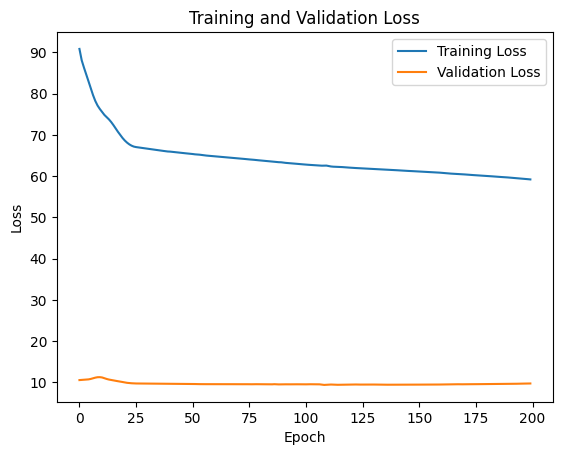

Model saved to models/trainable_gcesn_1l_mutag.pth
Average Time per Epoch: 0.01s
Average CPU Usage: 0.85%
Average Memory Usage: 0.15GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 2.23s
Max CPU Usage: 48.35%
Max Memory Usage: 0.15GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [75]:
set_seed(42)
trainable_gcesn_mutag = TrainableGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag.count_parameters()}\n")
                
single_train(trainable_gcesn_mutag, mutag_train_loader, mutag_val_loader,
                lr=0.001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_mutag.pth',
                binary_classification=True, is_esn=True)

In [77]:
trainable_gcesn_mutag = TrainableGCESN_1layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=3)
trainable_gcesn_mutag.load_state_dict(torch.load('models/trainable_gcesn_1l_mutag.pth'))
single_test(trainable_gcesn_mutag.to(device), mutag_test_loader)
inference_performance(trainable_gcesn_mutag.to(device), mutag_test_loader)

Accuracy: 0.8421
Average Sensitivity (Recall): 0.8846
Average Specificity: 0.7500

Average Inference Time per Batch: 0.0003s
Average CPU Usage: 28.27%
Average Memory Usage: 0.15GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

Total number of trainable parameters: 690

Epoch 1, Train Loss: 68.88674533367157, Val Loss: 7.802936613559723
Time: 0.03s, CPU: 27.15%, Memory: 0.09GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 67.47328698635101, Val Loss: 7.684408485889435
Time: 0.02s, CPU: 45.60%, Memory: 0.10GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 66.84442222118378, Val Loss: 7.628437757492065
Time: 0.02s, CPU: 51.45%, Memory: 0.10GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 66.57153177261353, Val Loss: 7.604519009590149
Time: 0.02s, CPU: 18.75%, Memory: 0.10GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 66.45860636234283, Val Loss: 7.595090746879578
Time: 0.02s, CPU: 0.00%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 66.40917921066284, Val Loss: 7.591879487037659
Time: 0.02s, CPU: 0.00%, Memory: 0.11GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 66.38444817066193, Val Loss: 7.591133415699005
Time: 0.02s, CPU: 0.00%, Memory: 0.11GB, GPU: 0.00GB, GPU

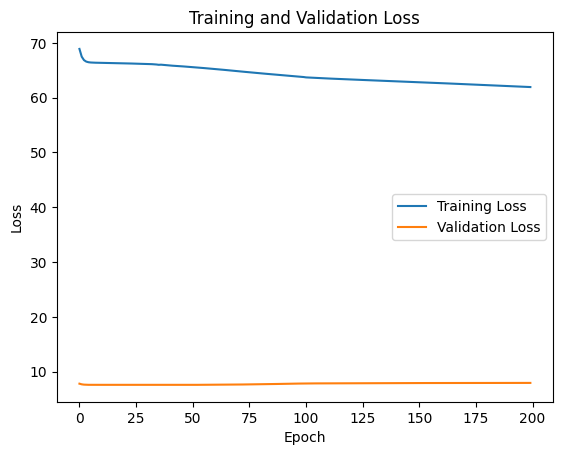

Model saved to models/trainable_gcesn_1l_emci.pth
Average Time per Epoch: 0.02s
Average CPU Usage: 1.13%
Average Memory Usage: 0.11GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 3.42s
Max CPU Usage: 51.45%
Max Memory Usage: 0.11GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [80]:
set_seed(42)
trainable_gcesn_emci = TrainableGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=2)
print(f"Total number of trainable parameters: {trainable_gcesn_emci.count_parameters()}\n")
                
single_train(trainable_gcesn_emci, emci_train_loader, emci_val_loader,
                lr=0.0005, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_emci.pth',
                binary_classification=True, is_esn=True)

In [83]:
trainable_gcesn_emci = TrainableGCESN_1layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=3)
trainable_gcesn_emci.load_state_dict(torch.load('models/trainable_gcesn_1l_emci.pth'))
single_test(trainable_gcesn_emci.to(device), emci_test_loader)
inference_performance(trainable_gcesn_emci.to(device), emci_test_loader)

Accuracy: 0.5926
Average Sensitivity (Recall): 0.0000
Average Specificity: 1.0000

Average Inference Time per Batch: 0.0003s
Average CPU Usage: 36.38%
Average Memory Usage: 0.13GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


#### SLIM160

Total number of trainable parameters: 707

Epoch 1, Train Loss: 109963.83532714844, Val Loss: 12469.072631835938
Time: 0.69s, CPU: 26.50%, Memory: 0.30GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 2, Train Loss: 98368.39245605469, Val Loss: 11281.258850097656
Time: 0.60s, CPU: 32.75%, Memory: 0.48GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 3, Train Loss: 88982.67358398438, Val Loss: 10372.491485595703
Time: 0.59s, CPU: 19.25%, Memory: 0.50GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 4, Train Loss: 82020.84686279297, Val Loss: 9658.610595703125
Time: 0.58s, CPU: 17.05%, Memory: 0.51GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 5, Train Loss: 76466.25408935547, Val Loss: 9024.576965332031
Time: 0.60s, CPU: 38.05%, Memory: 0.50GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 6, Train Loss: 71576.8616027832, Val Loss: 8424.966522216797
Time: 0.59s, CPU: 15.15%, Memory: 0.51GB, GPU: 0.00GB, GPU Util: 0.00%
Epoch 7, Train Loss: 66915.41900634766, Val Loss: 7817.085845947266
Time: 0.57s, CPU: 29.70%, Memory: 0.52GB, GPU: 0.00G

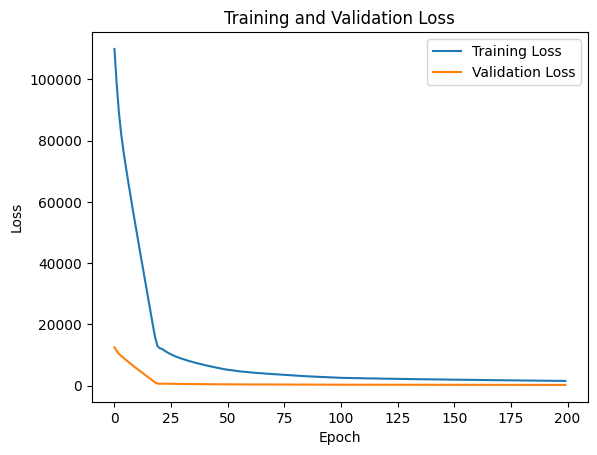

Model saved to models/trainable_gcesn_1l_slim160.pth
Average Time per Epoch: 0.59s
Average CPU Usage: 29.45%
Average Memory Usage: 0.51GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%

Total Training Time: 118.25s
Max CPU Usage: 56.45%
Max Memory Usage: 0.55GB
Max GPU Usage: 0.00GB
Max GPU Utilization: 0.00%


In [90]:
set_seed(42)
trainable_gcesn_slim160 = TrainableGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=3)
print(f"Total number of trainable parameters: {trainable_gcesn_slim160.count_parameters()}\n")
                
single_train(trainable_gcesn_slim160, slim160_train_loader, slim160_val_loader,
                lr=0.0001, num_epochs=200, patience=5, step_size=100, gamma=0.5, 
                save_path='models/trainable_gcesn_1l_slim160.pth',
                binary_classification=False, is_esn=True)

In [91]:
trainable_gcesn_slim160 = TrainableGCESN_1layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=3)
trainable_gcesn_slim160.load_state_dict(torch.load('models/trainable_gcesn_1l_slim160.pth'))
single_test(trainable_gcesn_slim160.to(device), slim160_test_loader, binary_classification=False)
inference_performance(trainable_gcesn_slim160.to(device), slim160_test_loader)

Accuracy: 0.3030
Average Sensitivity (Recall): 0.3148
Average Specificity: 0.6538

Average Inference Time per Batch: 0.0217s
Average CPU Usage: 23.00%
Average Memory Usage: 0.56GB
Average GPU Usage: 0.00GB
Average GPU Utilization: 0.00%


### Trainable 2-Layer GCESN

#### MUTAG

Total number of trainable parameters: 1934

Epoch 1, Train Loss: 72.81065428256989, Val Loss: 10.413823127746582
Time: 0.06s, CPU: 15.05%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 3.50%
Epoch 2, Train Loss: 67.4252137541771, Val Loss: 10.883115828037262
Time: 0.05s, CPU: 12.35%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 3, Train Loss: 63.93476343154907, Val Loss: 9.588890075683594
Time: 0.05s, CPU: 17.05%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 7.00%
Epoch 4, Train Loss: 62.36023634672165, Val Loss: 9.823633432388306
Time: 0.05s, CPU: 13.55%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 8.50%
Epoch 5, Train Loss: 58.92072665691376, Val Loss: 9.063664376735687
Time: 0.05s, CPU: 6.25%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 6, Train Loss: 56.75126397609711, Val Loss: 9.032931625843048
Time: 0.05s, CPU: 14.75%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 10.00%
Epoch 7, Train Loss: 54.206273406744, Val Loss: 7.961103022098541
Time: 0.05s, CPU: 7.30%, Memory: 3.98GB, GPU: 0.02GB, 

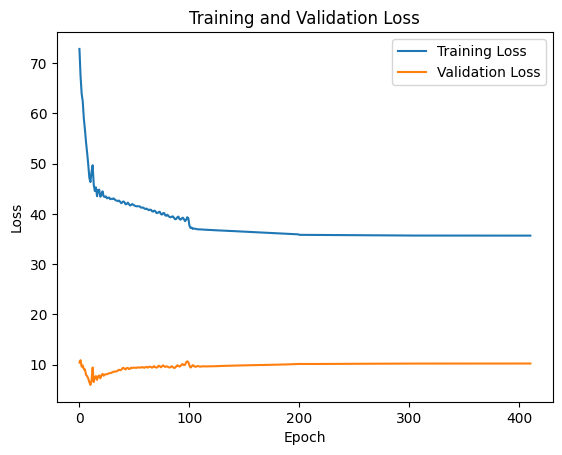

Model saved to models/trainable_gcesn_2l_mutag.pth
Average Time per Epoch: 0.05s
Average CPU Usage: 18.30%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.39%

Total Training Time: 21.65s
Max CPU Usage: 52.85%
Max Memory Usage: 3.98GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%


In [12]:
set_seed(42)
trainable_gcesn_mutag_2 = TrainableGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_mutag_2.count_parameters()}\n")
                
single_train(trainable_gcesn_mutag_2, mutag_train_loader, mutag_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_2l_mutag.pth',
                binary_classification=True, is_esn=True)

In [13]:
trainable_gcesn_mutag_2 = TrainableGCESN_2layer(mutag_num_features, 2*mutag_num_features, mutag_num_classes, num_iterations=6)
trainable_gcesn_mutag_2.load_state_dict(torch.load('models/trainable_gcesn_2l_mutag.pth'))
single_test(trainable_gcesn_mutag_2.to(device), mutag_test_loader)
inference_performance(trainable_gcesn_mutag_2.to(device), mutag_test_loader)

Accuracy: 0.8947
Average Sensitivity (Recall): 0.8846
Average Specificity: 0.9167

Average Inference Time per Batch: 0.0020s
Average CPU Usage: 19.05%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 0.00%


#### PROTEINS

#### DND

#### ENZYM

#### OASIS

#### EMCI-AD

Total number of trainable parameters: 2514

Epoch 1, Train Loss: 356609489472.0, Val Loss: 3282818560.0
Time: 0.11s, CPU: 20.80%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 1.00%
Epoch 2, Train Loss: 16580264768.0, Val Loss: 1645712928.0
Time: 0.11s, CPU: 27.80%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 4.00%
Epoch 3, Train Loss: 19079690960.0, Val Loss: 989616160.0
Time: 0.11s, CPU: 31.45%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 8.00%
Epoch 4, Train Loss: 11809948792.0, Val Loss: 493971720.0
Time: 0.11s, CPU: 25.70%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 5, Train Loss: 6126869124.0, Val Loss: 409154960.0
Time: 0.11s, CPU: 22.30%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 6, Train Loss: 4584633516.0, Val Loss: 1062849760.0
Time: 0.11s, CPU: 23.20%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 7, Train Loss: 8197403608.0, Val Loss: 375761680.0
Time: 0.12s, CPU: 22.95%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 9.00%
Epoch 8, Train Loss: 4328356560.0, Val Loss: 3976402

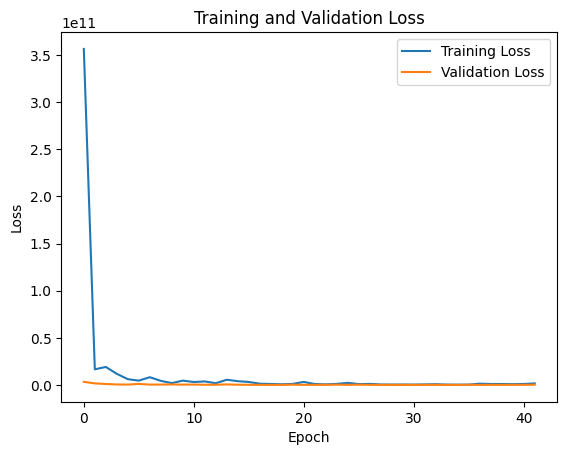

Model saved to models/trainable_gcesn_2l_emci.pth
Average Time per Epoch: 0.10s
Average CPU Usage: 26.56%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 9.35%

Total Training Time: 4.31s
Max CPU Usage: 47.20%
Max Memory Usage: 3.98GB
Max GPU Usage: 0.02GB
Max GPU Utilization: 11.00%


In [14]:
set_seed(42)
trainable_gcesn_emci_2 = TrainableGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_emci_2.count_parameters()}\n")
                
single_train(trainable_gcesn_emci_2, emci_train_loader, emci_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_2l_emci.pth',
                binary_classification=True, is_esn=True)

In [15]:
trainable_gcesn_emci_2 = TrainableGCESN_2layer(emci_num_features, 2*emci_num_features, emci_num_classes, num_iterations=6)
trainable_gcesn_emci_2.load_state_dict(torch.load('models/trainable_gcesn_2l_emci.pth'))
single_test(trainable_gcesn_emci_2.to(device), emci_test_loader)
inference_performance(trainable_gcesn_emci_2.to(device), emci_test_loader)

Accuracy: 0.4074
Average Sensitivity (Recall): 0.7273
Average Specificity: 0.1875

Average Inference Time per Batch: 0.0014s
Average CPU Usage: 24.62%
Average Memory Usage: 3.98GB
Average GPU Usage: 0.02GB
Average GPU Utilization: 1.00%


#### SLIM160

Total number of trainable parameters: 2531

Epoch 1, Train Loss: 4.573337561111462e+19, Val Loss: 1.3960533884157297e+18
Time: 0.47s, CPU: 42.30%, Memory: 3.98GB, GPU: 0.02GB, GPU Util: 14.50%
Epoch 2, Train Loss: 1.3940677666232336e+19, Val Loss: 1.63984788259917e+18
Time: 0.20s, CPU: 37.70%, Memory: 3.99GB, GPU: 0.06GB, GPU Util: 36.00%
Epoch 3, Train Loss: 7.850207328023347e+18, Val Loss: 9.09063644623405e+17
Time: 0.19s, CPU: 37.15%, Memory: 4.01GB, GPU: 0.06GB, GPU Util: 45.00%
Epoch 4, Train Loss: 4.0141720322236744e+18, Val Loss: 7.255312374222029e+17
Time: 0.22s, CPU: 36.40%, Memory: 4.02GB, GPU: 0.06GB, GPU Util: 46.00%
Epoch 5, Train Loss: 2.732334559860359e+18, Val Loss: 6.039229729100268e+17
Time: 0.20s, CPU: 32.15%, Memory: 4.00GB, GPU: 0.06GB, GPU Util: 42.00%
Epoch 6, Train Loss: 1.4798686798384988e+18, Val Loss: 4.656469539343565e+17
Time: 0.19s, CPU: 36.90%, Memory: 4.01GB, GPU: 0.06GB, GPU Util: 40.00%
Epoch 7, Train Loss: 1.6505056324170547e+18, Val Loss: 4.344504031

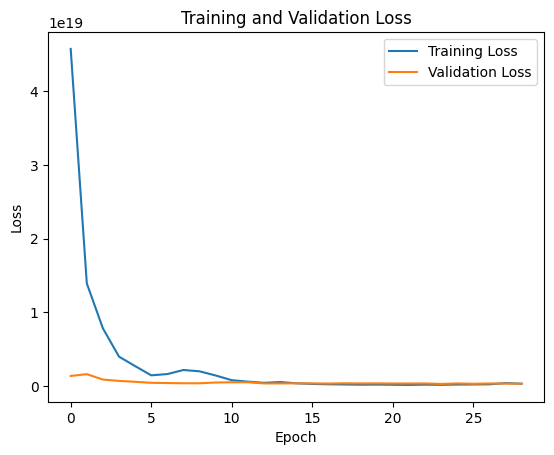

Model saved to models/trainable_gcesn_2l_slim160.pth
Average Time per Epoch: 0.21s
Average CPU Usage: 39.57%
Average Memory Usage: 4.00GB
Average GPU Usage: 0.06GB
Average GPU Utilization: 41.00%

Total Training Time: 6.12s
Max CPU Usage: 58.70%
Max Memory Usage: 4.02GB
Max GPU Usage: 0.06GB
Max GPU Utilization: 48.00%


In [16]:
set_seed(42)
trainable_gcesn_slim160_2 = TrainableGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=6)
print(f"Total number of trainable parameters: {trainable_gcesn_slim160_2.count_parameters()}\n")
                
single_train(trainable_gcesn_slim160_2, slim160_train_loader, slim160_val_loader,
                lr=0.001, num_epochs=500, patience=5, step_size=100, gamma=0.1, 
                save_path='models/trainable_gcesn_2l_slim160.pth',
                binary_classification=True, is_esn=True)

In [17]:
trainable_gcesn_slim160_2 = TrainableGCESN_2layer(slim160_num_features, 2*slim160_num_features, slim160_num_classes, num_iterations=6)
trainable_gcesn_slim160_2.load_state_dict(torch.load('models/trainable_gcesn_2l_slim160.pth'))
single_test(trainable_gcesn_slim160_2.to(device), slim160_test_loader)
inference_performance(trainable_gcesn_slim160_2.to(device), slim160_test_loader)

Accuracy: 0.4375
Average Sensitivity (Recall): 0.2667
Average Specificity: 0.5882

Average Inference Time per Batch: 0.0050s
Average CPU Usage: 33.15%
Average Memory Usage: 4.00GB
Average GPU Usage: 0.09GB
Average GPU Utilization: 8.67%
